### import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import mne
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from scipy import signal
import warnings
from scipy import signal
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from scipy import misc


from itertools import groupby
from operator import itemgetter

from sklearn.metrics import mean_squared_error
from math import sqrt
sns.set_context("poster", font_scale=0.75)


# Characterizing the Pressure Gauge

The ADP5120 is a pressure gauge which is built to measure up to 25 kPa (187.5 mmHg) with 1.25% FS accuracy, or accuracy up to 24.69 kPa (185.2 mmHg). A "healthy" value for systolic pressure ranges between 90 mmHg and 140 mmHg, depending on various factors; however, fatally critical values are found above 180 mmHg. At this point and any value of blood pressure beyond it, the contribution of blood pressure to the overall triage score is negative and skews the score towards a lower degree of medical attention.

The pressure gauge

[[16.32723241]] [671.77094535]


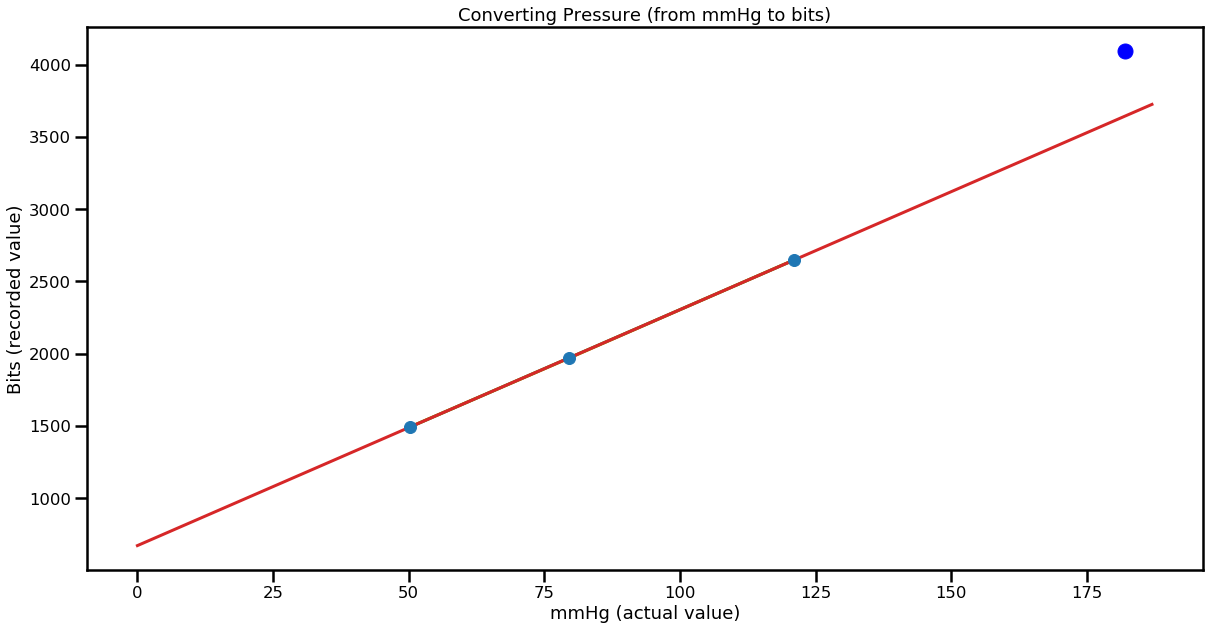

In [2]:
bar067_data = pd.read_csv("data/calibration/066bar_0125.csv", delimiter = ",") # between 0.066 and 0.068 bar
bar106_data = pd.read_csv("data/calibration/107bar_0125.csv", delimiter = ",") # between 0.066 and 0.068 bar
bar1615_data = pd.read_csv("data/calibration/160bar_0125.csv", delimiter = ",") # between 0.066 and 0.068 bar
bar242_data = pd.read_csv("data/calibration/242bar_0125.csv", delimiter = ",") # between 0.066 and 0.068 bar

bar067 = np.round(np.mean(bar067_data), 2)
bar106 = np.round(np.mean(bar106_data), 2)
bar1615 = np.round(np.mean(bar1615_data), 2)
bar242 = np.round(np.mean(bar242_data), 2)

def barstommHg(bars, roundto=1):
    return np.round(bars*750,roundto)

def rms(y_actual, y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))

true067, true106, true1615, true242 = barstommHg(.067), barstommHg(.106), barstommHg(.1615,0), barstommHg(.242,0)

xvals = np.array([true067, true106, true1615])
allbars = [bar067_data, bar106_data, bar1615_data]
avgbitvalue = [bar067[0], bar106[0], bar1615[0]]


linreg = LinearRegression()
linreg.fit(np.array(xvals).reshape(-1,1),np.array(avgbitvalue).reshape(-1,1))

y_train_pred = linreg.predict(np.array(xvals).reshape(-1,1))


yerror = [rms(np.ones(eachbardata.shape[0])*np.mean(eachbardata)[0], eachbardata) for eachbardata in allbars]
fig = plt.subplots(1,1,figsize = (20,10))
plt.errorbar(xvals, avgbitvalue, yerr=yerror, fmt='o')
plt.plot(xvals, avgbitvalue)
plt.plot(xvals,y_train_pred)
plt.xlabel('mmHg (actual value)')
plt.ylabel('Bits (recorded value)')
plt.title('Converting Pressure (from mmHg to bits)')

m, b = linreg.coef_, linreg.intercept_

def y(x):
    return m*x +b
x = np.arange(barstommHg(.25))
# y = m*x + b
plt.plot(x, y(x).T)
print(m, b)
# true242
plt.plot(true242, bar242[0], 'bo', markersize = 15)

def bitstommHg(bits):
    return (bits - b)/m

In [3]:
true067, true106, true1615, true242

(50.2, 79.5, 121.0, 182.0)

In [4]:
print('Standard deviations (in bits)')
print(np.std(bar067_data)[0])
print(np.std(bar106_data)[0])
print(np.std(bar1615_data)[0])
# print(np.std(bar242_data)[0])

print('Standard deviations (in mmHg)')
print(bitstommHg(np.std(bar067_data)[0])[0])
print(bitstommHg(np.std(bar106_data)[0])[0])
print(bitstommHg(np.std(bar1615_data)[0])[0])

print('stdev in mmHg')
print(bitstommHg(np.std(bar067_data)[0]*10)[0][0])
print(bitstommHg(np.std(bar106_data)[0]*10)[0][0])
print(bitstommHg(np.std(bar1615_data)[0]*10)[0][0])
# print(bitstommHg(np.std(bar242_data)[0]*100)[0][0])


print('Actual Signal (in mmHg)')
print(bitstommHg(bar067[0])[0][0])
print(bitstommHg(bar106[0])[0][0])
print(bitstommHg(bar1615[0])[0][0])
# print(bitstommHg(bar242[0])[0][0])

print('')
print('Signal to noise ratio')
print(bar067[0]/np.std(bar067_data)[0])
print(bar106[0]/np.std(bar106_data)[0])
print(bar1615[0]/np.std(bar1615_data)[0])
# print(bar242[0]/np.std(bar242_data)[0])


Standard deviations (in bits)
15.809193726498435
32.52168499378085
22.660262575707282
Standard deviations (in mmHg)
[-40.17593033]
[-39.15233424]
[-39.7563204]
stdev in mmHg
-31.461486879142733
-21.22552596877179
-27.26538757753544
Actual Signal (in mmHg)
50.27668096372544
79.36918042815034
121.05413860812422

Signal to noise ratio
94.41657973348183
60.50270766647778
116.86757782052496


In [5]:
# print(bitstommHg(840*10)[0][0], bitstommHg(930*10)[0][0])
# print((bitstommHg(930*10)[0][0] - bitstommHg(840*10)[0][0])/2)
# print(bitstommHg(840*10)[0][0] + ((bitstommHg(930*10)[0][0] - bitstommHg(840*10)[0][0])/2))
# print()


def signal_to_noise(array):
    array = np.array(array)
    
    # find the standard deviation and mean (weird units)
    stdev_bits, signal_bits = np.std(array), np.mean(array)
    
    # add half the standard deviation to the mean
    upper_bits, lower_bits = (signal_bits + stdev_bits), (signal_bits - stdev_bits)
    
    # convert the half-add and half-subtract to mmHg
    upper_mmHg, lower_mmHg = bitstommHg(upper_bits), bitstommHg(lower_bits)
                                                          
    # subtract the half-subtract from the half-add (in mmHg), and then take half of that
    # convert the mean to mmHg 
    # divvy the mean (mmHg) by the half of the half-add and subtract
    
    
    return signal_bits
#     stn = signal/
    print('this is the signal to noise ratio')

print(bar1615[0])
stdev1615 = np.std(bar1615_data)[0] # in bits
print(stdev1615)
high = bar1615[0] + stdev1615
low = bar1615[0] - stdev1615

noise = bitstommHg(bar1615[0] + stdev1615)[0][0] - bitstommHg(bar1615[0] - stdev1615)[0][0]
print(noise)

2648.25
22.660262575707282
2.775762849884174


The noise is approximately 0.78 mmHg (~100 bits) when signal is  

I need to write a function which will find the derivative of the slope for a range of values where 109/61 is found, say a range of 5 samples. 

1. Find where pressure is 109mmHg.
2. Find the derivative at that point.


Instead of simply attempting to find the derivative at that location, I could also attempt to fit the data to a curve, and then find the derivative using that function.

To find the rate of air flow, I can use some form of linear regression to follow each curve when air is released. I expect the rate of air flow to change marginally between experiments using the same nozzle for some reasons:
1. innate variance within experiments
2. the volume pumped into the cuff may differ (although the intention was to keep it from varying from experiment to experiment)

In [6]:
def find_nearest(array, value):
    '''
    returns the index of the value nearest to the sought after value
    '''
    a = np.asarray(array)
    crossings = np.zeros(a.shape)
    counter = 0
    for position, each in enumerate(a):
        # position denotes the index of the later value
        # check to see if it crosses the value
        if position == 0:
            pass
        else:
            if each < value:
                if a[position-1] > value: 
                    crossings[counter] = position + 3
                    counter += 1
    crossings = [i for i in crossings if i != 0]
    return (np.asarray(crossings).T).astype(int)

def pressureDips(pressures, range_of_values, value_sought):
    '''
    INPUTS: 
    pressures = the array of pressure values in bits
    range_of_values = the number of values we're taking into account when calculating the derivative
    value_sought = the pressure value we're looking for (systolic/diastolic)
    
    OUTPUTS:
    derivatives = array of derivatives found
    '''
    
    # find where the pressure is found (get indices)
    p_index = np.asarray(np.where(np.array(pressures) == value_sought)[0])
    
    if len(p_index) == 0:
        p_index = np.asarray(find_nearest(pressures, value_sought))[0]
        
    # get derivative    
    # check to see if odd, if so, subtract 1 (for sake of getting even on both sides)
    if range_of_values%2:
        range_of_values = range_of_values - 1
    
    derivatives = np.zeros(p_index.shape)
    
    xleft = [int(each) for each in p_index - (range_of_values/2)]
    xright = [int(each) for each in p_index + (range_of_values/2)]
    
    for counter, each_index in enumerate(p_index):
        derivatives[counter] = (pressures.iloc[xright[counter]][0] - pressures.iloc[xleft[counter]][0])/(range_of_values)
        
    return derivatives


In [7]:
# from stackoverflow

from __future__ import division 


def interpolated_intercept(x, y1, y2):
    """Find the intercept of two curves, given by the same x data"""

    def intercept(point1, point2, point3, point4):
        """find the intersection between two lines
        the first line is defined by the line between point1 and point2
        the first line is defined by the line between point3 and point4
        each point is an (x,y) tuple.

        So, for example, you can find the intersection between
        intercept((0,0), (1,1), (0,1), (1,0)) = (0.5, 0.5)

        Returns: the intercept, in (x,y) format
        """    

        def line(p1, p2):
            A = (p1[1] - p2[1])
            B = (p2[0] - p1[0])
            C = (p1[0]*p2[1] - p2[0]*p1[1])
            return A, B, -C

        def intersection(L1, L2):
            D  = L1[0] * L2[1] - L1[1] * L2[0]
            Dx = L1[2] * L2[1] - L1[1] * L2[2]
            Dy = L1[0] * L2[2] - L1[2] * L2[0]

            x = Dx / D
            y = Dy / D
            return x,y

        L1 = line([point1[0],point1[1]], [point2[0],point2[1]])
        L2 = line([point3[0],point3[1]], [point4[0],point4[1]])

        R = intersection(L1, L2)

        return R

    idx = np.argwhere(np.diff(np.sign(y1 - y2)) != 0)
    xc, yc = intercept((x[idx], y1[idx]),((x[idx+1], y1[idx+1])), ((x[idx], y2[idx])), ((x[idx+1], y2[idx+1])))
    return xc,yc


In [8]:
# create a derivative function 
def derivs(pressurepoints):
    pressurepoints = np.array(pressurepoints)
    deriv = list()
    for counter, each in enumerate(pressurepoints):
        if counter != 0:
            deriv.append((pressurepoints[counter]-pressurepoints[counter-1])*1.12)
    return deriv

In [9]:
def plot_me(dataframe, title, x_axis='Time (s)', y_axis='Pressure (mmHg)', hold='ON'):
    fig, ax = plt.subplots(1, 1, figsize = (16,5))
    time = np.linspace(0, len(dataframe)/1.12, len(dataframe))
    ax.set_title(str(title))
    ax.plot(time, dataframe);
    ax.set_xlabel(str(x_axis))
    ax.set_ylabel(str(y_axis))
    ax.grid(True)
    if hold != 'ON':
        plt.show()

These are the files pertaining to the various syringes.

In [10]:
filenames = ! ls cd 'data/021220/'
filenames = filenames[2:]

all_gauges = {}
true_bp = {}

df = pd.DataFrame()

for i, each in enumerate(filenames):
    # renaming 
    new_name = (str(each[0]+'_'+str(each[-8:-4]))).lower()
    all_gauges[new_name] = []
    all_gauges[new_name] = pd.read_csv(str('data/021220/') + filenames[i], sep = '{"pressure":', engine = 'python')
    all_gauges[new_name].drop(columns= ['Unnamed: 0'], inplace = True)
    all_gauges[new_name] = all_gauges[new_name][all_gauges[new_name].columns[0]].replace({'}':''}, regex=True)
    all_gauges[new_name].name = 'Pressure (mmHg)'
    all_gauges[new_name] = np.around(bitstommHg(all_gauges[new_name].values.astype(float))[0], decimals=2)
        
    # for true bp measurement
    true_bp[new_name] = []
all_gauges['m_27ga']= pd.read_csv('data/MARKUSN_0210.csv')
all_gauges['m_27ga'] = [np.around(bitstommHg(each), decimals=2)[0][0] for each in all_gauges['m_27ga'].values]

all_gauges.keys()

dict_keys(['a_15ga', 'a_18ga', 'a_20ga', 'a_21ga', 'a_22ga', 'a_23ga', 'a_25ga', 'c_23ga', 'c_25ga', 'a_27ga', 'c_30ga', 'm_27ga'])

Setting up the experimentally obtained data:

In [11]:
true_bp['a_15ga'] = np.array([122,123])
true_bp['a_18ga'] = np.array([122,123])
true_bp['a_20ga'] = np.array([109,103])
true_bp['a_21ga'] = np.array([115,110])
true_bp['a_22ga'] = np.array([115,110])
true_bp['a_23ga'] = np.array([113,109])
true_bp['a_25ga'] = np.array([118,119])
true_bp['a_27ga'] = np.array([119,116])
true_bp['c_23ga'] = np.array([133,121])
true_bp['c_25ga'] = np.array([120,109,118])
true_bp['a_27ga'] = np.array([128,120])
true_bp['c_30ga'] = np.array([134,131])
true_bp['m_27ga'] = np.array([115,107])


# true_bp['a_15ga'].std()

1. "Is the derivative the same for all of them, no matter the gauge?"

2. "Are the means significantly different from each other?"

In [12]:
def find_deflation_range(array, systole=209.66, diastole=100):
    '''
    inputs:
    - array: numpy array with mmHg pressure values containing all pumps for a single syringe
    - systole: max value of systole accepted (here, the maximum value read from the gauge)
    - diastole: minimum value of systole accepted (here, 80)
    outputs:
    - [start, end]: dictionary of numpy arrays where deflation starts
    '''
    at_systole = np.zeros(len(array))
    
    # find where it drops from 209.66
    counter = 0
    for index, each in enumerate(array):
        
        # looking for max pressure
        if each == systole:
            at_systole[counter] += int(index)
            counter += 1
        
    at_systole = np.trim_zeros(at_systole).astype(int)
#     print(at_systole)
    
    # trying to separate array to pull only the peaks
    peaks = len(at_systole) - 1
    start_release = np.zeros(peaks).astype(int)
    counter = 1
    for index, each in enumerate(at_systole):
        
        if index == 0:
            start_release[0] = at_systole[peaks-index]
        
        # start from the end, and check to see if that number is more than two greater than the previous value
        if at_systole[peaks-index] > at_systole[peaks-index - 1] + 1:
            start_release[counter] = (at_systole[peaks-index -1])
            counter += 1
        else:
            pass
        
    start_release = np.trim_zeros(start_release).astype(int)
    end_release = np.zeros(len(start_release))

    for i, each in enumerate(start_release):
        
        # when it's the first point in start_release, we need to search from that index to the end of the array
        if i == 0: 
            cross = find_nearest(array[start_release[i]:], diastole)[0]
            end_release[i] = (cross + start_release[i]).astype(int)
        
        # otherwise, we search up to the next smallest index listed in start_release, minus a couple values
        else:
            try:
                cross = find_nearest(array[start_release[i]:start_release[i-1] - 4], diastole)[0]
                if cross == -1:
                    cross = 2
                end_release[i] = (cross + start_release[i]).astype(int)

            # in the case that c_30ga comes up
            except IndexError:
                start_release[i] = 0
                cross = 0
                end_release[i] = (cross + start_release[i] + 0).astype(int)
    
        
    # flip order of start_release and end_release
    
    # return start and end of deflation
    return [np.sort(start_release), np.sort(end_release).astype(int)]

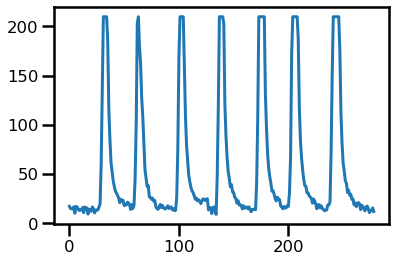

In [13]:
plt.plot(all_gauges['a_21ga'])

In [14]:
deflations = {}
for each in all_gauges:
    print(each)
    deflations[each] = {}
    deflations[each]['start'] = []
    deflations[each]['end'] = []
    deflations[each]['start'] = list(find_deflation_range(all_gauges[each])[0])
    deflations[each]['end'] = list(find_deflation_range(all_gauges[each])[1])
    
    # drop no-good data
    if each == 'a_18ga':
        deflations['a_18ga']['start'].pop(1)
        deflations['a_18ga']['end'].pop(1)
        del(deflations['a_18ga']['start'][1])
        del(deflations['a_18ga']['end'][1])
        
        deflations['a_18ga']['start'].pop(2)
        deflations['a_18ga']['end'].pop(2)
        del(deflations['a_18ga']['start'][4-1-1])
        del(deflations['a_18ga']['end'][4-1-1])
        
    if each == 'a_20ga':
        deflations['a_20ga']['start'].pop(3)
        deflations['a_20ga']['end'].pop(3)
        del(deflations['a_20ga']['start'][3])
        del(deflations['a_20ga']['end'][3])
            
    if each == 'a_21ga':
        deflations['a_21ga']['start'].pop(0)
        deflations['a_21ga']['end'].pop(0)
        del(deflations['a_21ga']['start'][0])
        del(deflations['a_21ga']['end'][0])

        deflations['a_21ga']['start'].pop(0)
        deflations['a_21ga']['end'].pop(0)
        del(deflations['a_21ga']['start'][0])
        del(deflations['a_21ga']['end'][0])
        
    if each == 'a_23ga':
        deflations['a_23ga']['start'].pop(0)
        deflations['a_23ga']['end'].pop(0)
        del(deflations['a_23ga']['start'][0])
        del(deflations['a_23ga']['end'][0])

        deflations['a_23ga']['start'].pop(0)
        deflations['a_23ga']['end'].pop(0)
        del(deflations['a_23ga']['start'][1-1])
        del(deflations['a_23ga']['end'][1-1])

        deflations['a_23ga']['start'].pop(0)
        deflations['a_23ga']['end'].pop(0)
        del(deflations['a_23ga']['start'][2-2])
        del(deflations['a_23ga']['end'][2-2])

    if each == 'a_25ga':
        deflations['a_25ga']['start'].pop(0)
        deflations['a_25ga']['end'].pop(0)
        del(deflations['a_25ga']['start'][1-1])
        del(deflations['a_25ga']['end'][1-1])
       
        deflations['a_25ga']['start'].pop(2-1)
        deflations['a_25ga']['end'].pop(2-1)
        del(deflations['a_25ga']['start'][3-1-1])
        del(deflations['a_25ga']['end'][3-1-1])

    if each == 'c_25ga':
        deflations['c_25ga']['start'].pop(0)
        deflations['c_25ga']['end'].pop(0)
        del(deflations['c_25ga']['start'][0])
        del(deflations['c_25ga']['end'][0])        

    if each == 'a_27ga':
        # drop an incorrect term from c_30ga data
        deflations['a_27ga']['start'].pop(0)
        deflations['a_27ga']['end'].pop(0)
        del(deflations['a_27ga']['start'][0])
        del(deflations['a_27ga']['end'][0]) 
        
    if each == 'c_30ga':
        # drop an incorrect term from c_30ga data
        deflations['c_30ga']['start'].pop(0)
        deflations['c_30ga']['end'].pop(0)
        del(deflations['c_30ga']['end'][0]) 
        del(deflations['c_30ga']['start'][0]) 
#         deflations['c_30ga']['start'].remove(deflations['c_30ga']['start'][0])
#         deflations['c_30ga']['end'].remove(deflations['c_30ga']['end'][0])
    
#     if each == 'm_27ga':
#         deflations['m_27ga']['start'].pop(0)
#         deflations['m_27ga']['end'].pop(0)
#         del(deflations['m_27ga']['start'][0])
#         del(deflations['m_27ga']['end'][0]) 
        
#         deflations['m_27ga']['start'].pop(1)
#         deflations['m_27ga']['end'].pop(1)
#         del(deflations['m_27ga']['start'][1])
#         del(deflations['m_27ga']['end'][1]) 
        
#         deflations['m_27ga']['start'].pop(1)
#         deflations['m_27ga']['end'].pop(1)
#         del(deflations['m_27ga']['start'][1])
#         del(deflations['m_27ga']['end'][1]) 
        
    deflations[each]['pairs'] = []
    deflations[each]['pairs'] = sorted(list(deflations[each]['start'])+list(deflations[each]['end']));


a_15ga
a_18ga
a_20ga
a_21ga
a_22ga
a_23ga
a_25ga
c_23ga
c_25ga
a_27ga
c_30ga
m_27ga


a_15ga
pump_1


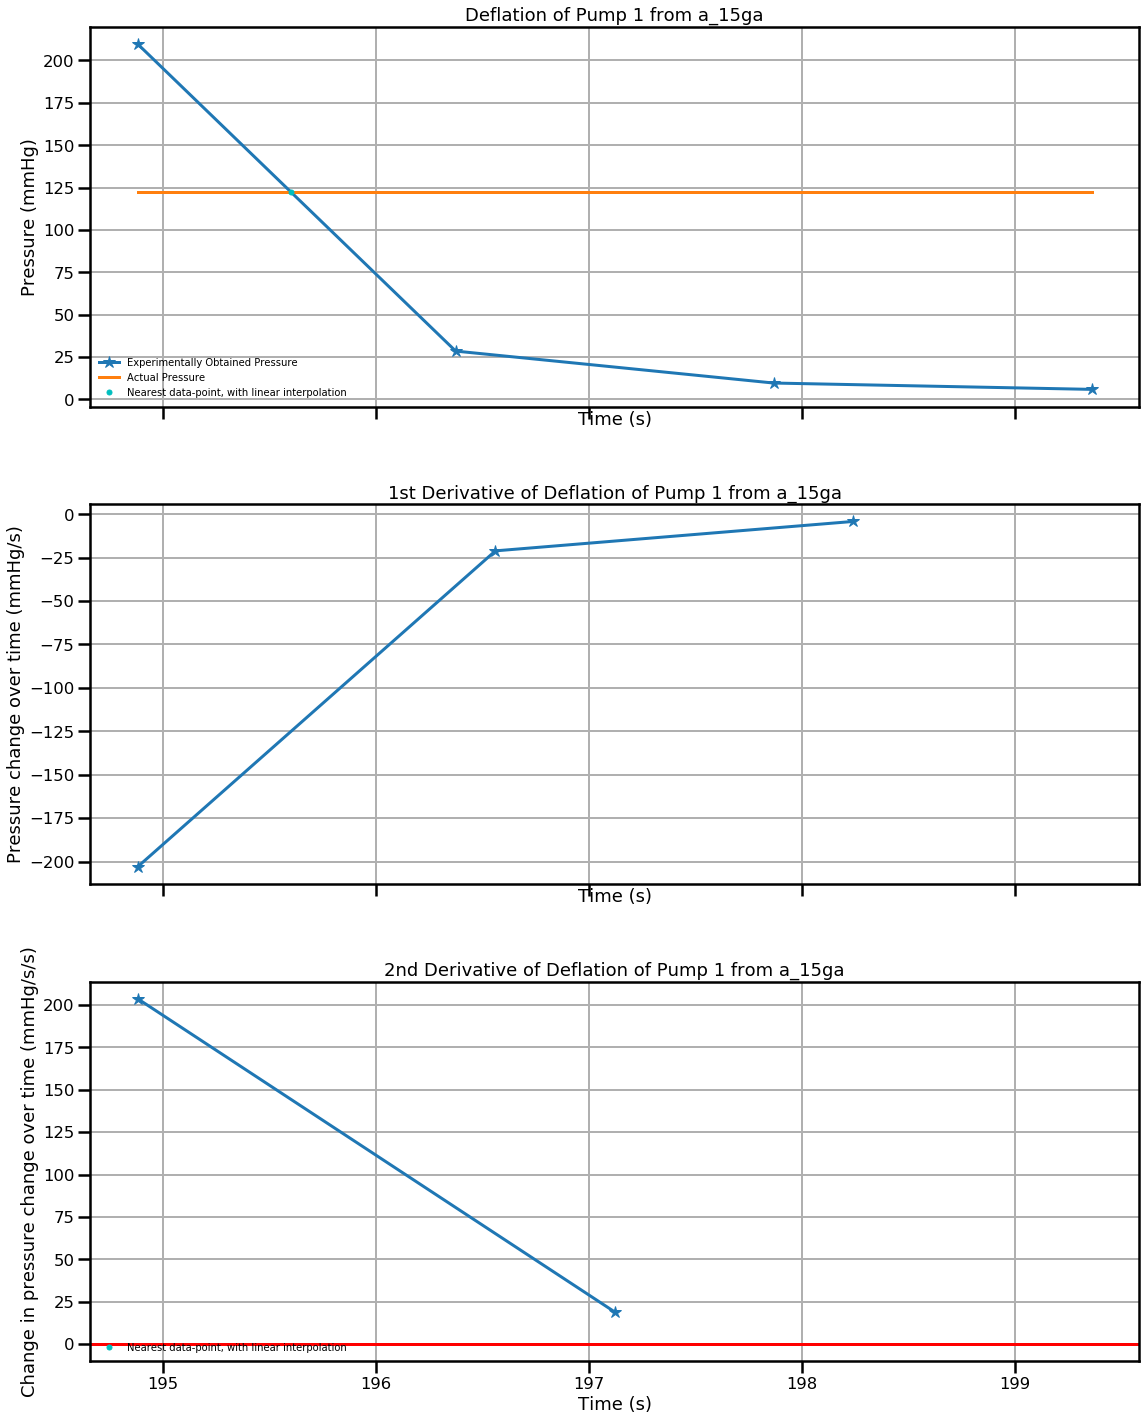

pump_2


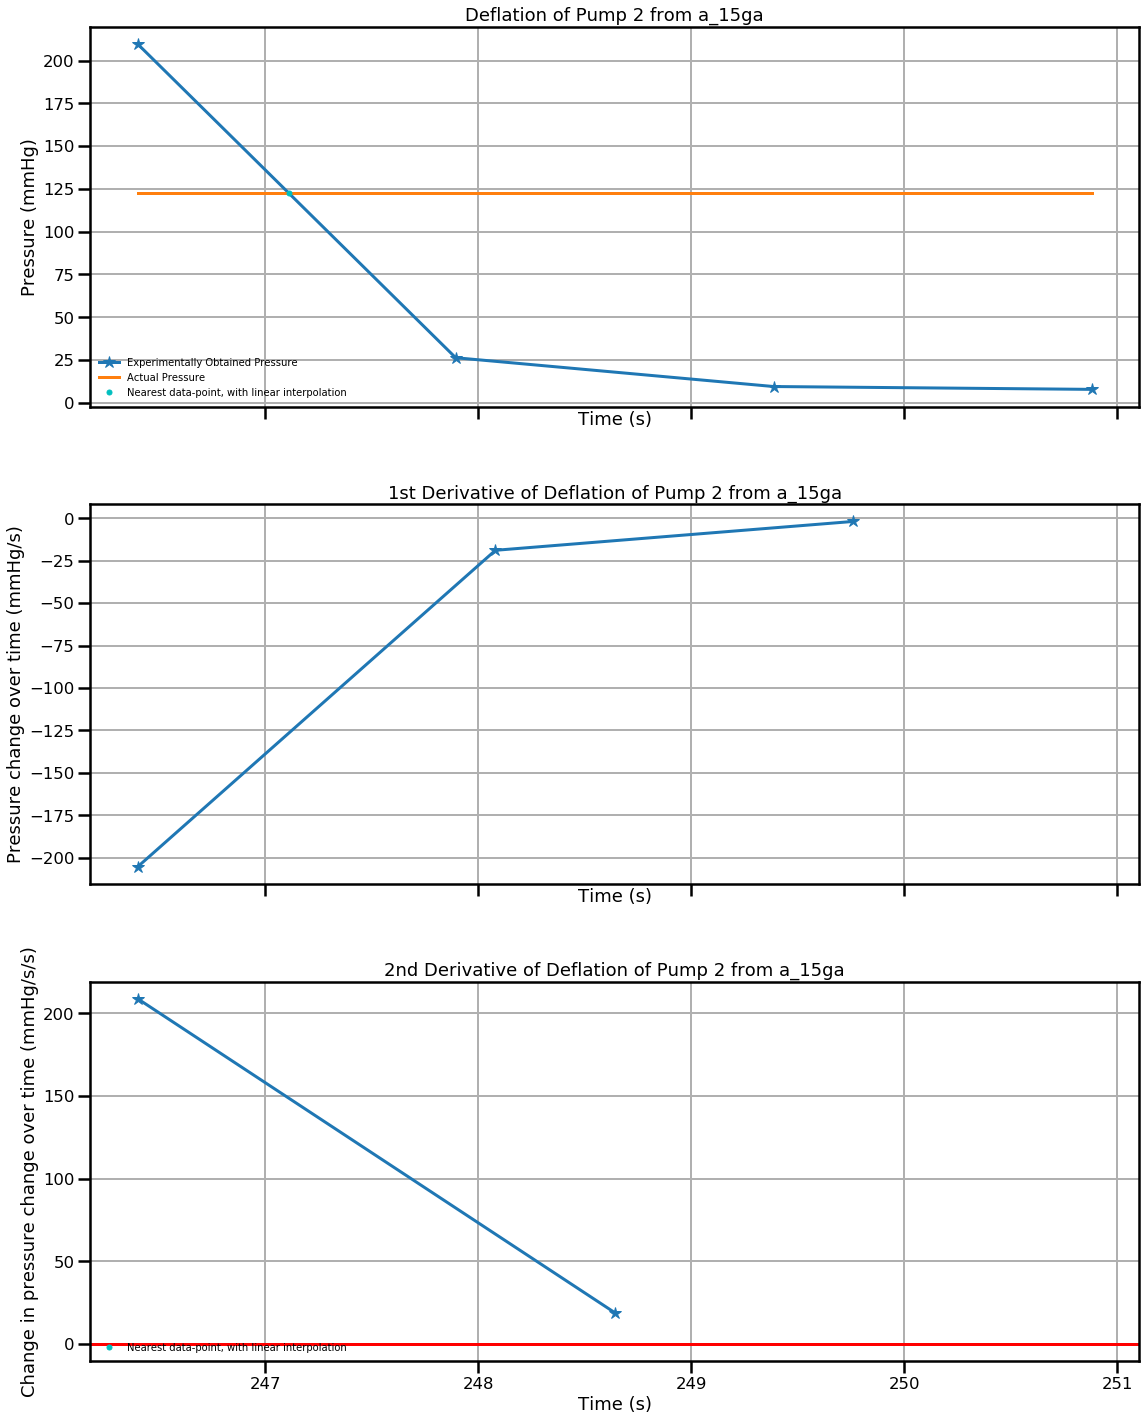

pump_3


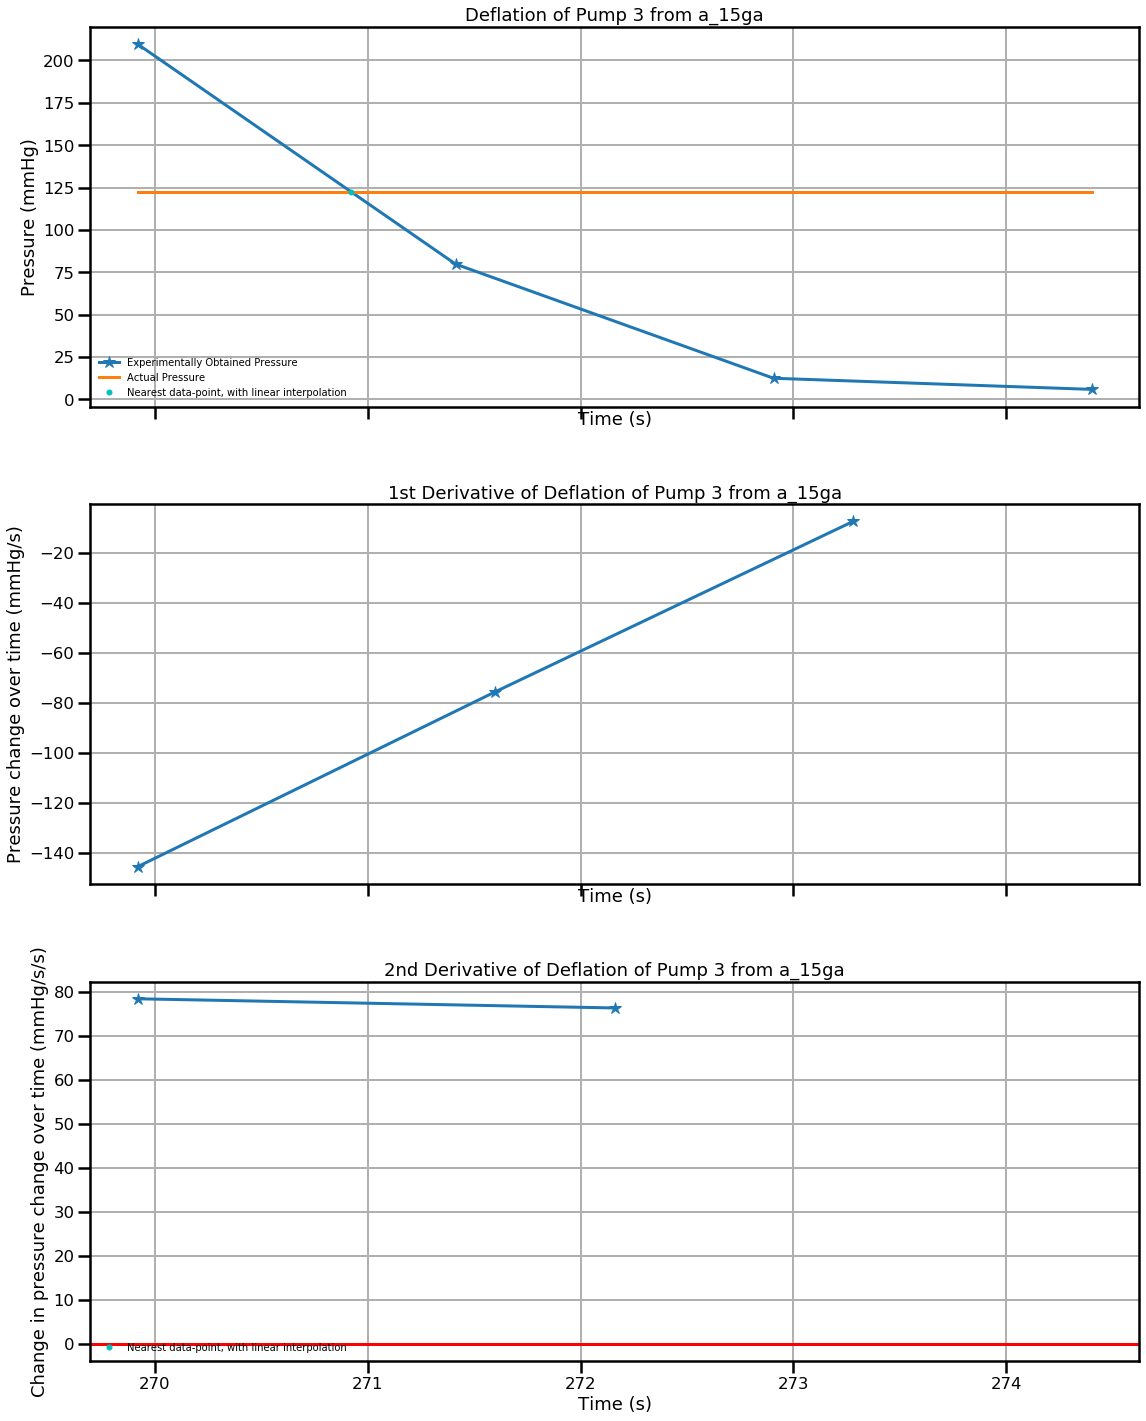

pump_4


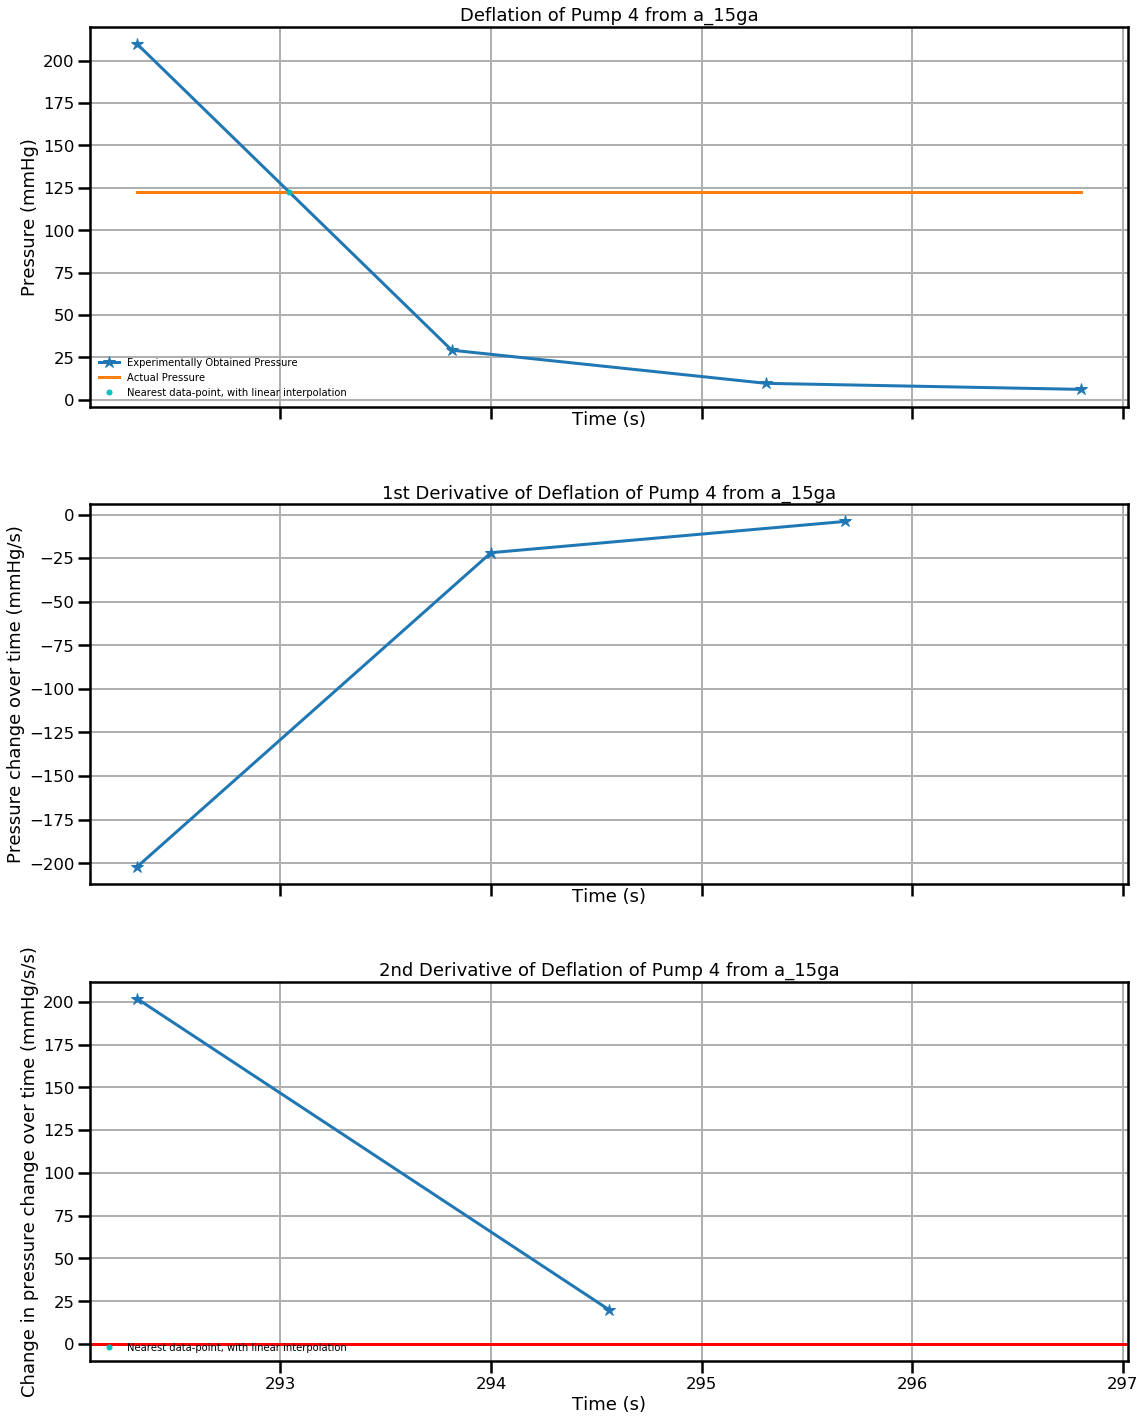

pump_5


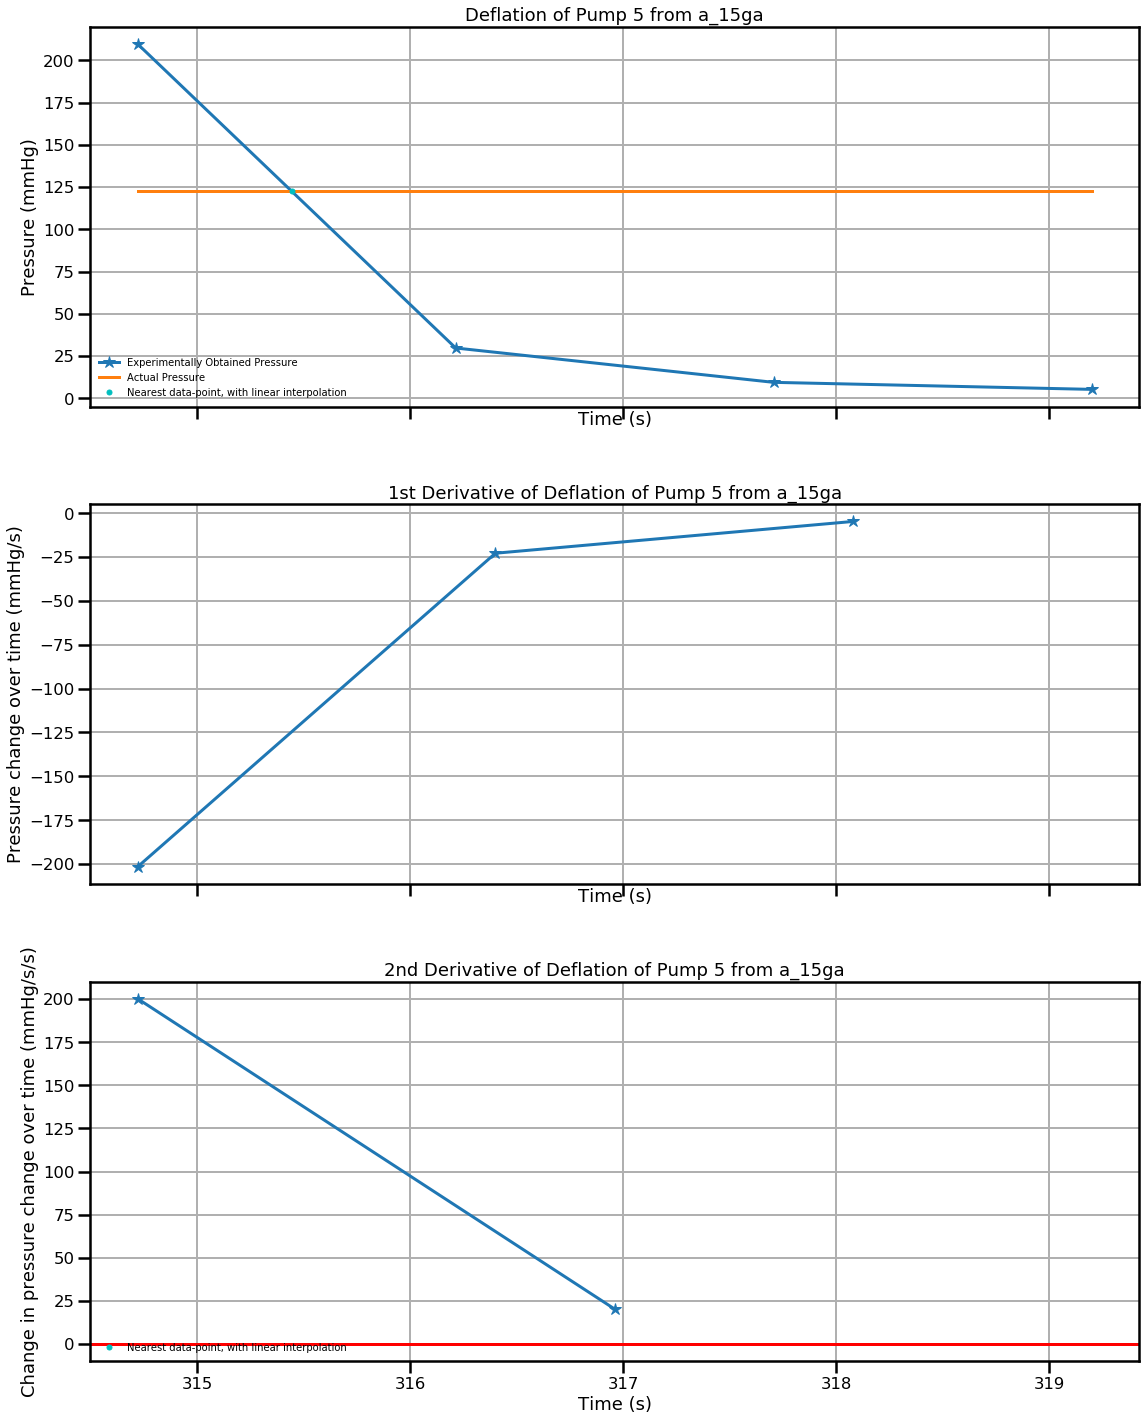

a_18ga
pump_1


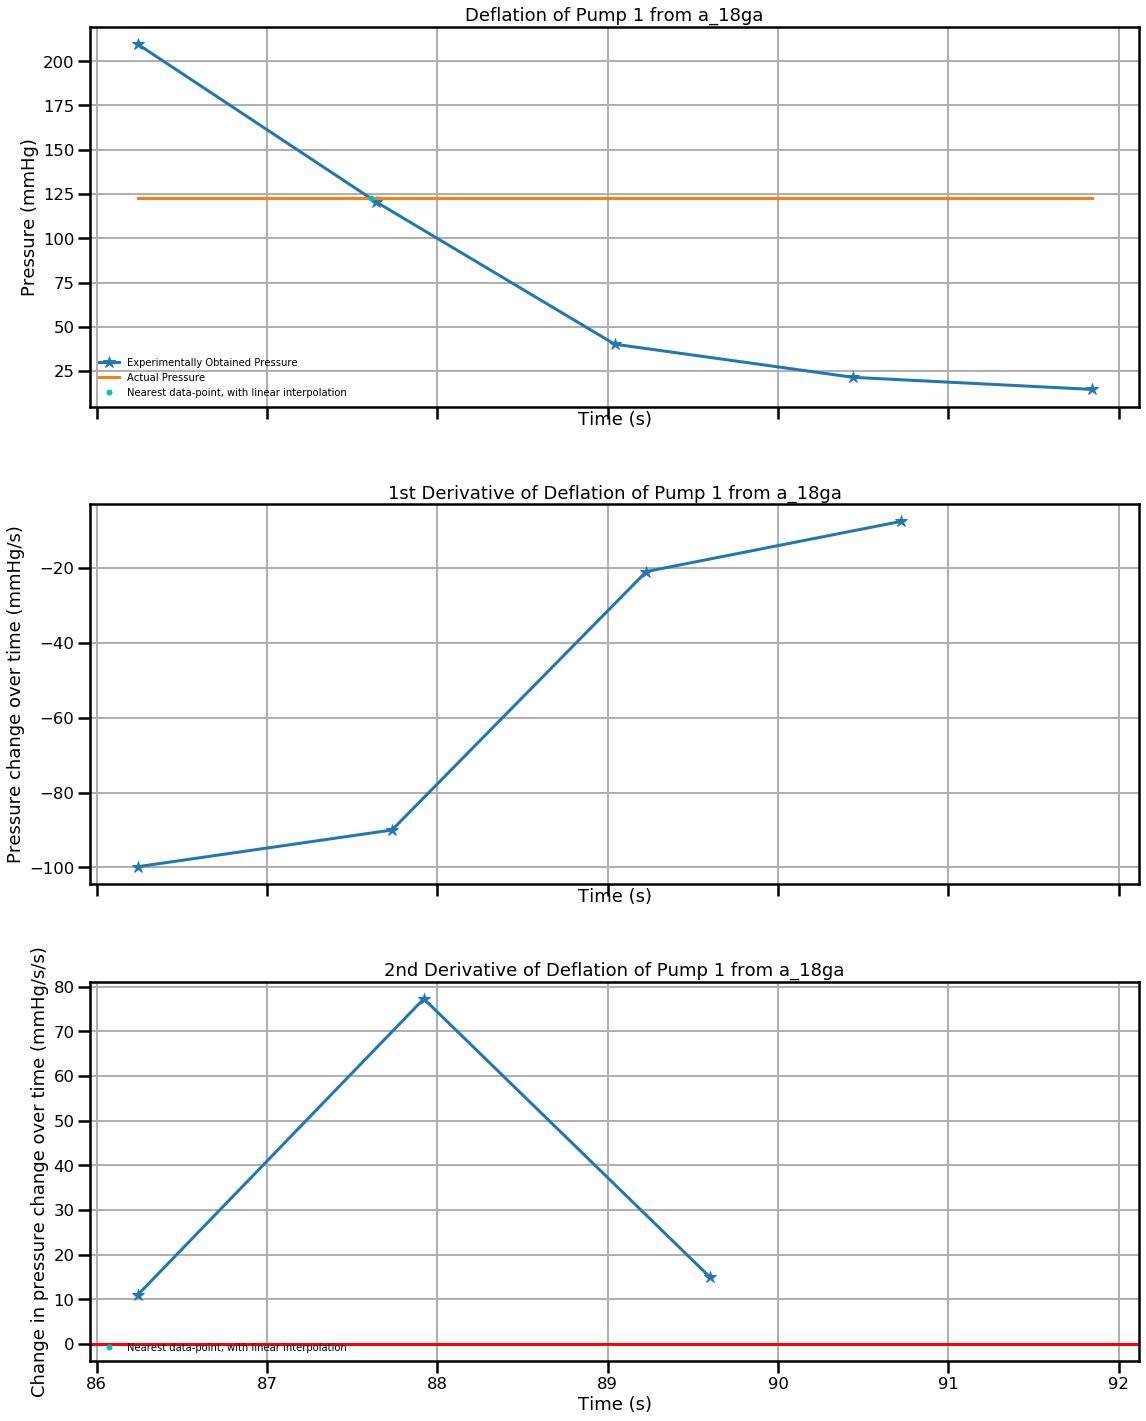

pump_2


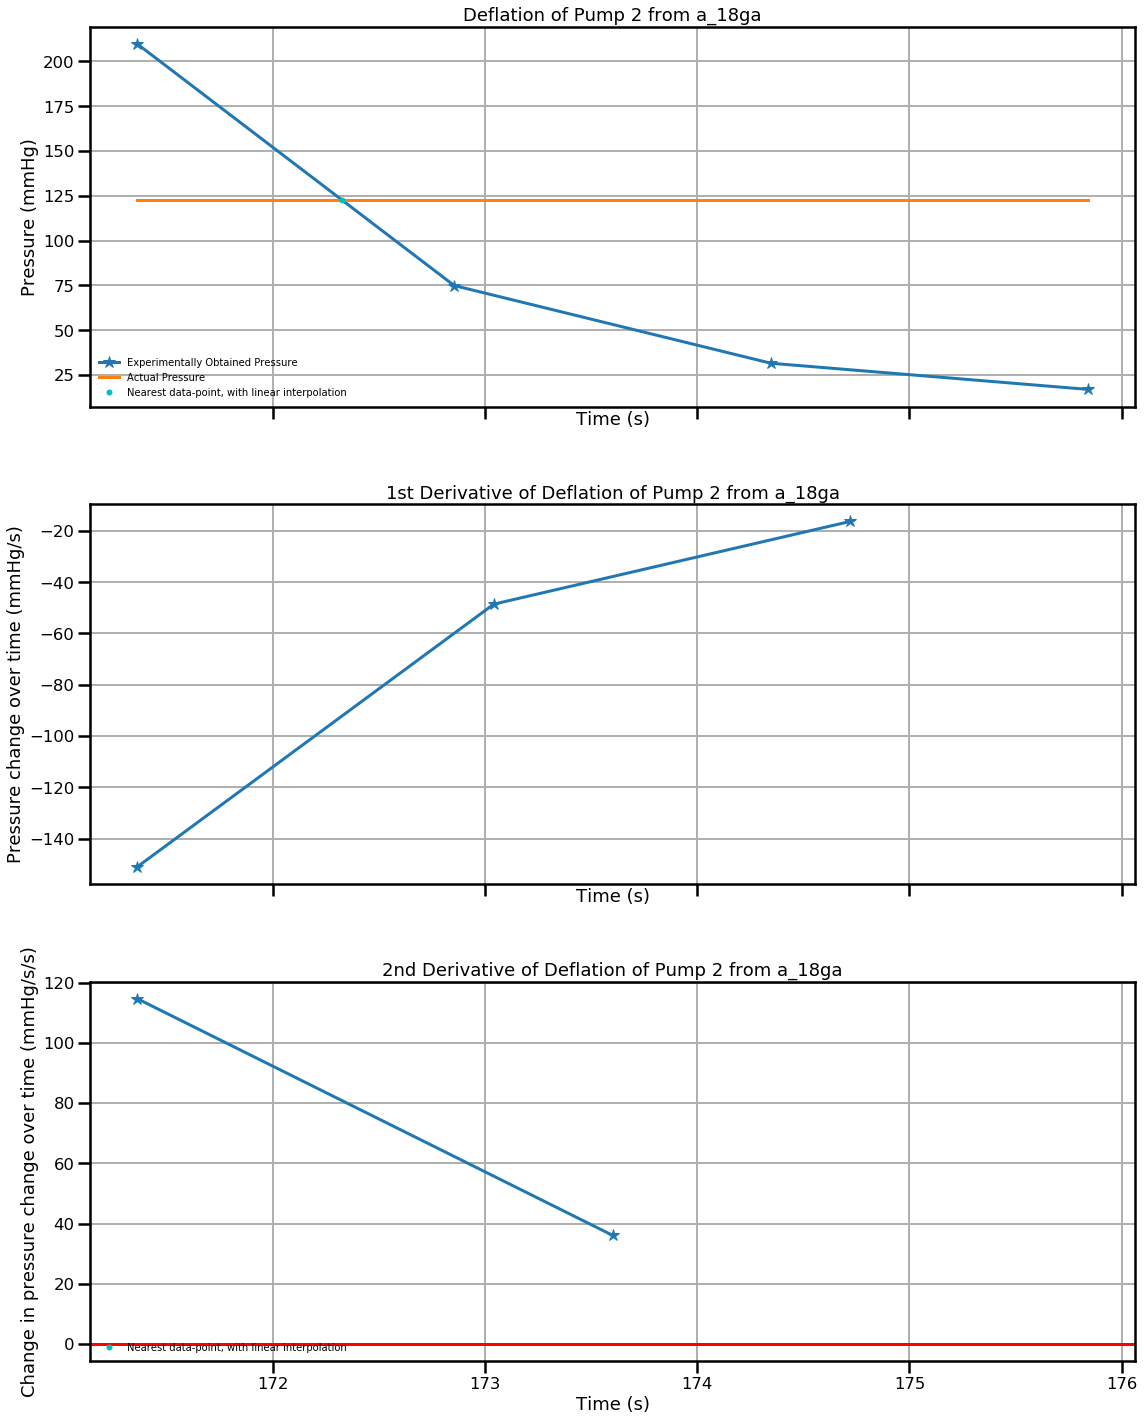

pump_3


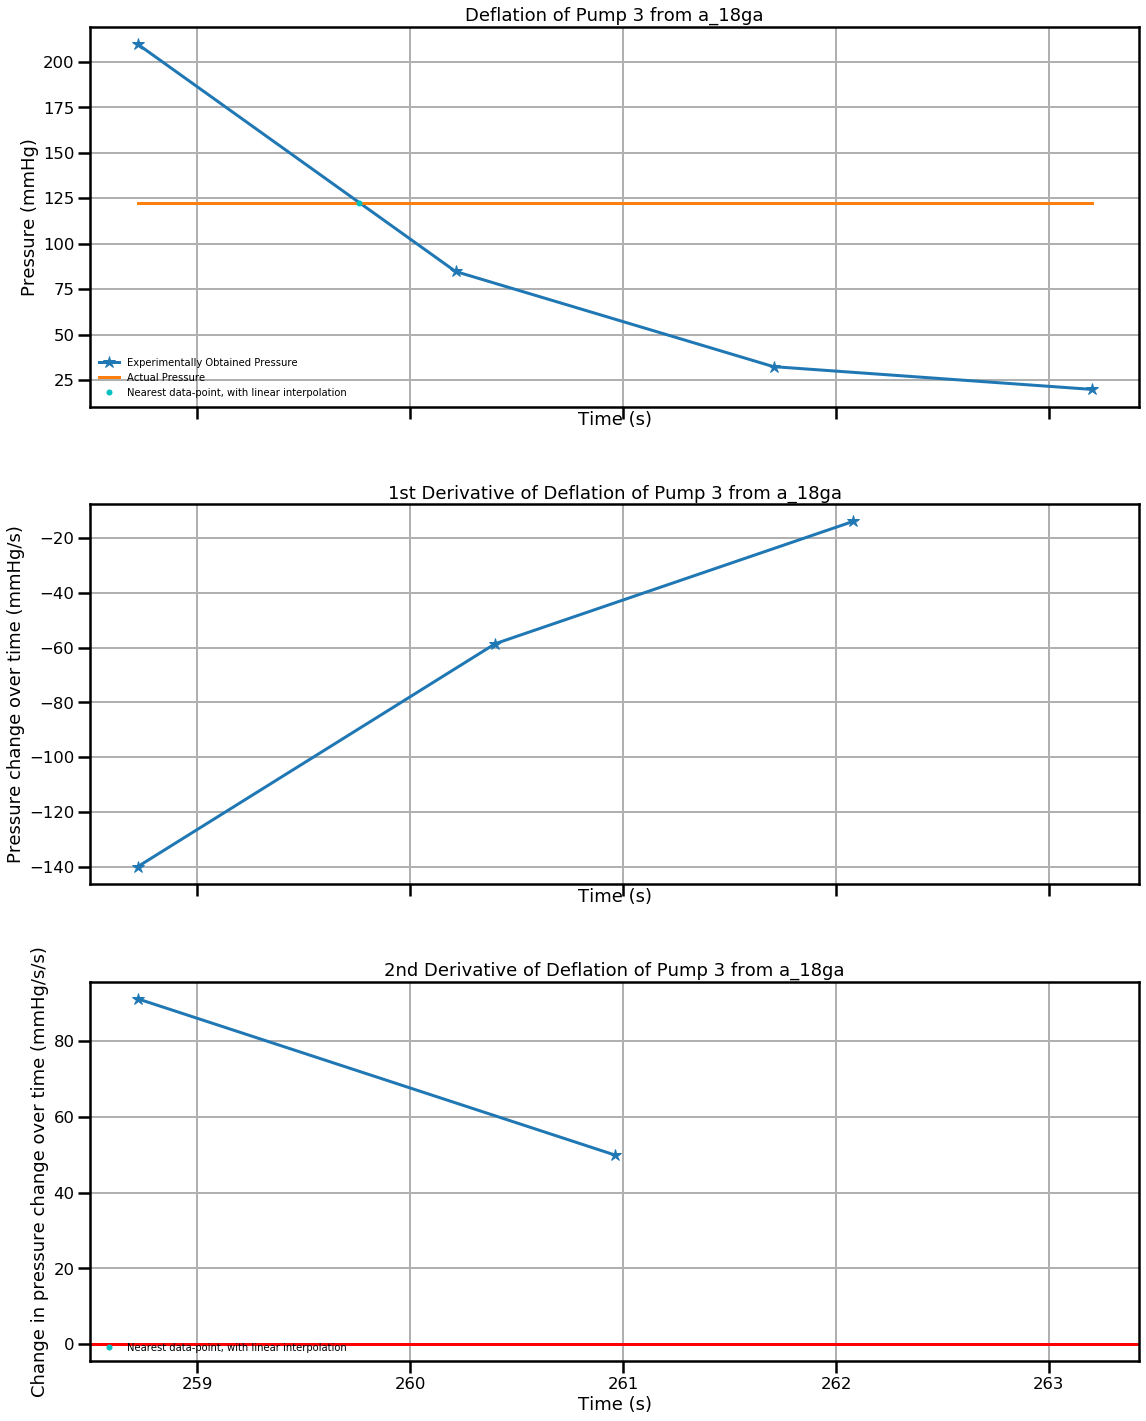

a_20ga
pump_1


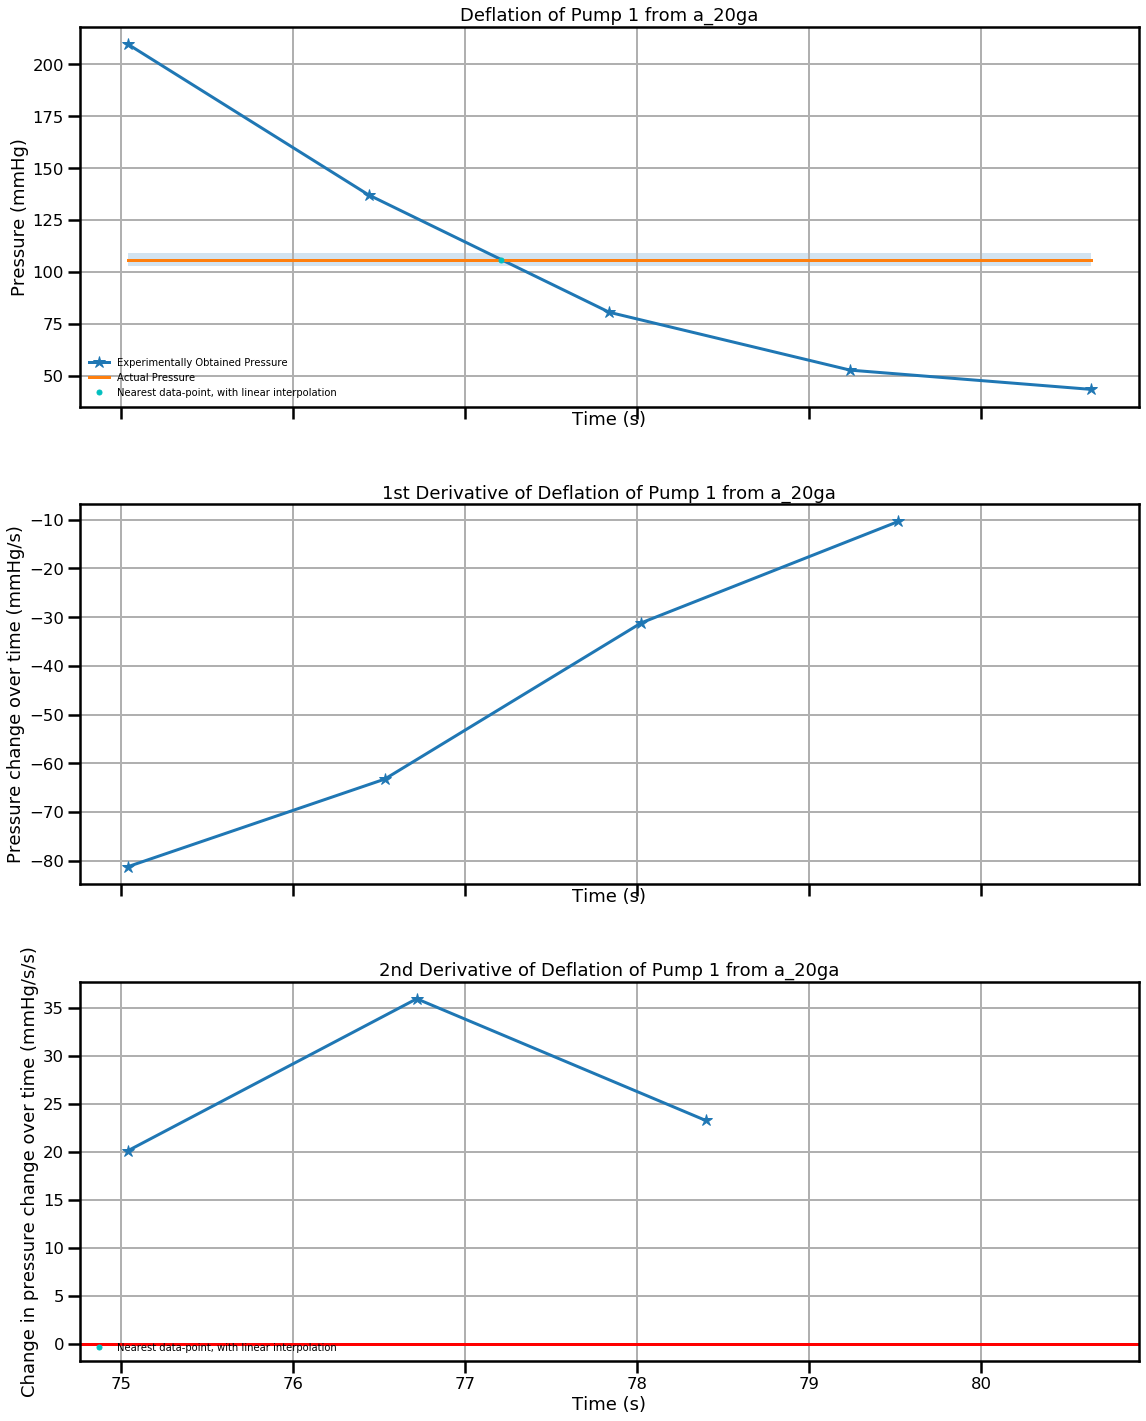

pump_2


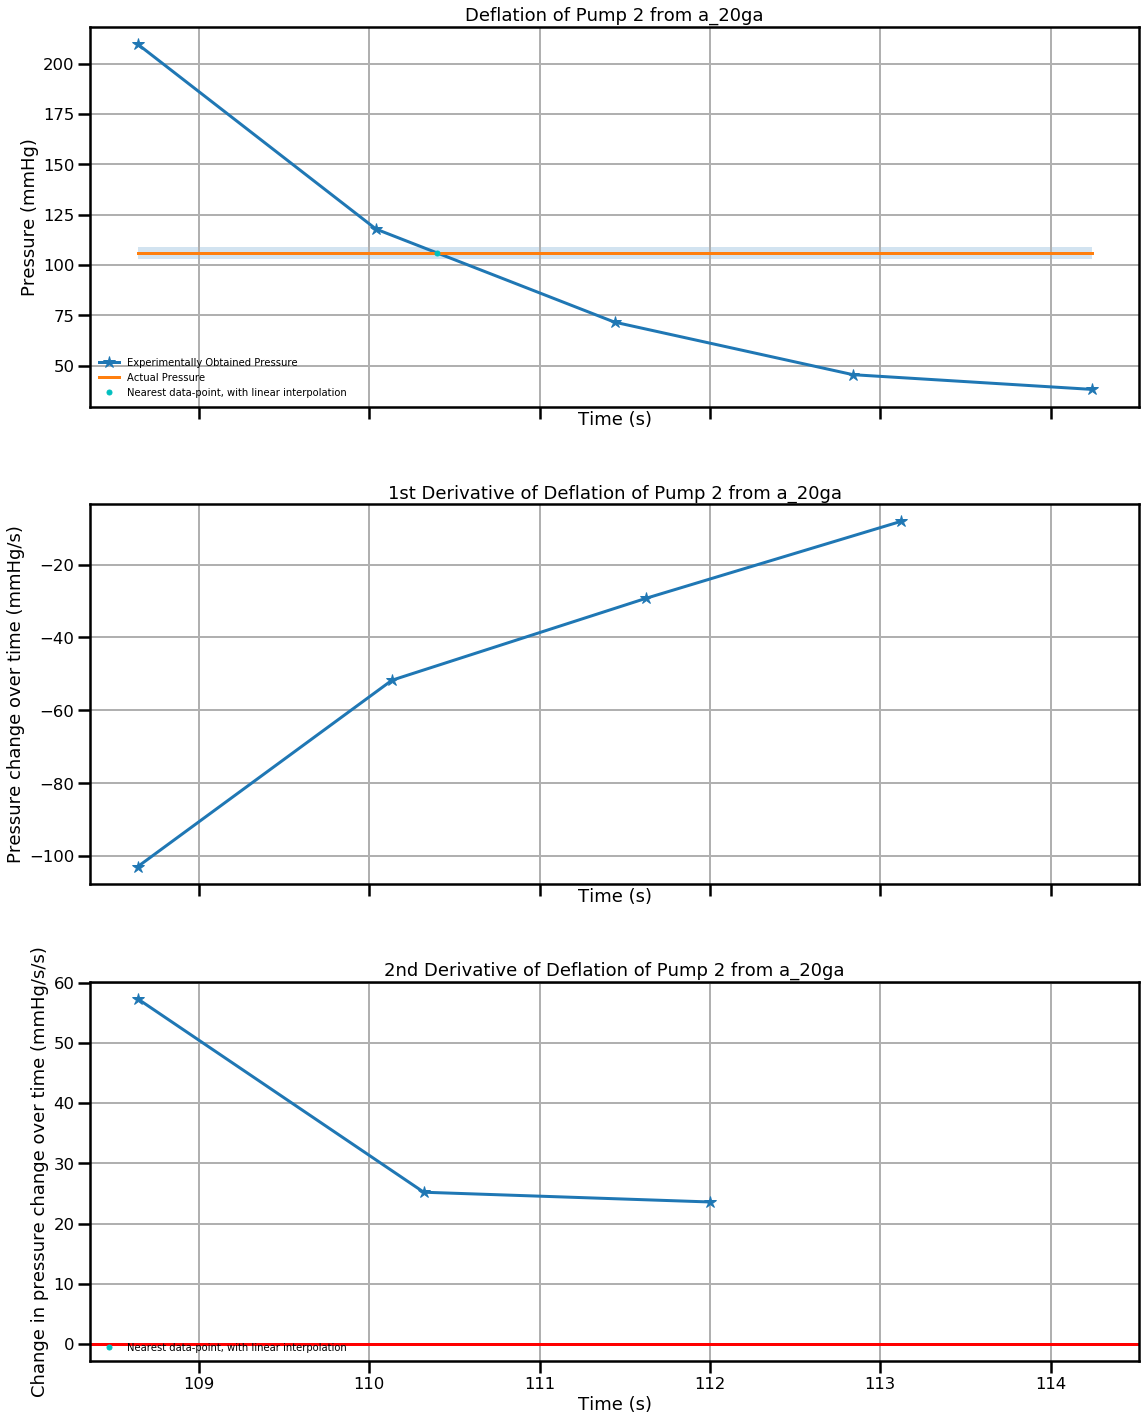

pump_3


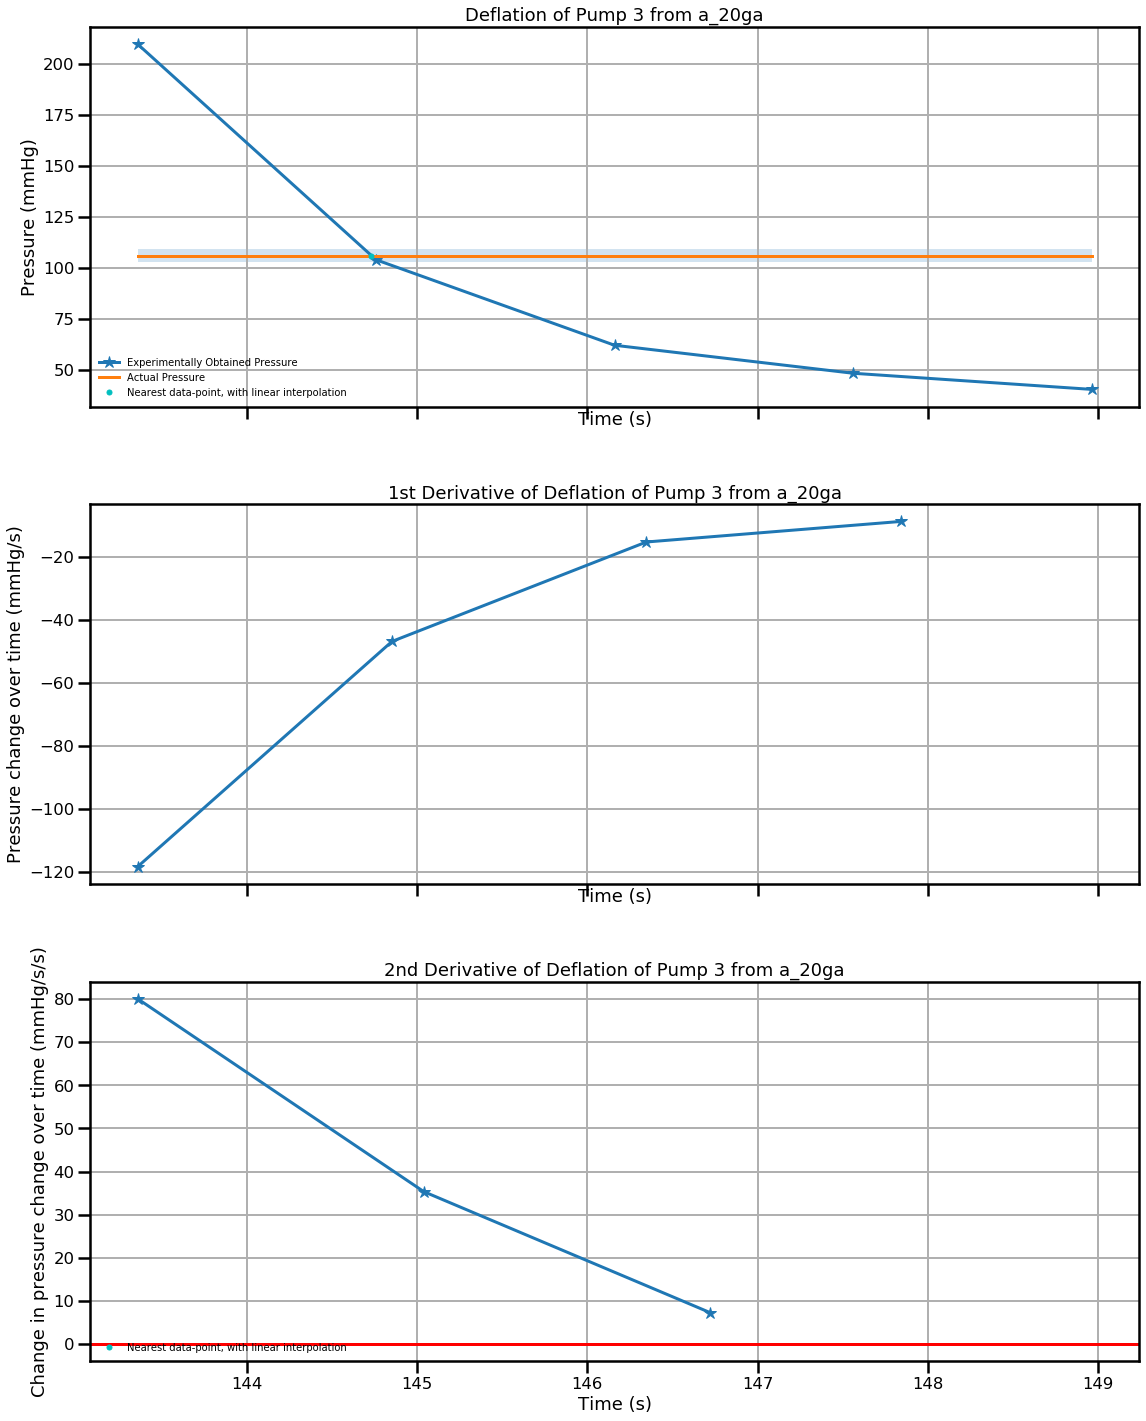

pump_4
[[260.72508565]]
There is only one intercept


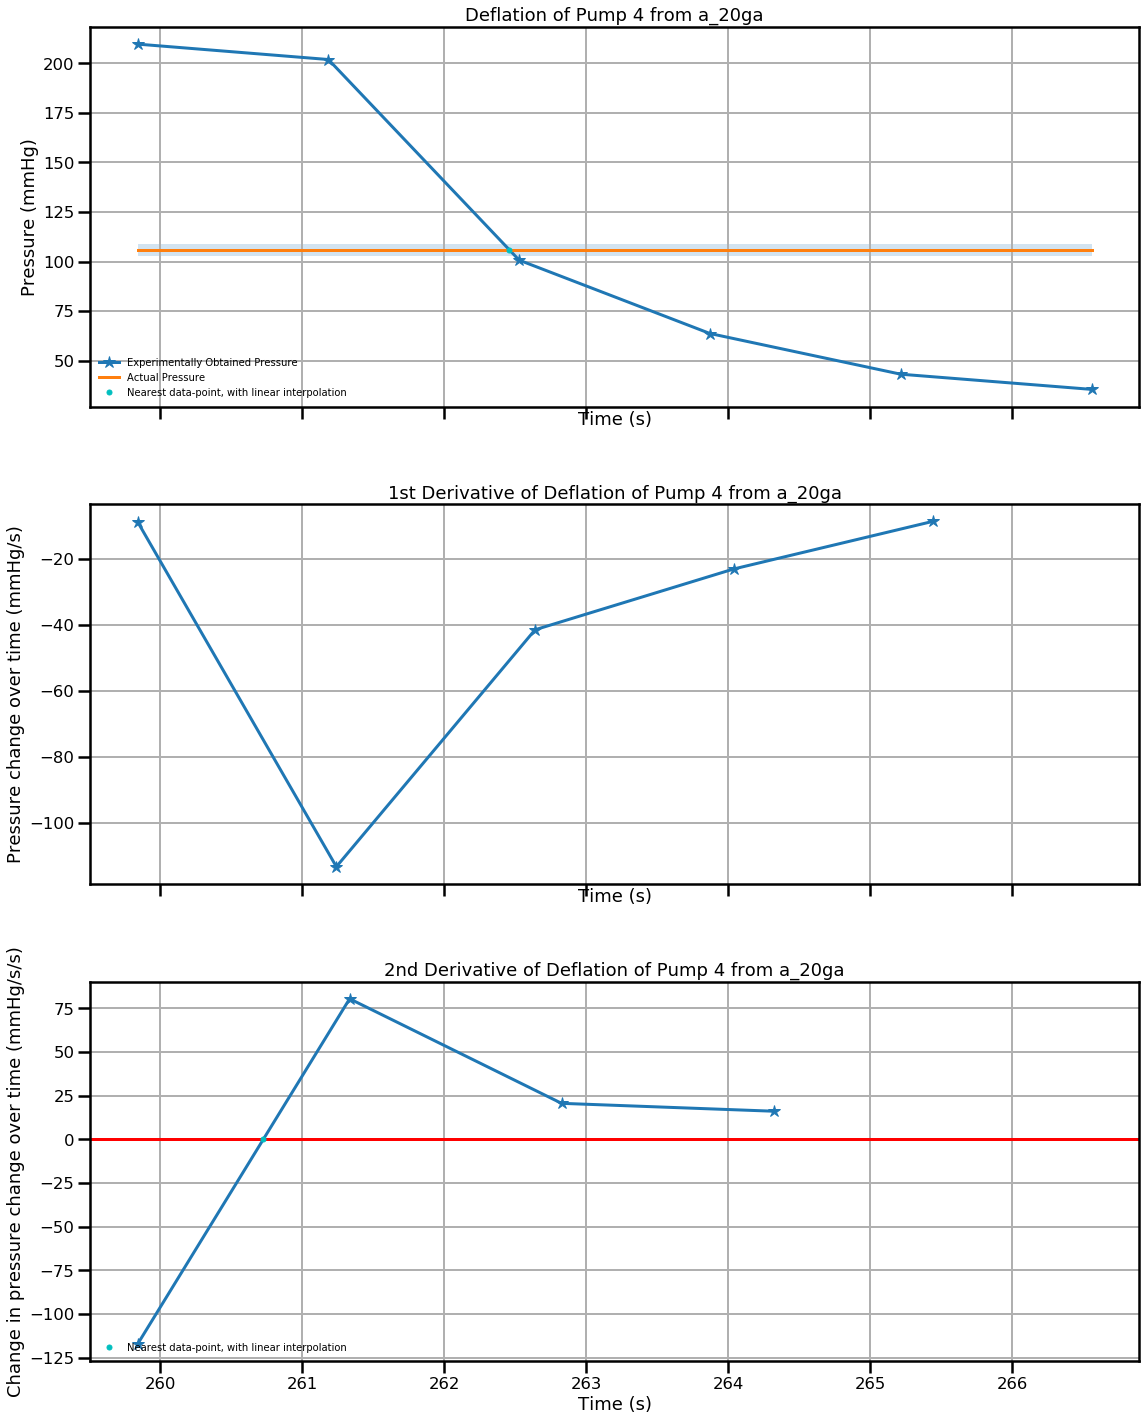

a_21ga
pump_1


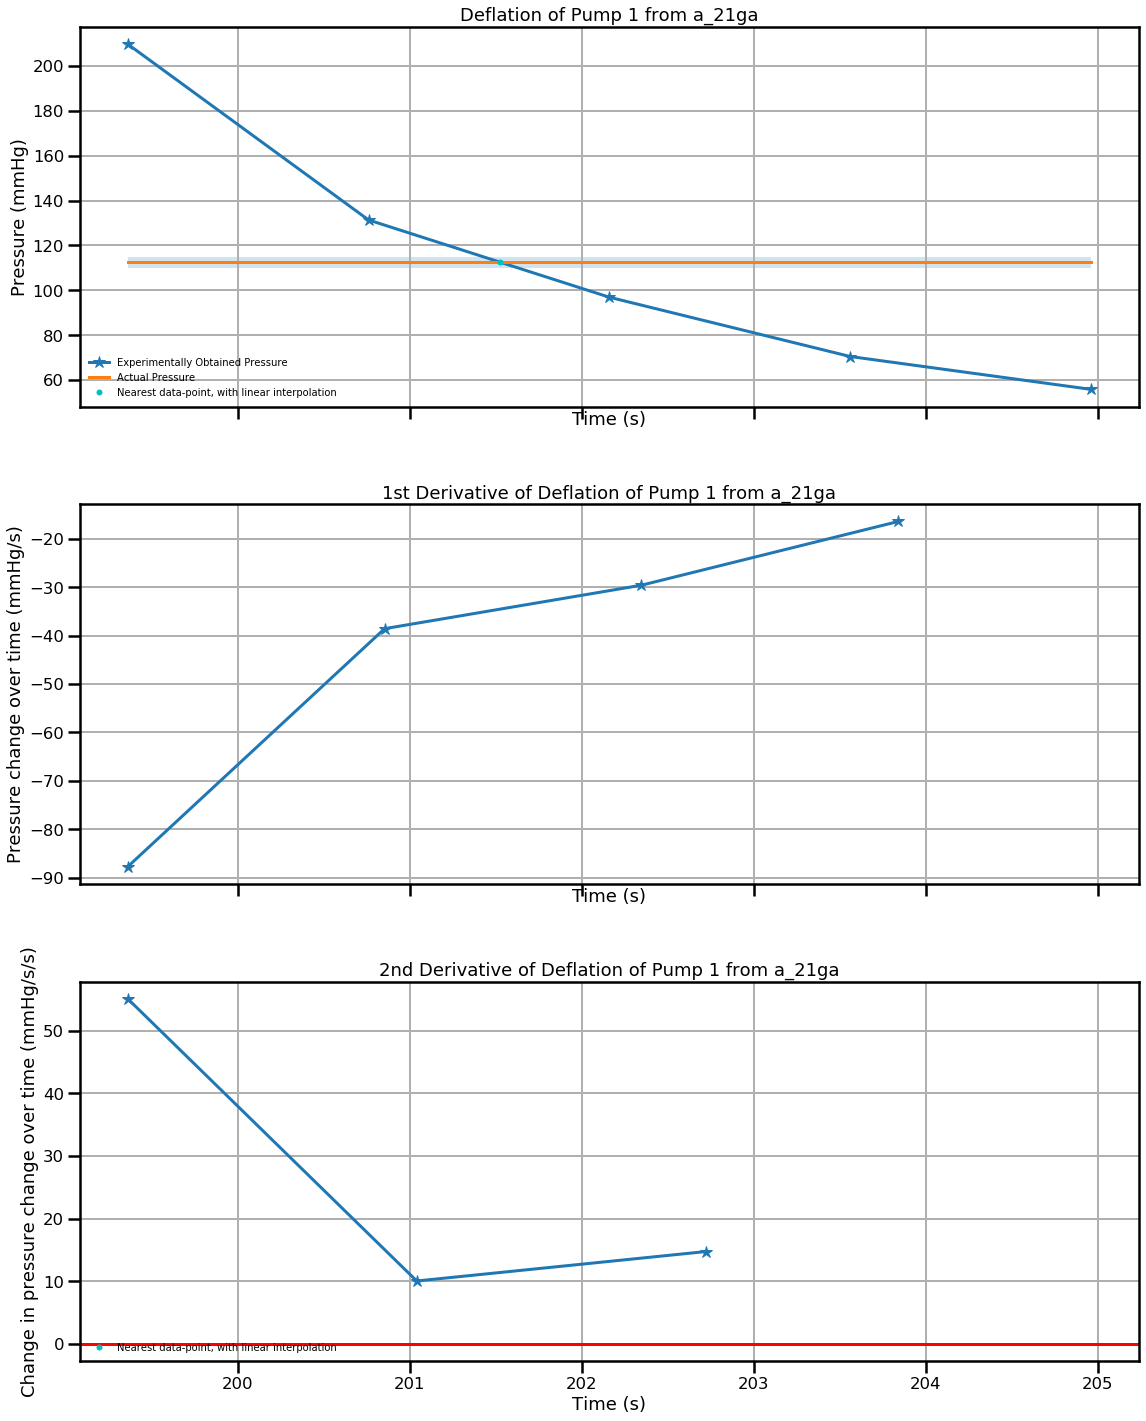

pump_2
[[233.80553288]]
There is only one intercept


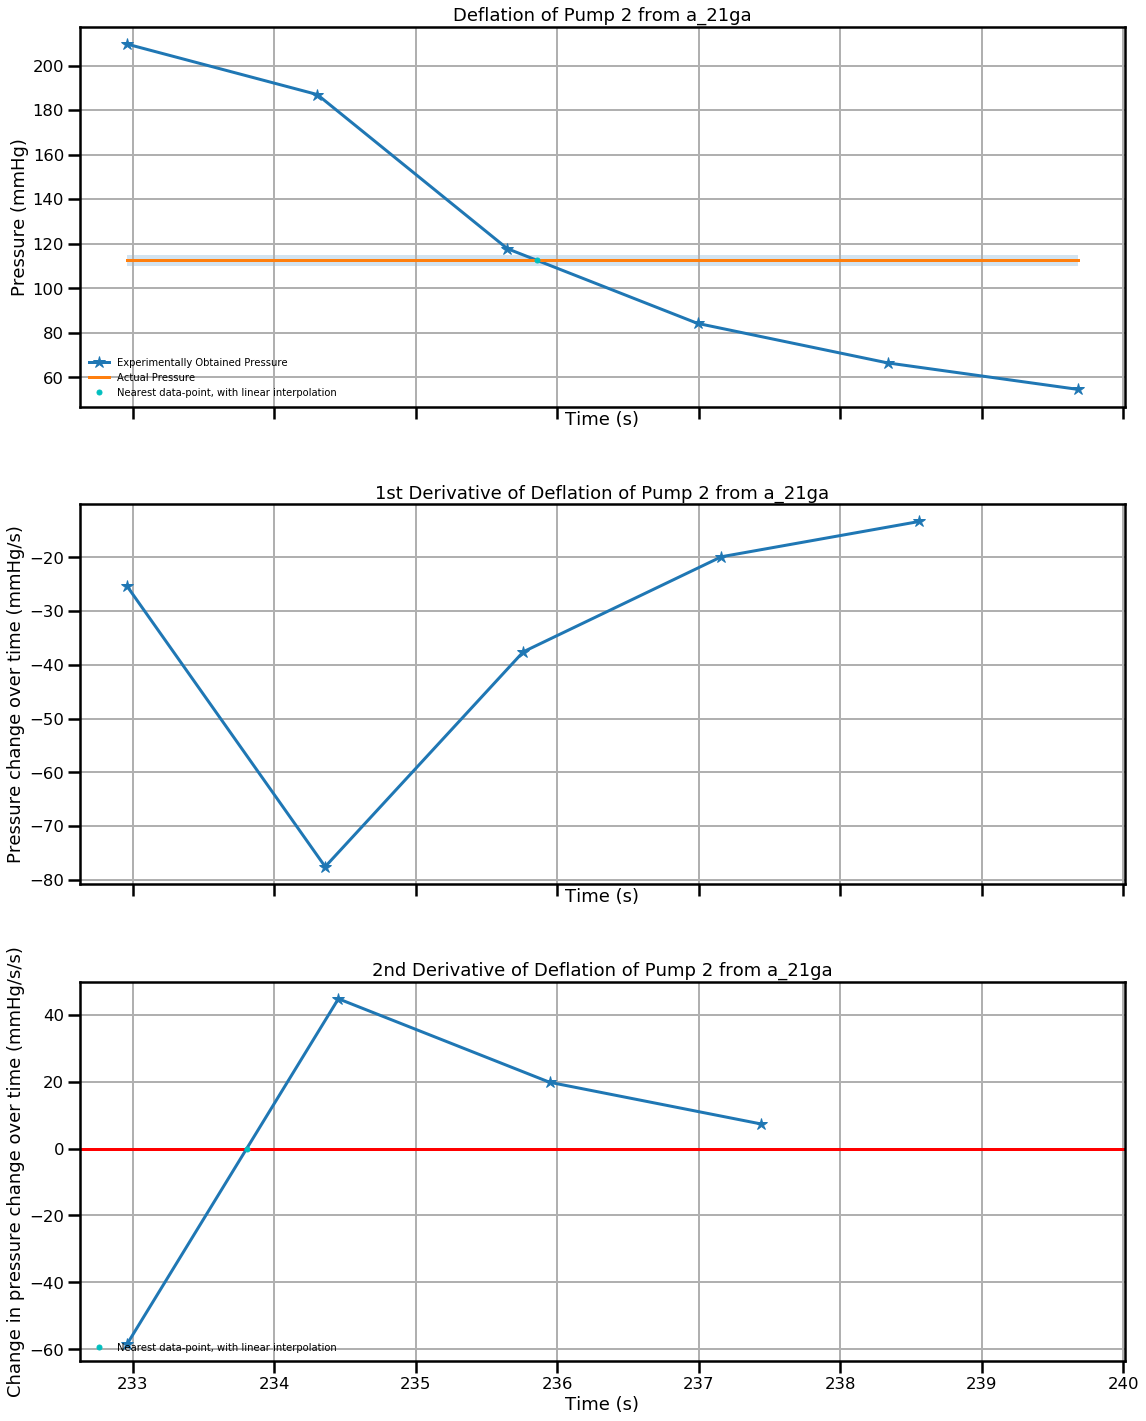

pump_3
[[276.22112094]]
There is only one intercept


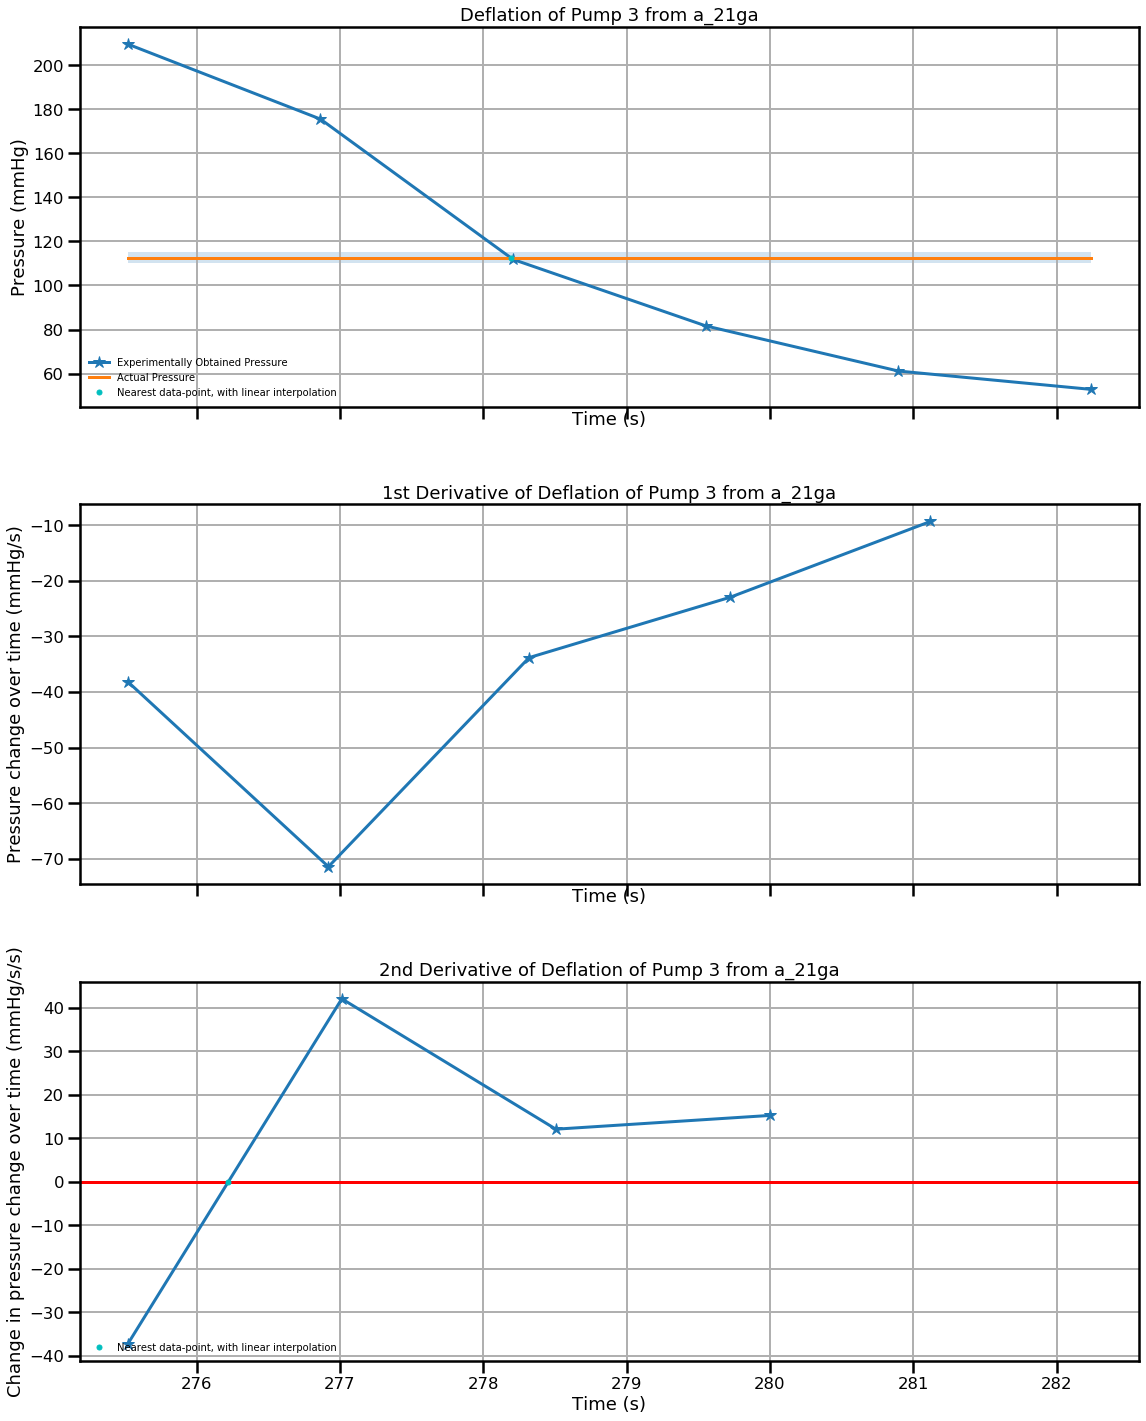

a_22ga
pump_1
[[33.37505451]]
There is only one intercept


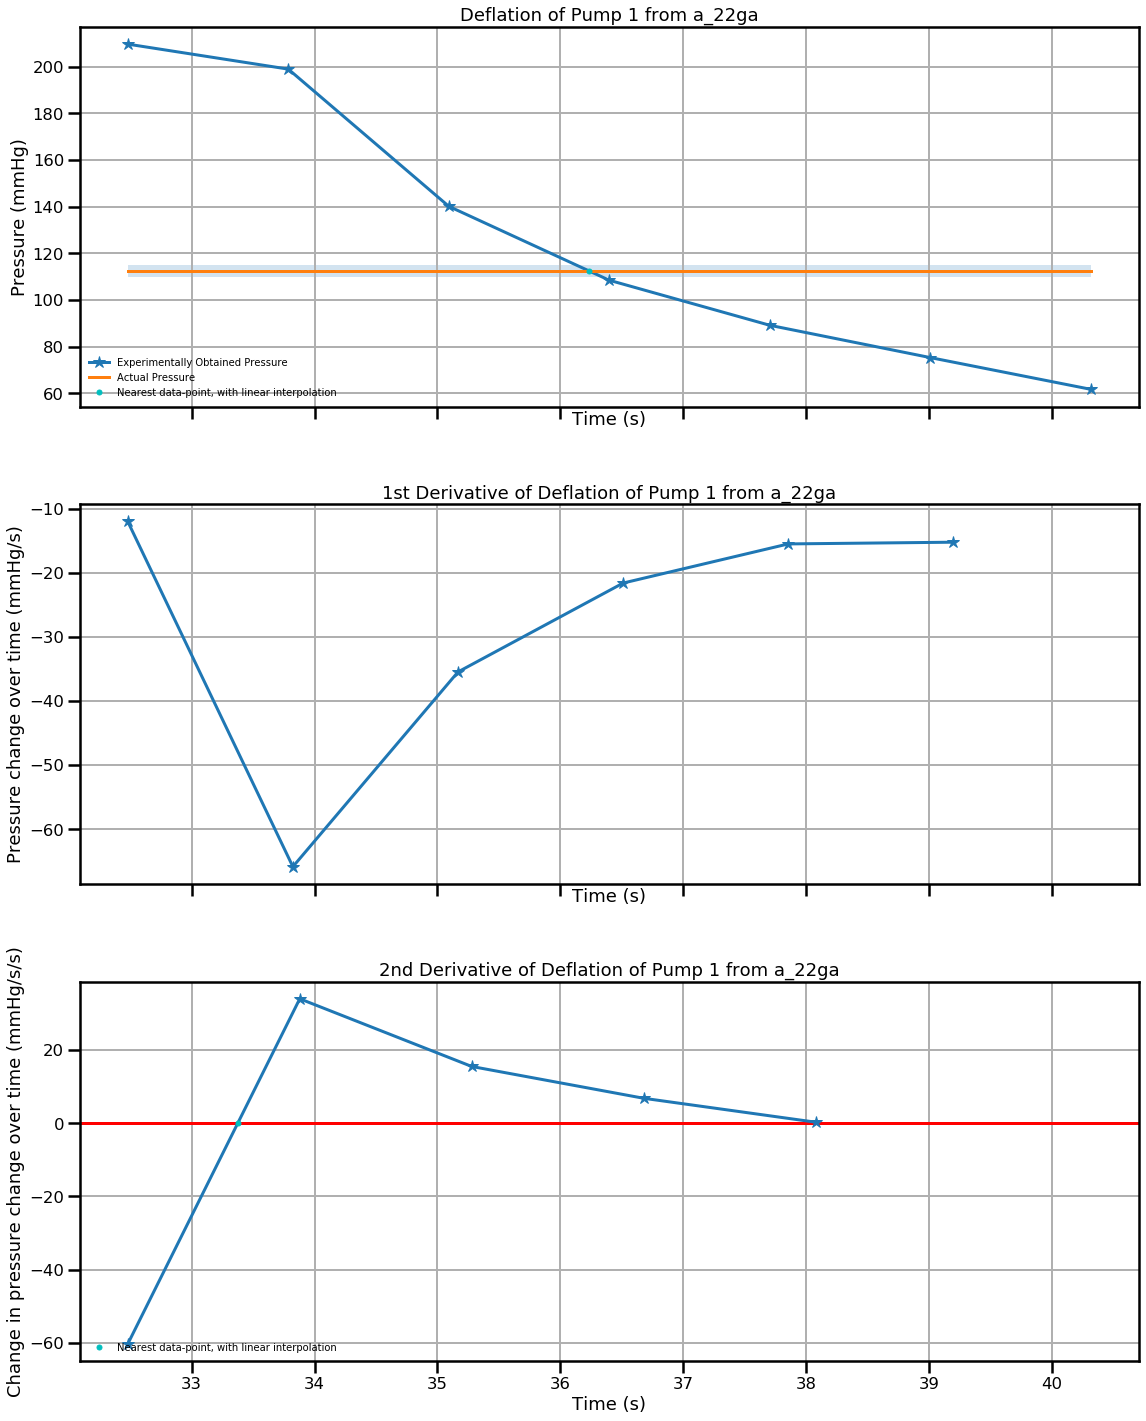

pump_2


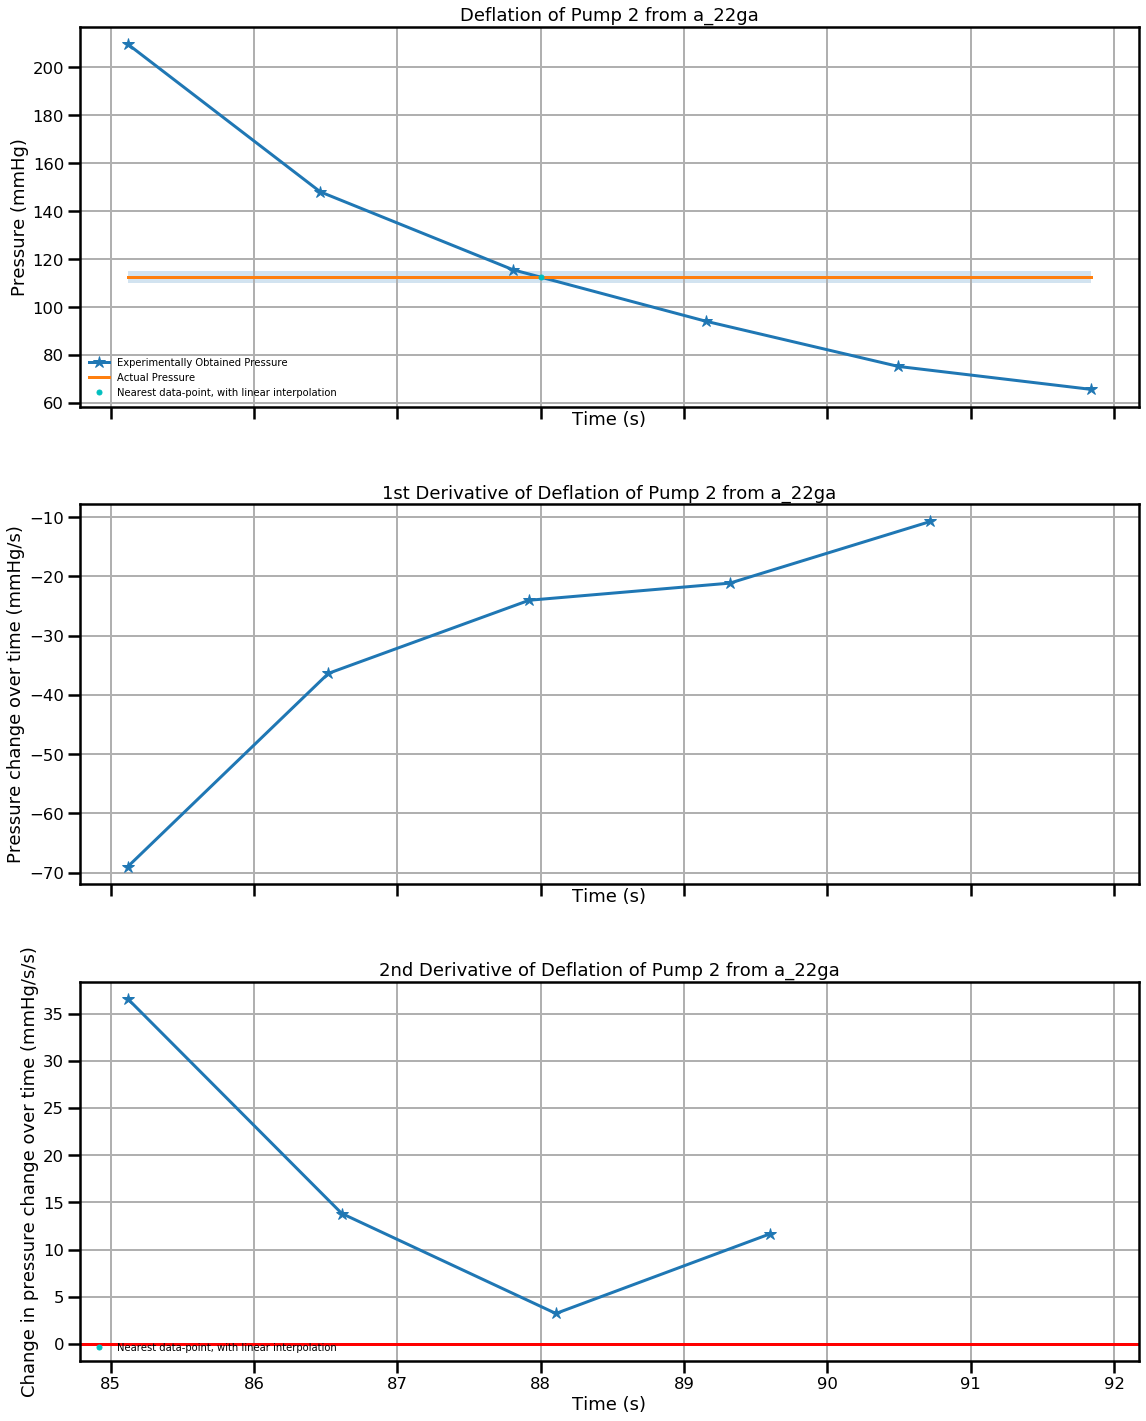

pump_3
[[123.87286315]]
There is only one intercept


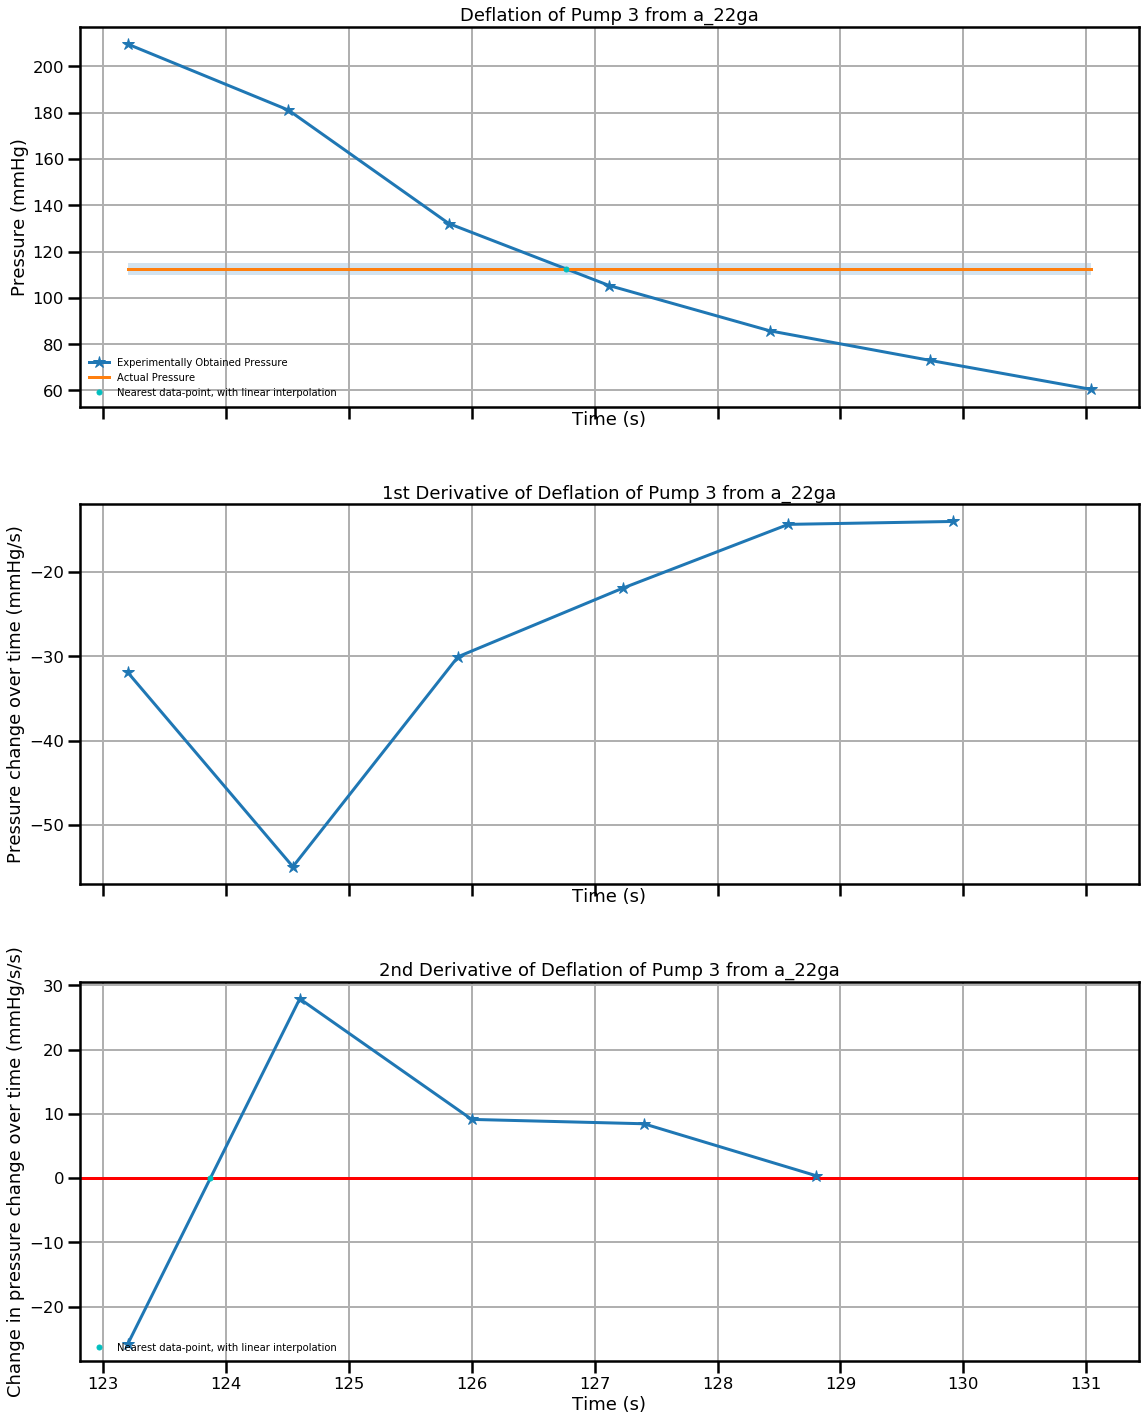

pump_4
[[165.10875215]
 [168.83072848]
 [168.85304348]]


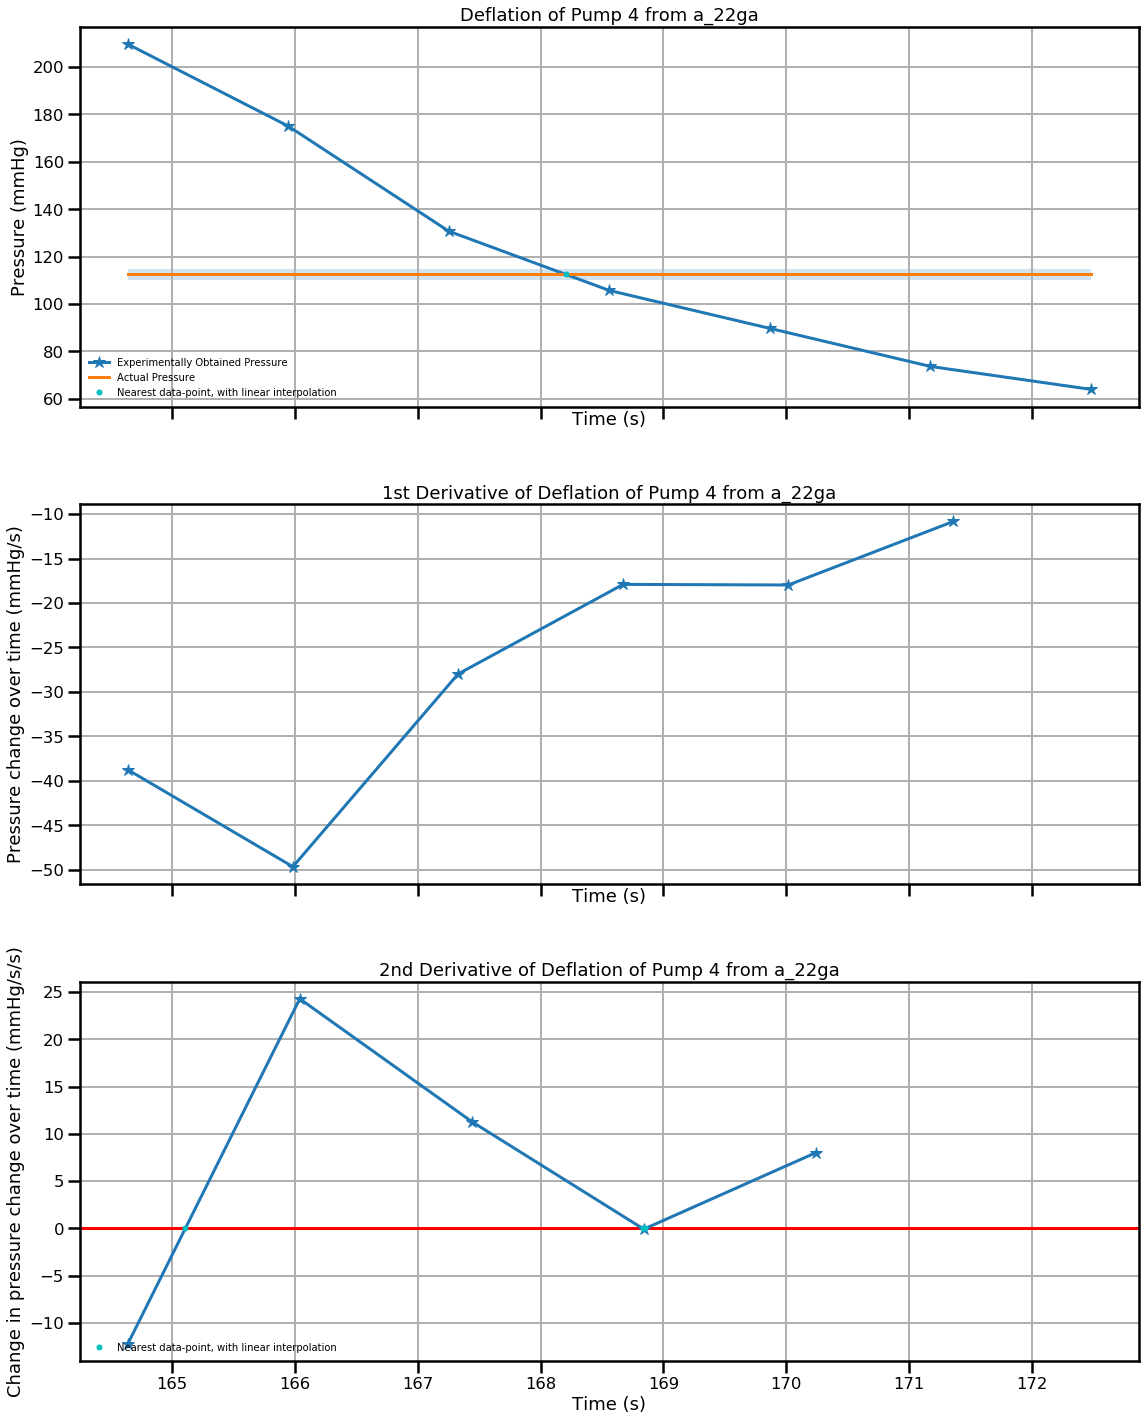

pump_5
[[211.39202027]]
There is only one intercept


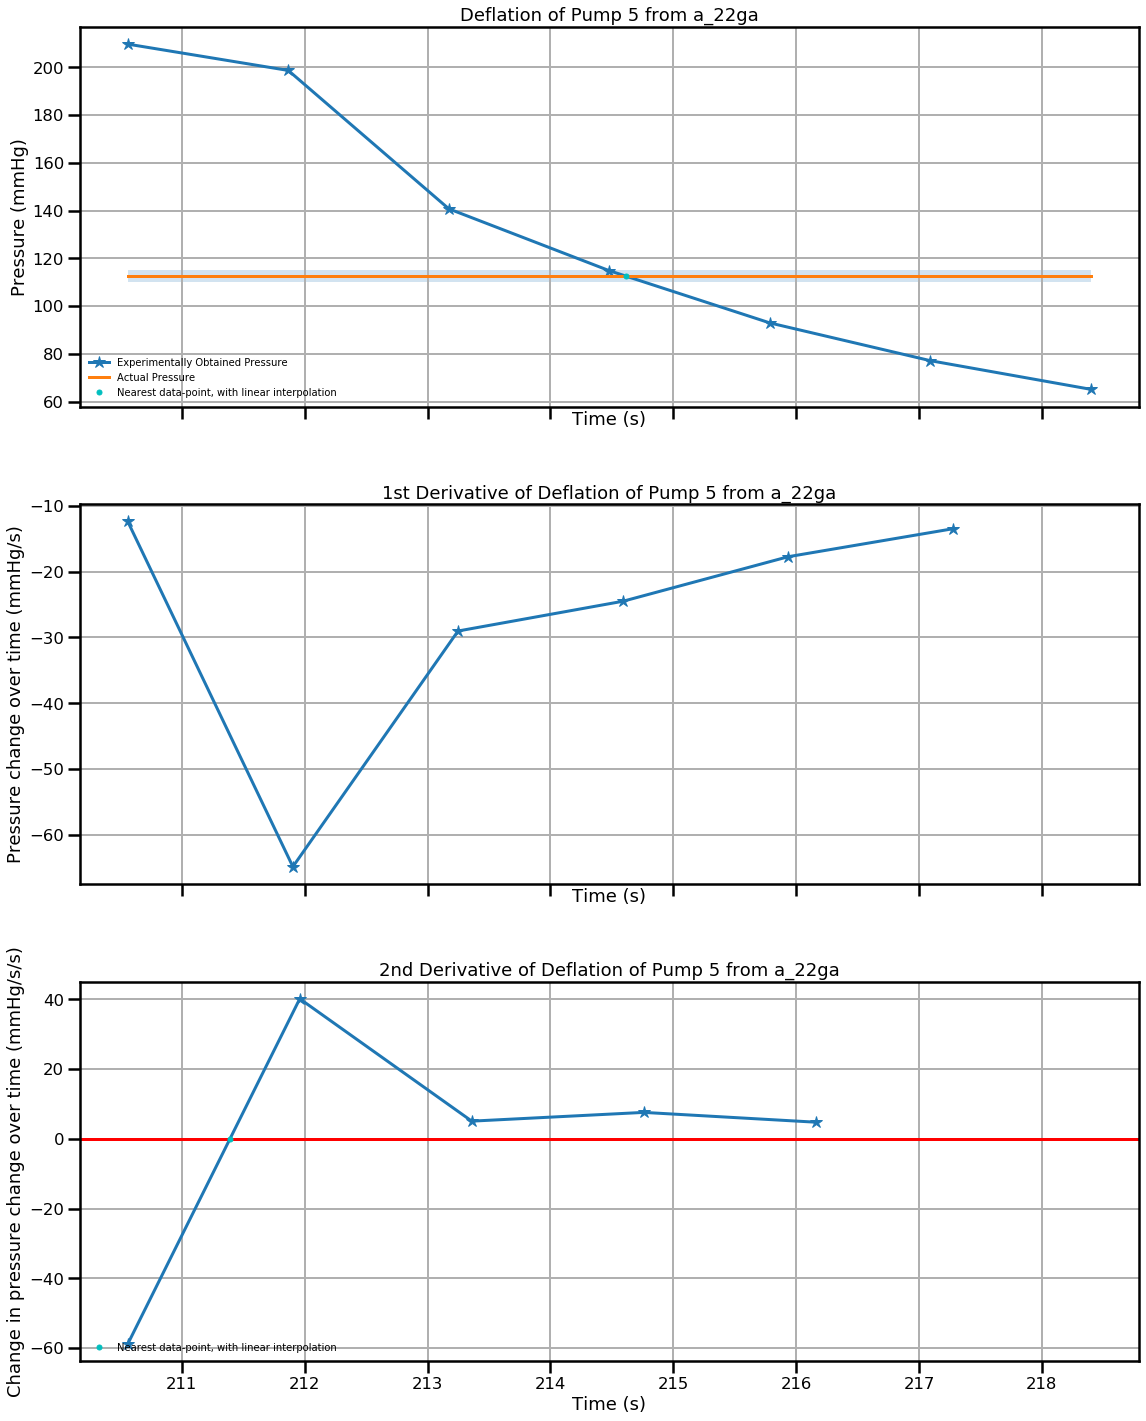

a_23ga
pump_1
[[376.00290807]
 [380.2395689 ]
 [381.50684444]]


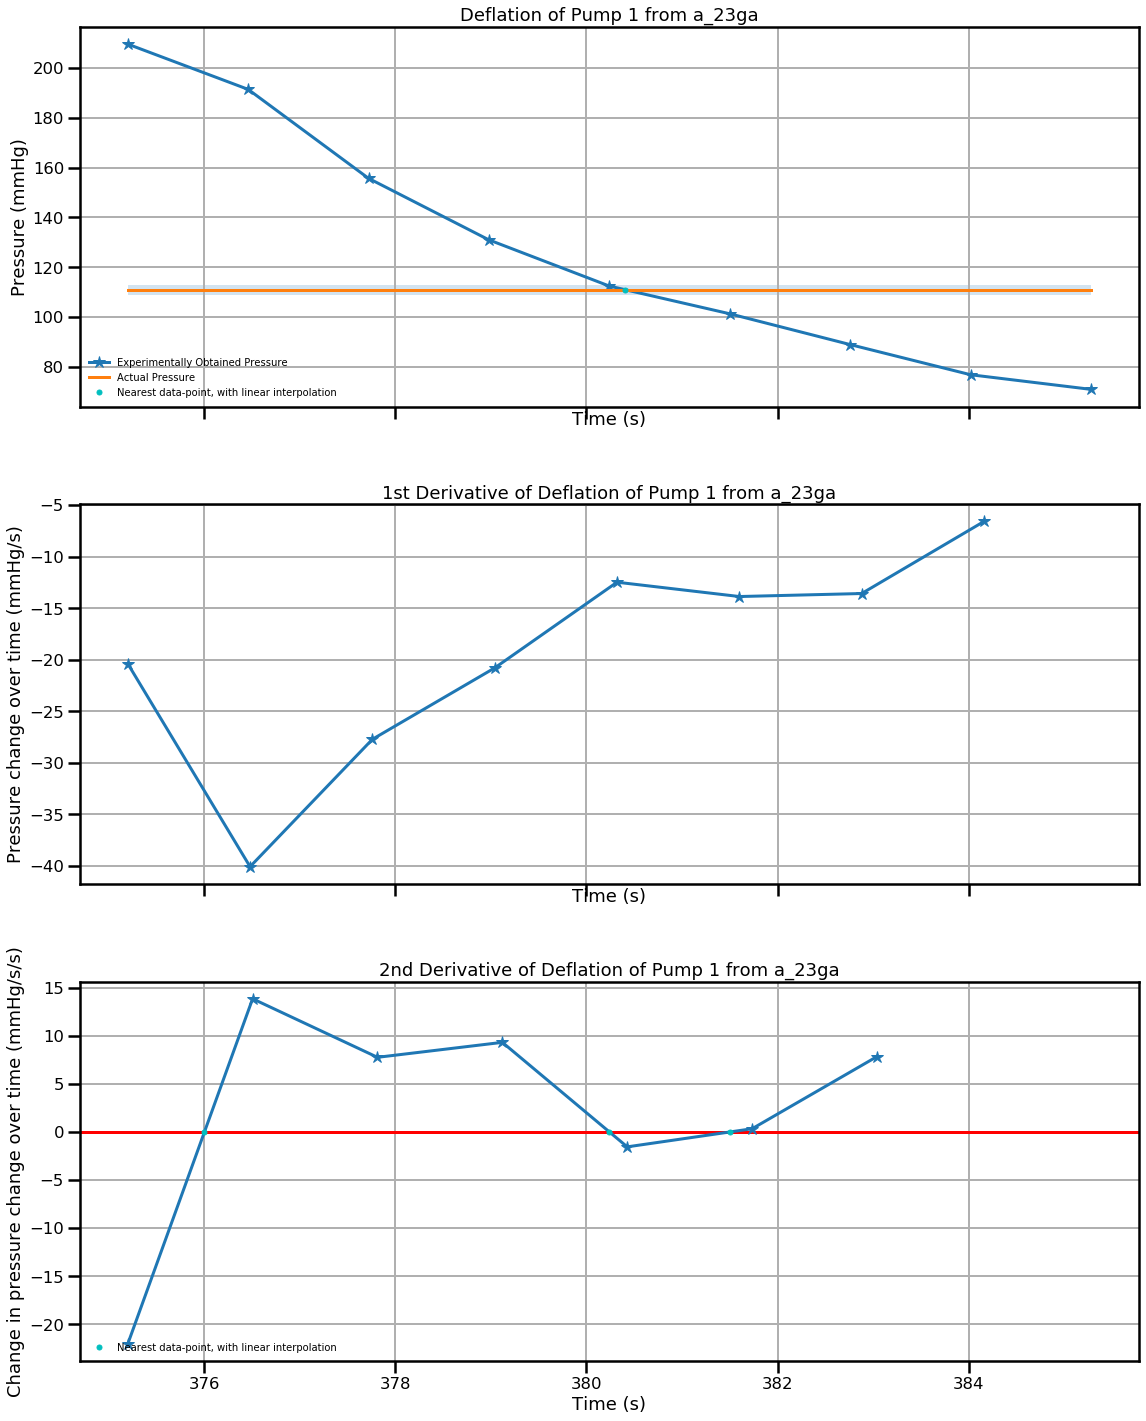

pump_2
[[434.29141854]
 [438.64277333]
 [438.95760218]]


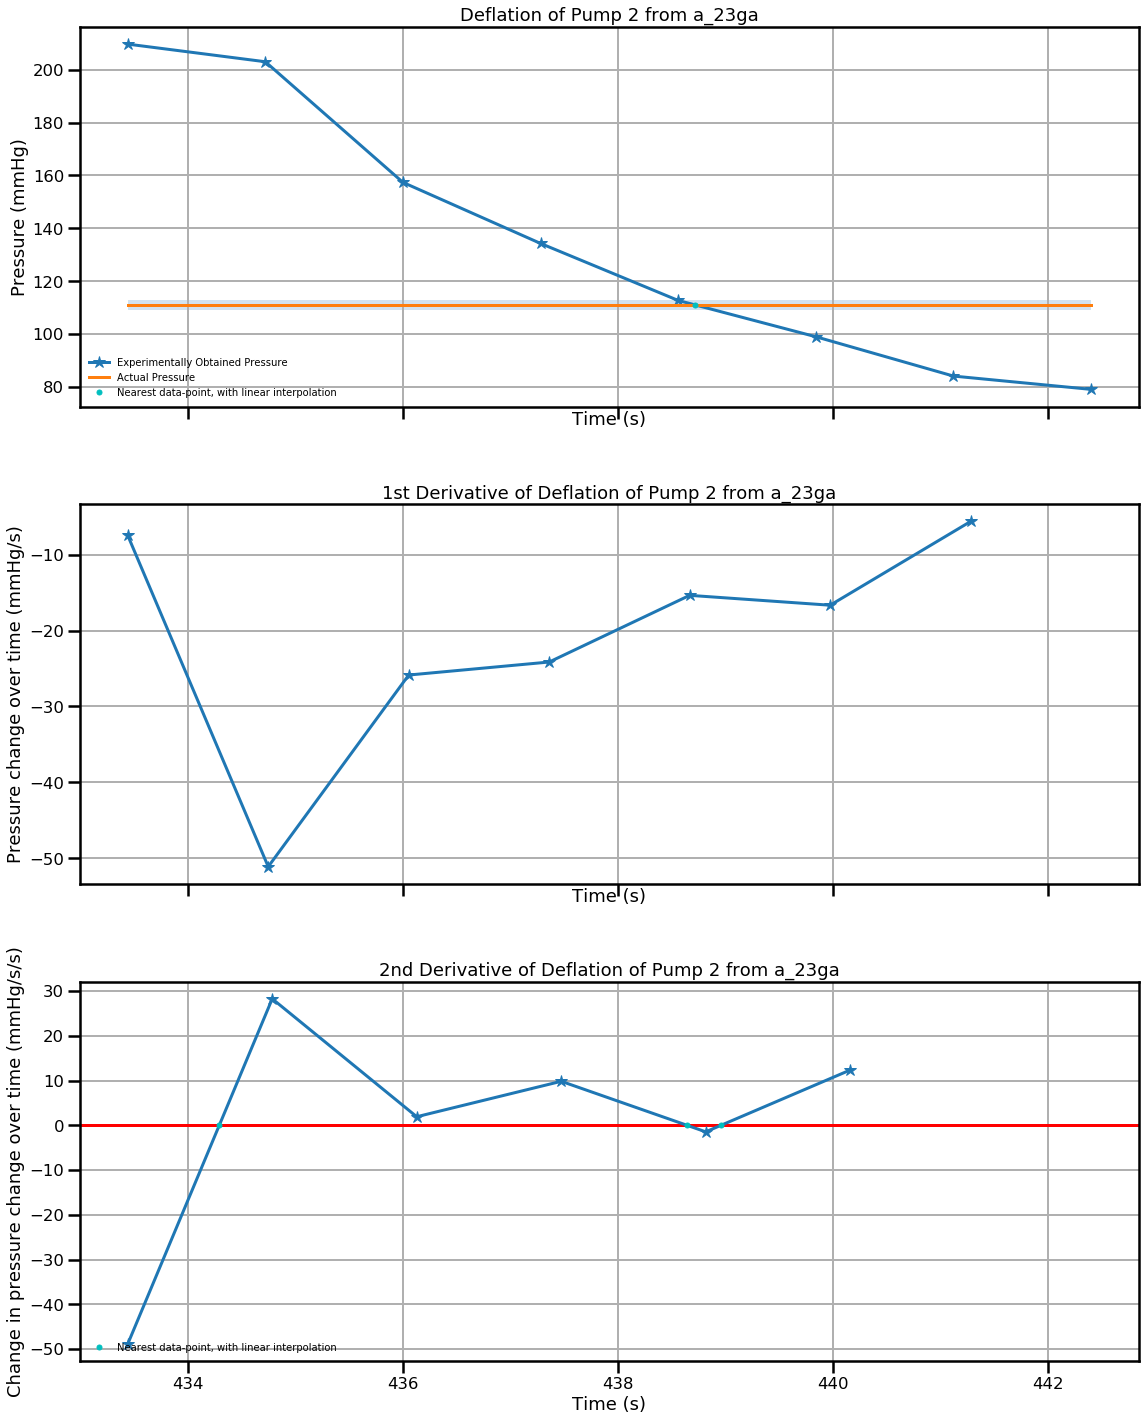

pump_3
[[508.15447856]
 [513.55375342]]


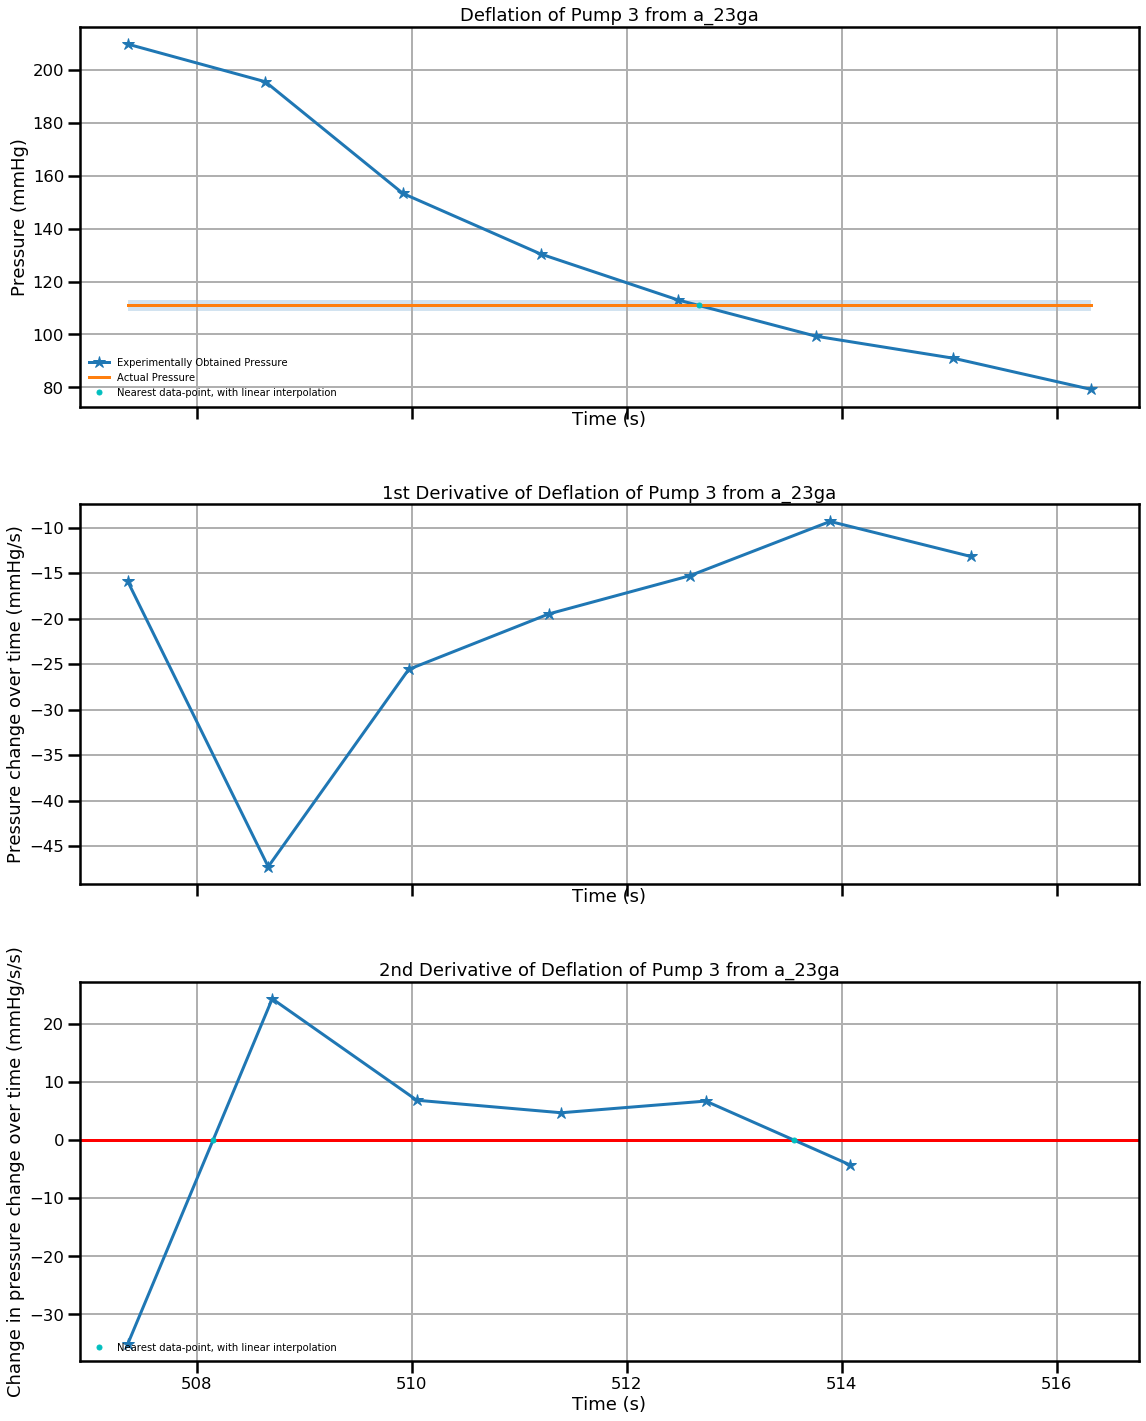

a_25ga
pump_1
[[261.89582524]
 [264.68471429]
 [264.97253219]
 [268.17278794]
 [269.62465753]]


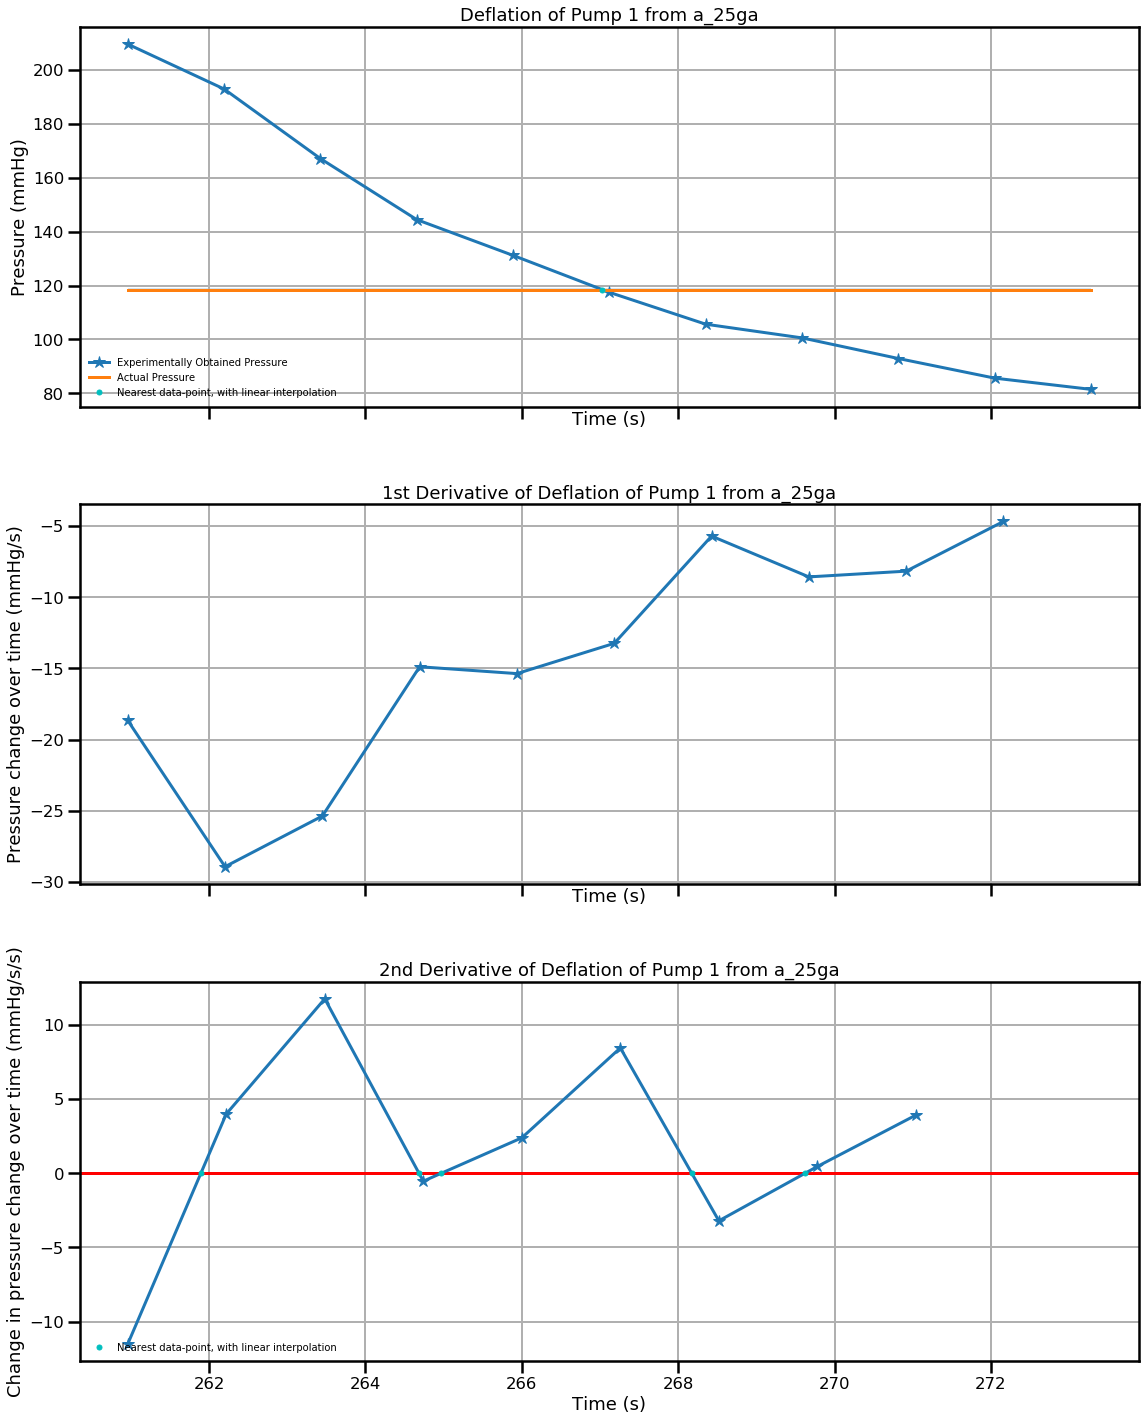

pump_2
[[591.90573112]
 [599.94229508]]


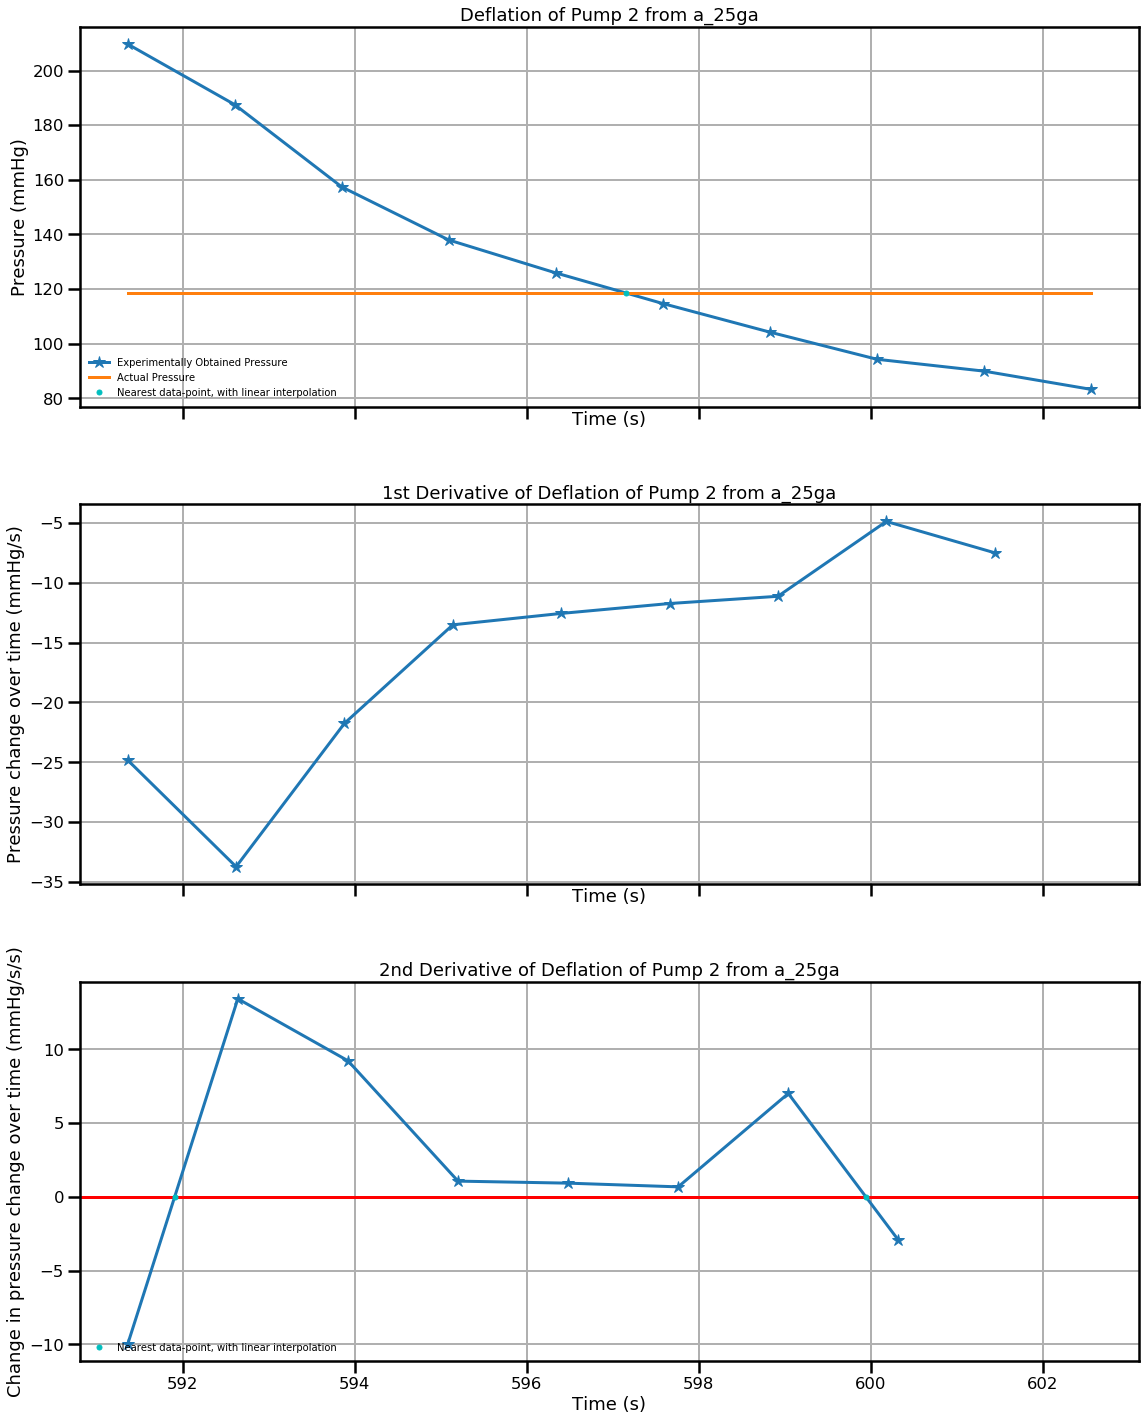

pump_3
[[655.43578947]
 [655.96118343]]


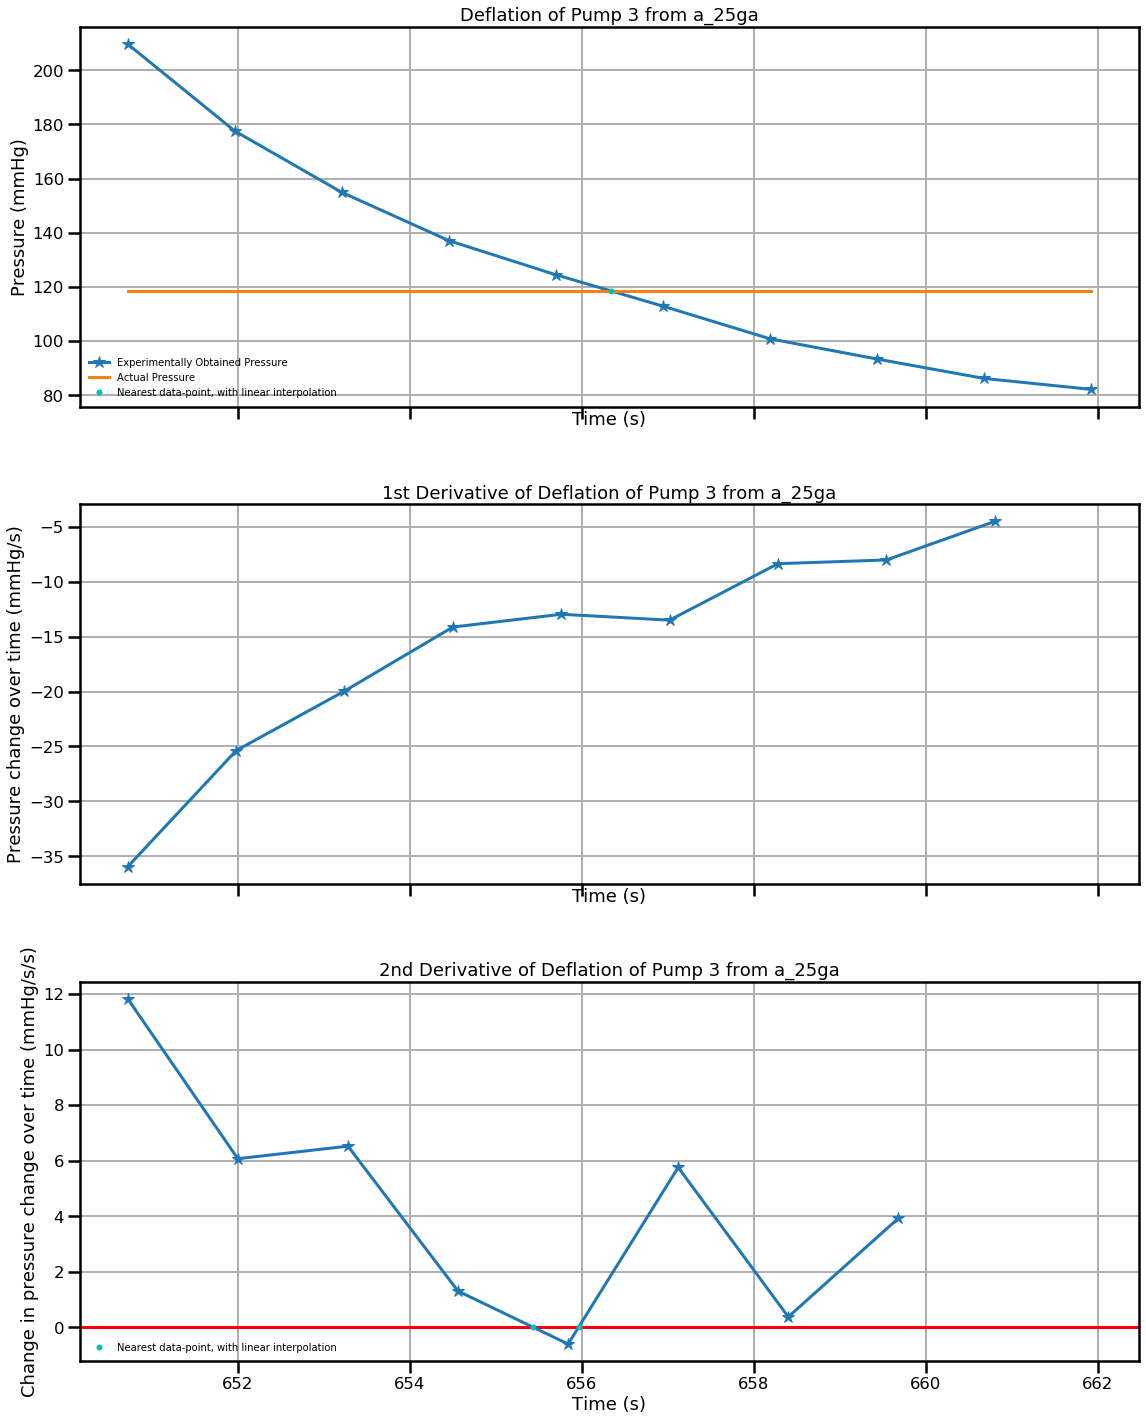

c_23ga
pump_1
[[27.06506208]
 [28.55338061]]


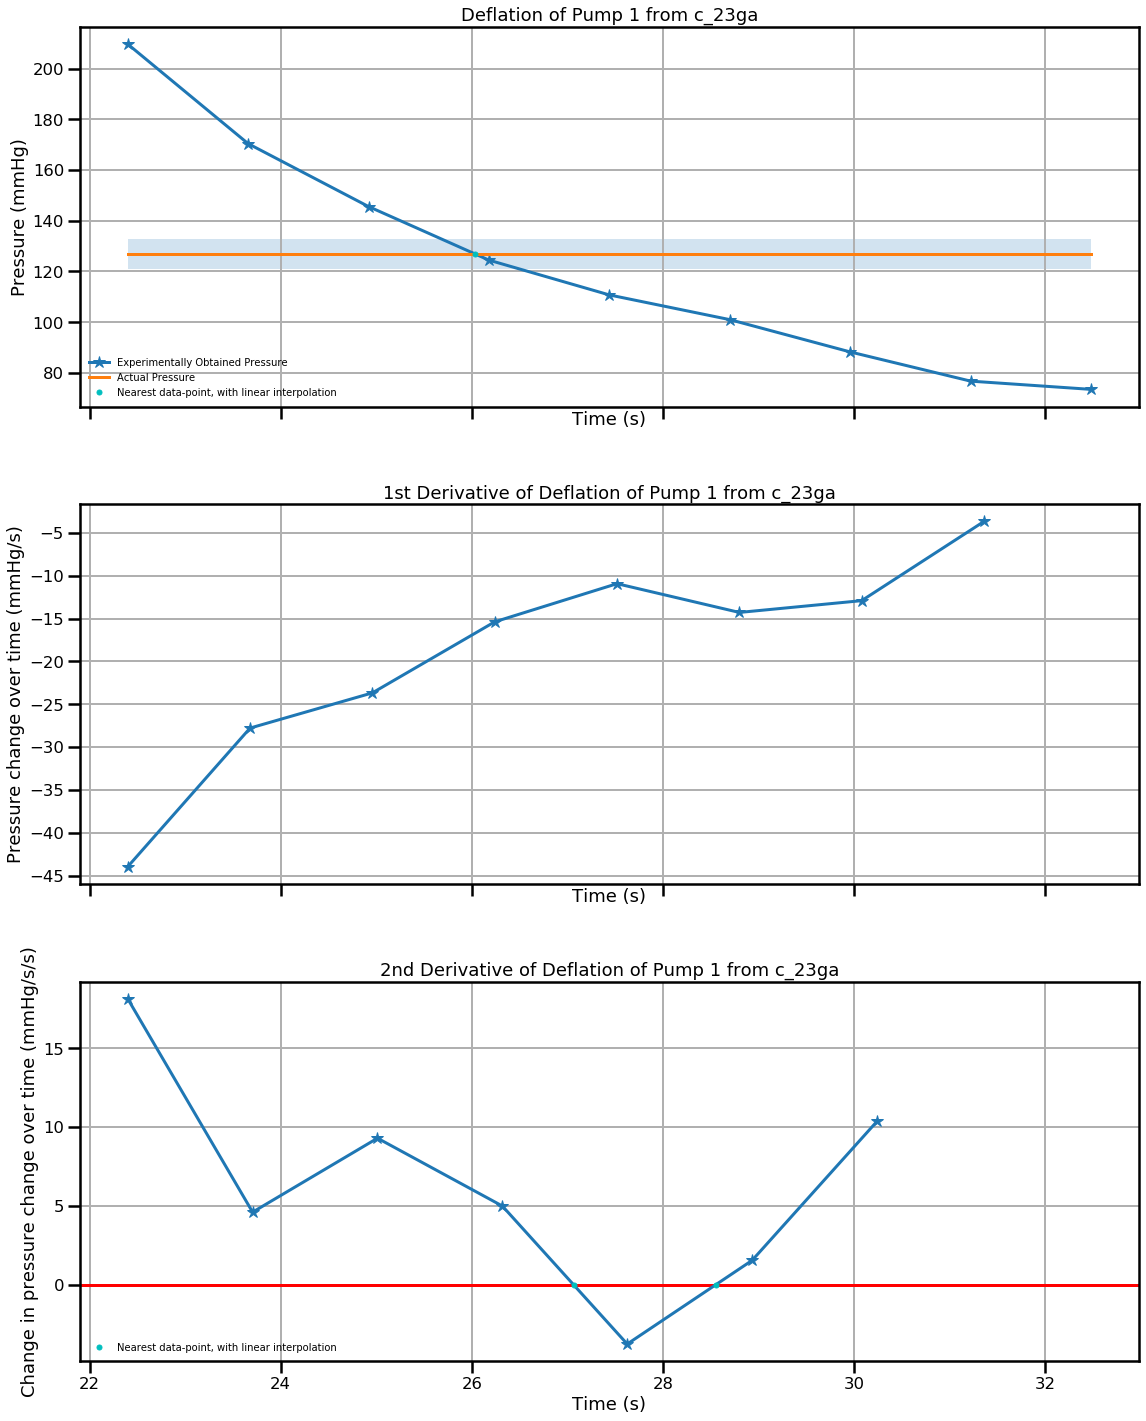

pump_2
[[75.85945458]
 [79.4972973 ]
 [80.60963855]]


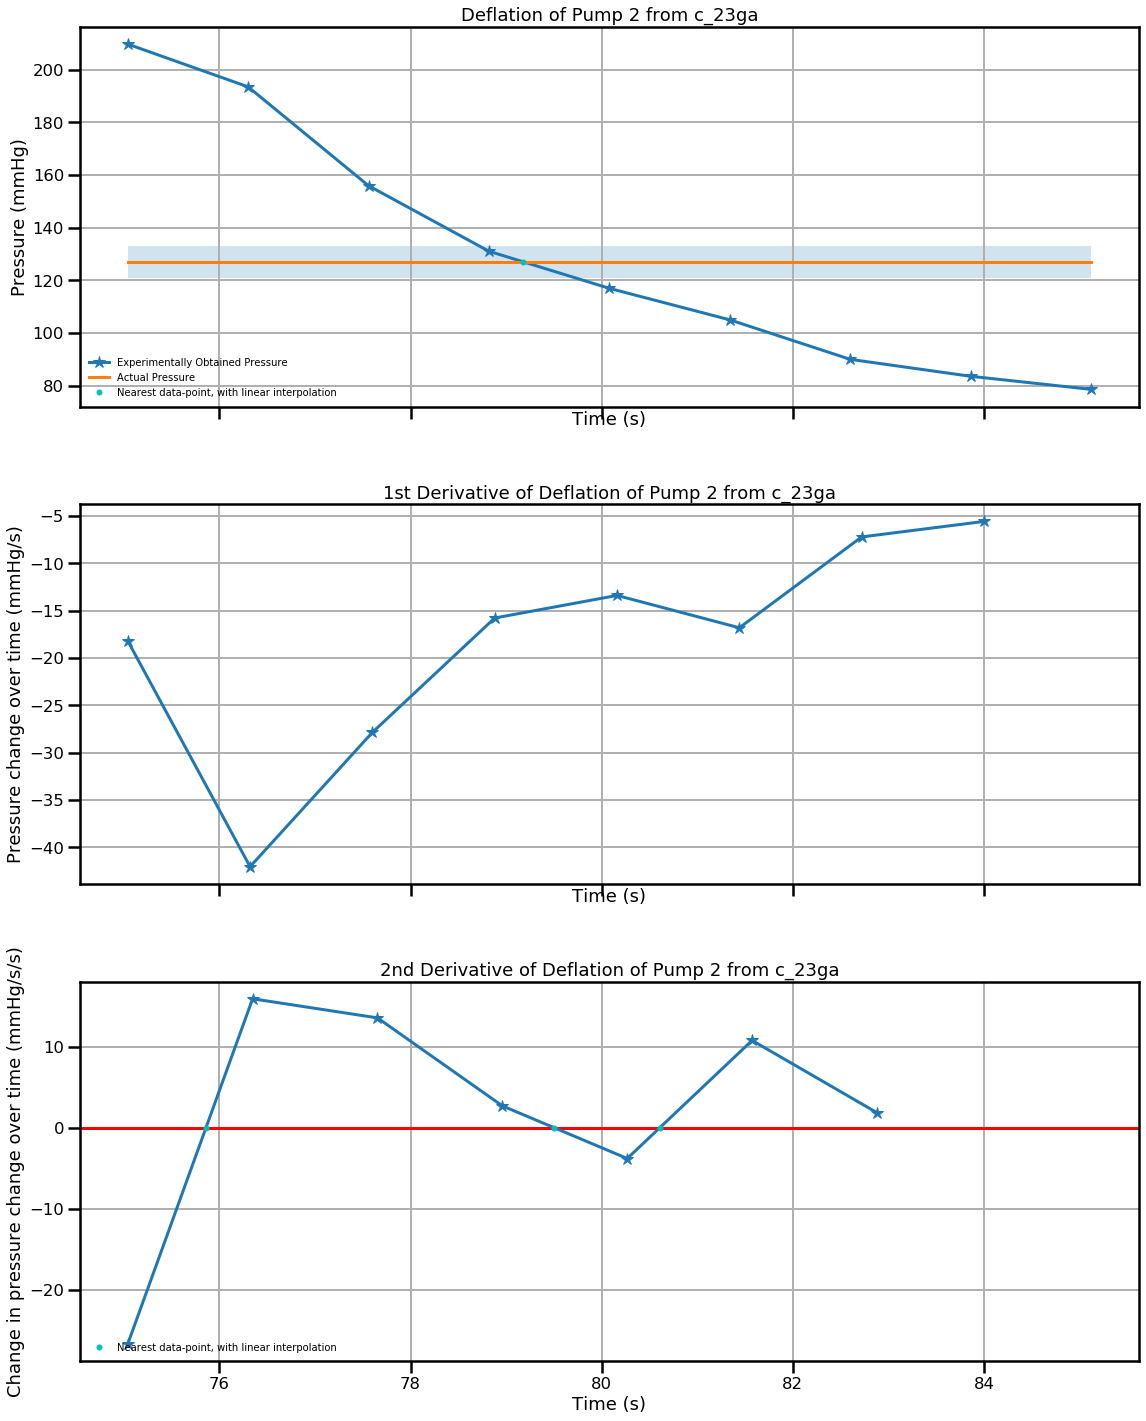

pump_3
[[127.51127273]
 [130.37640457]
 [130.93948466]
 [132.81063385]]


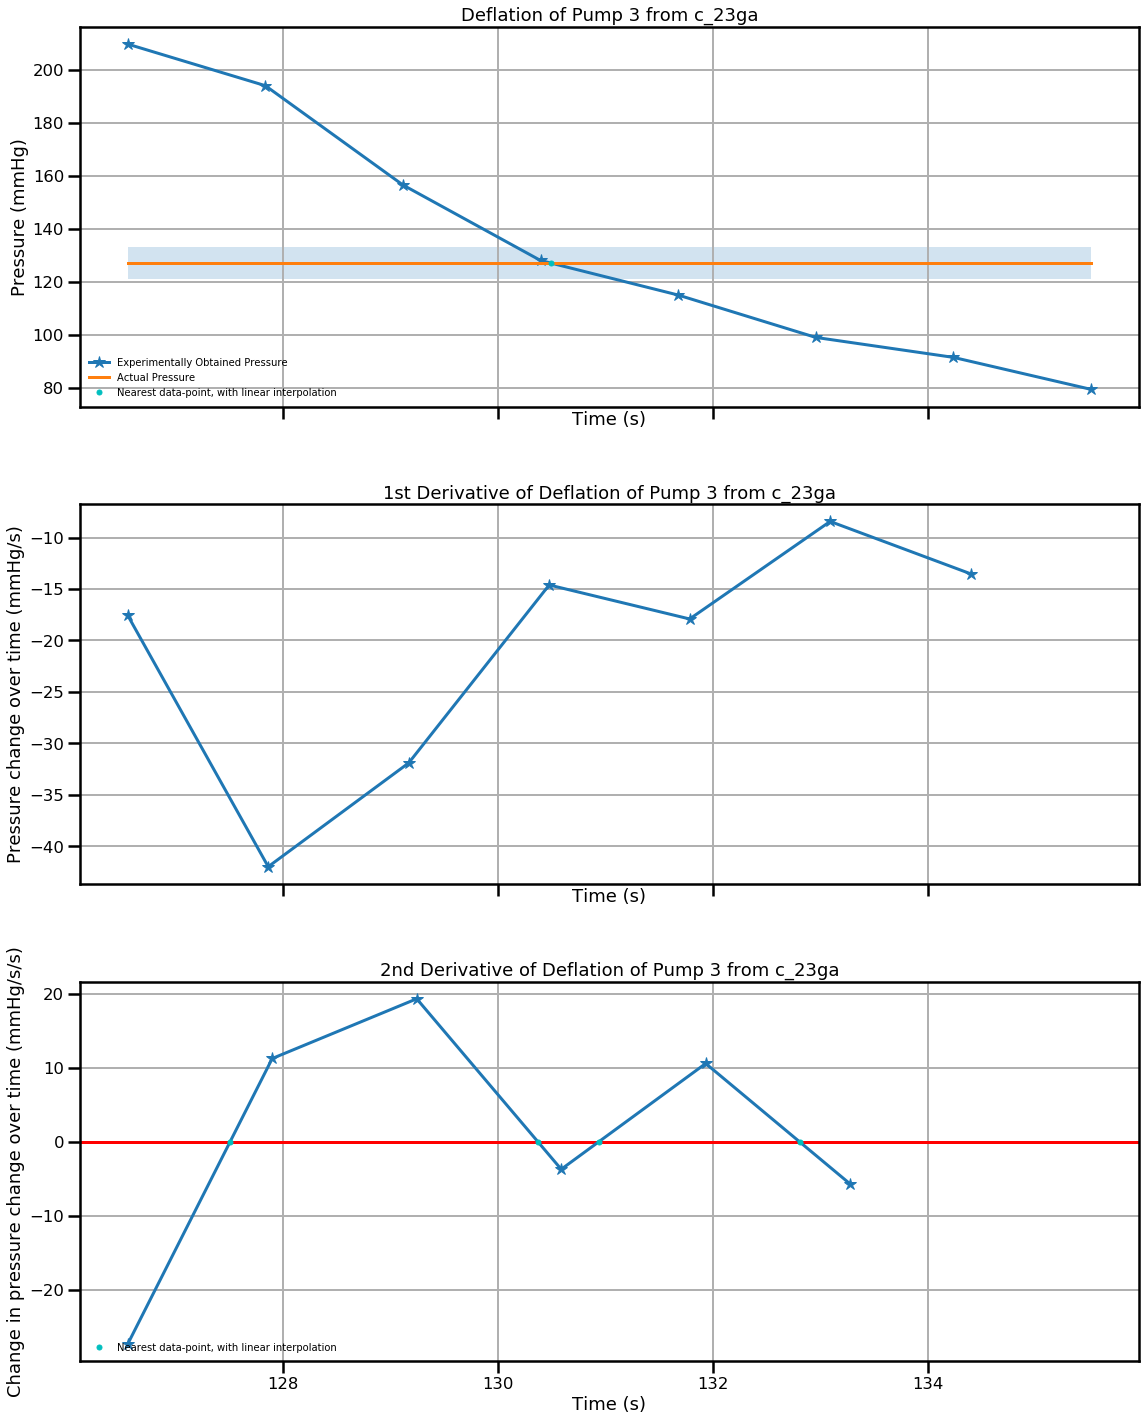

pump_4
[[217.40992912]
 [218.44111781]
 [221.29233171]]


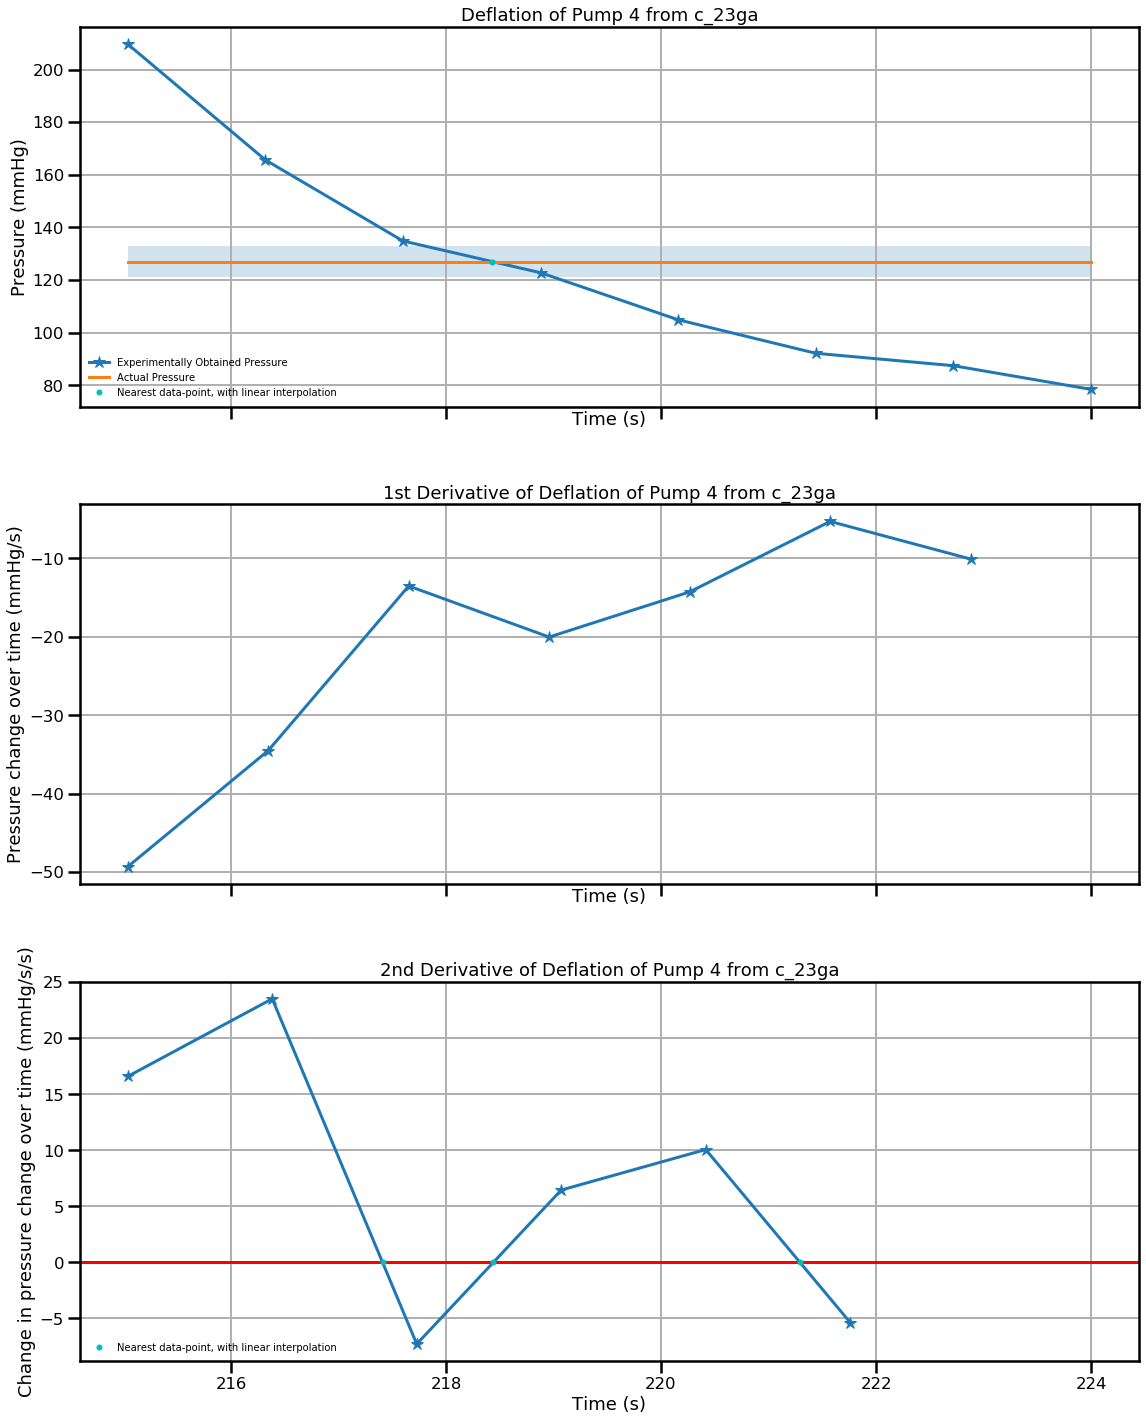

pump_5
[[273.46046305]
 [274.22427892]
 [277.17031626]]


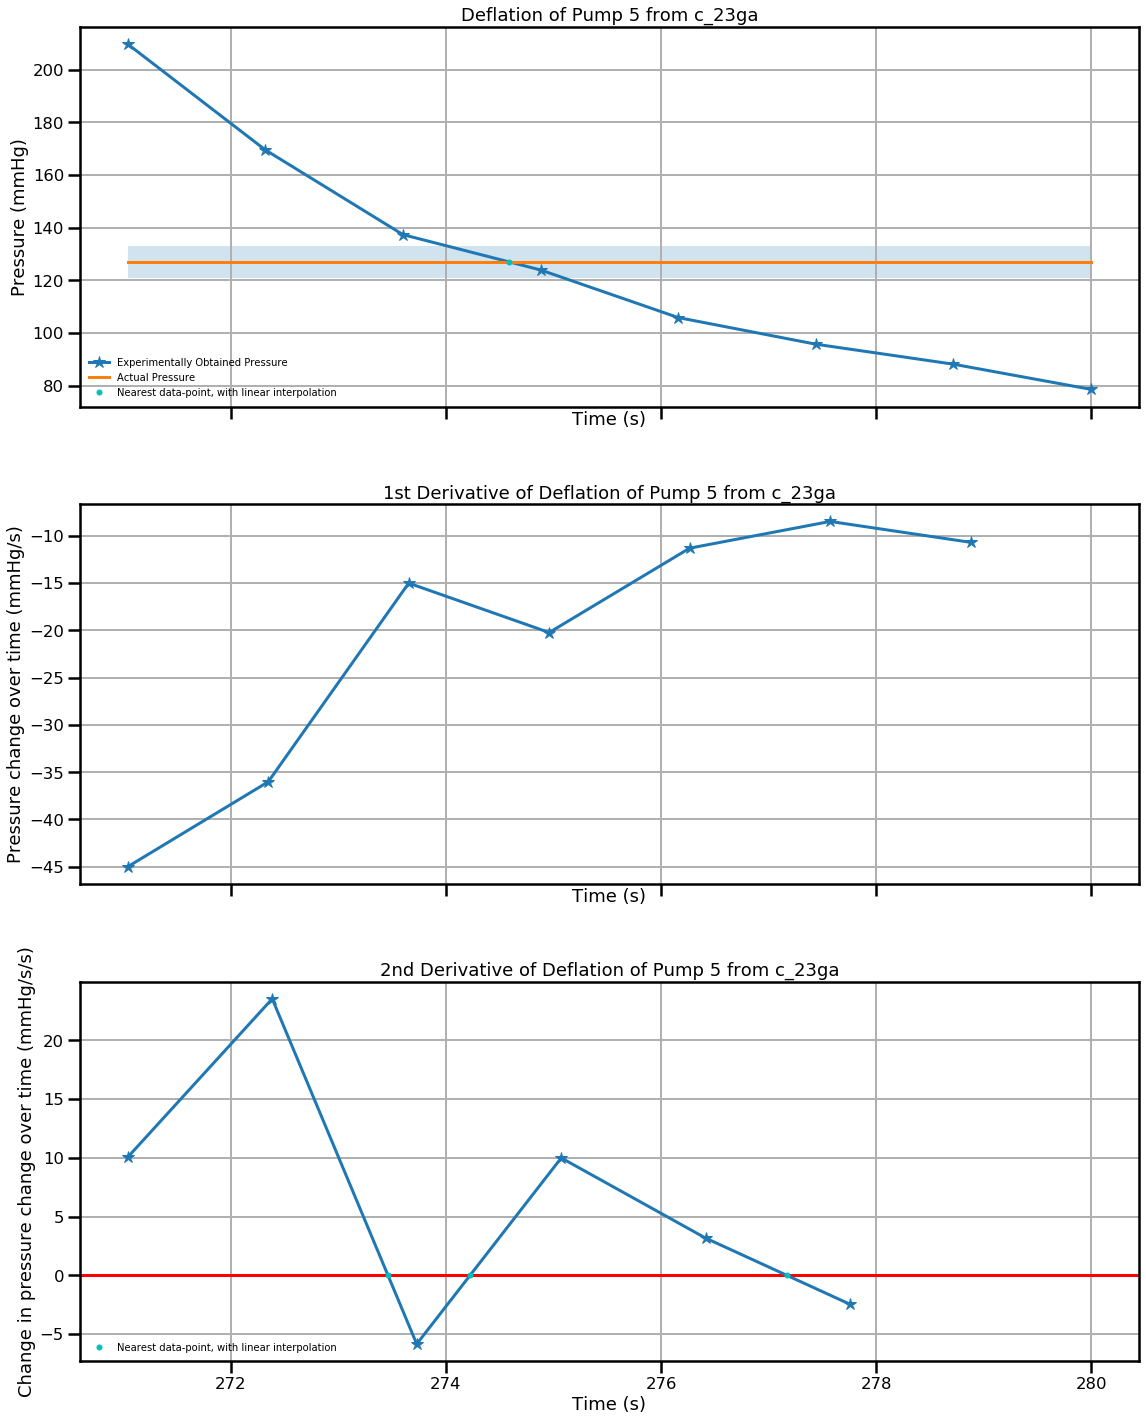

c_25ga
pump_1
[[222.69008016]
 [228.59686957]
 [229.7952    ]]


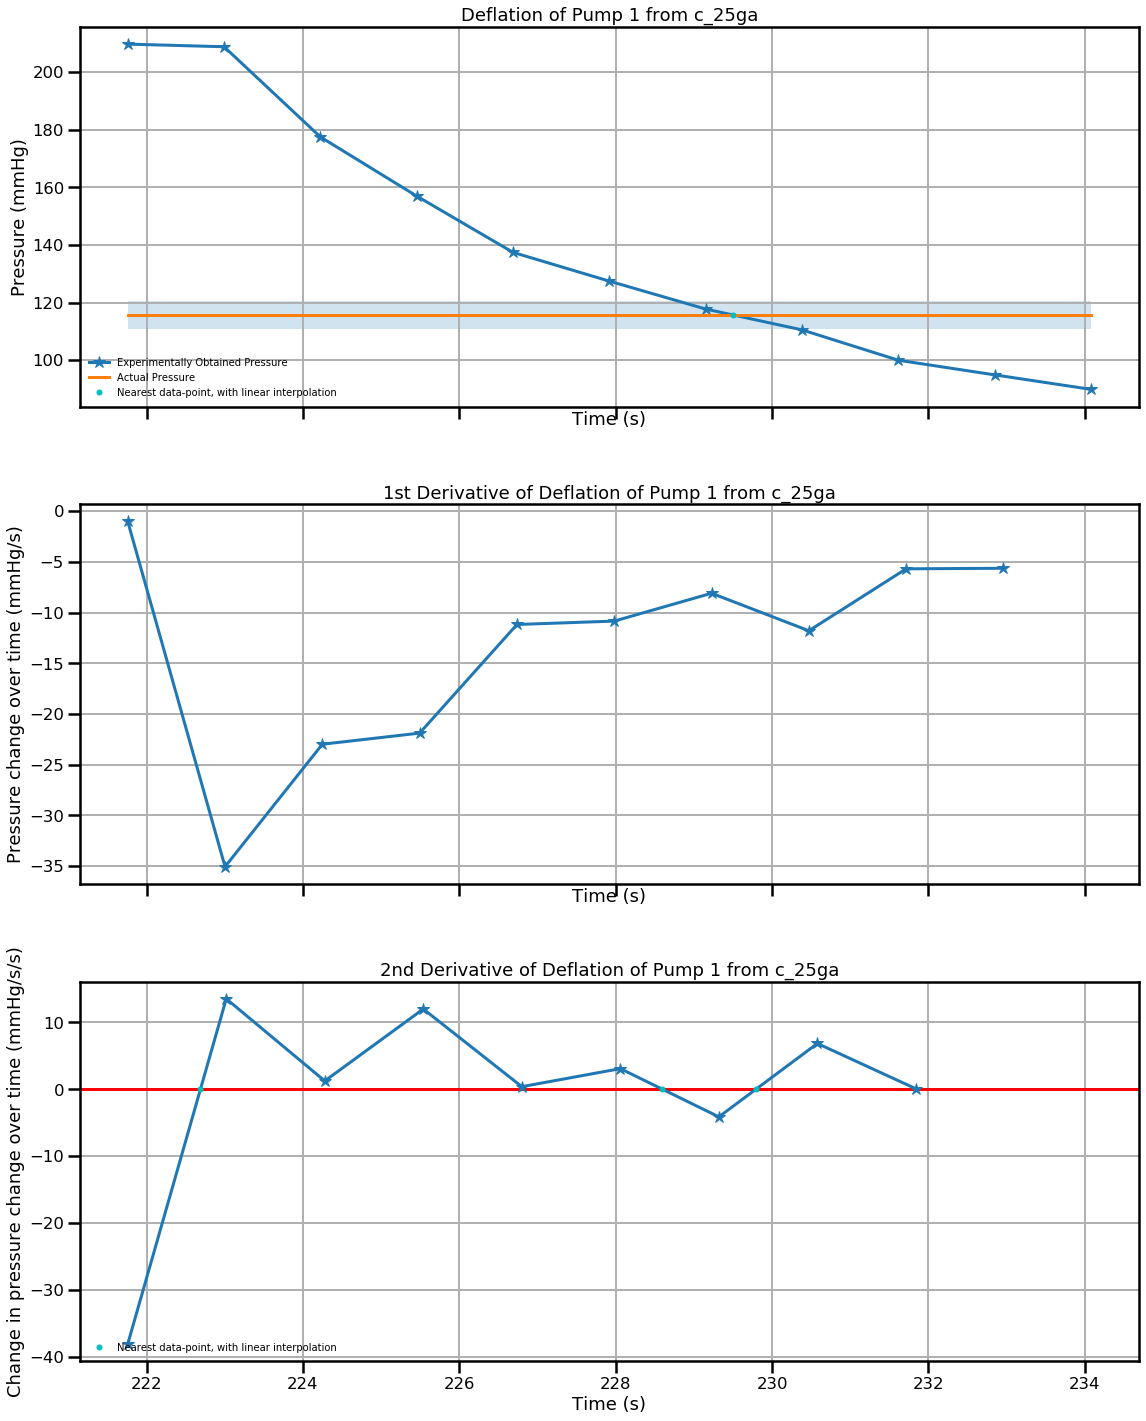

pump_2
[[313.33103943]
 [318.39644444]
 [318.82798277]
 [320.89581921]
 [323.23014189]]


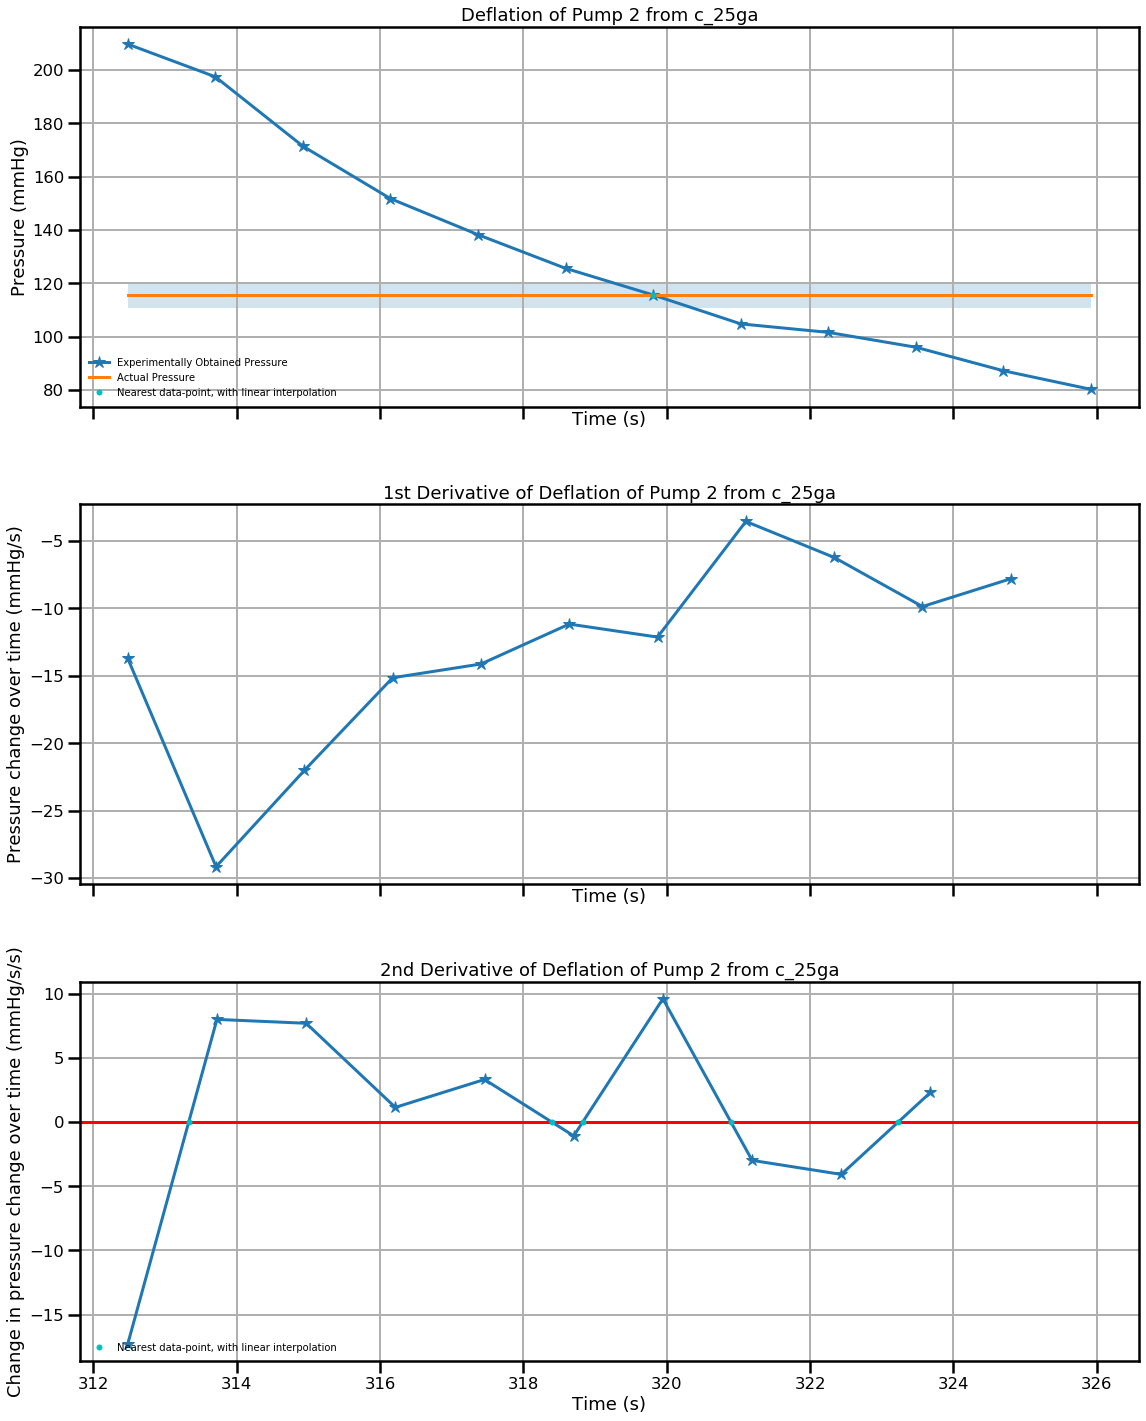

pump_3
[[523.8752439]]
There is only one intercept


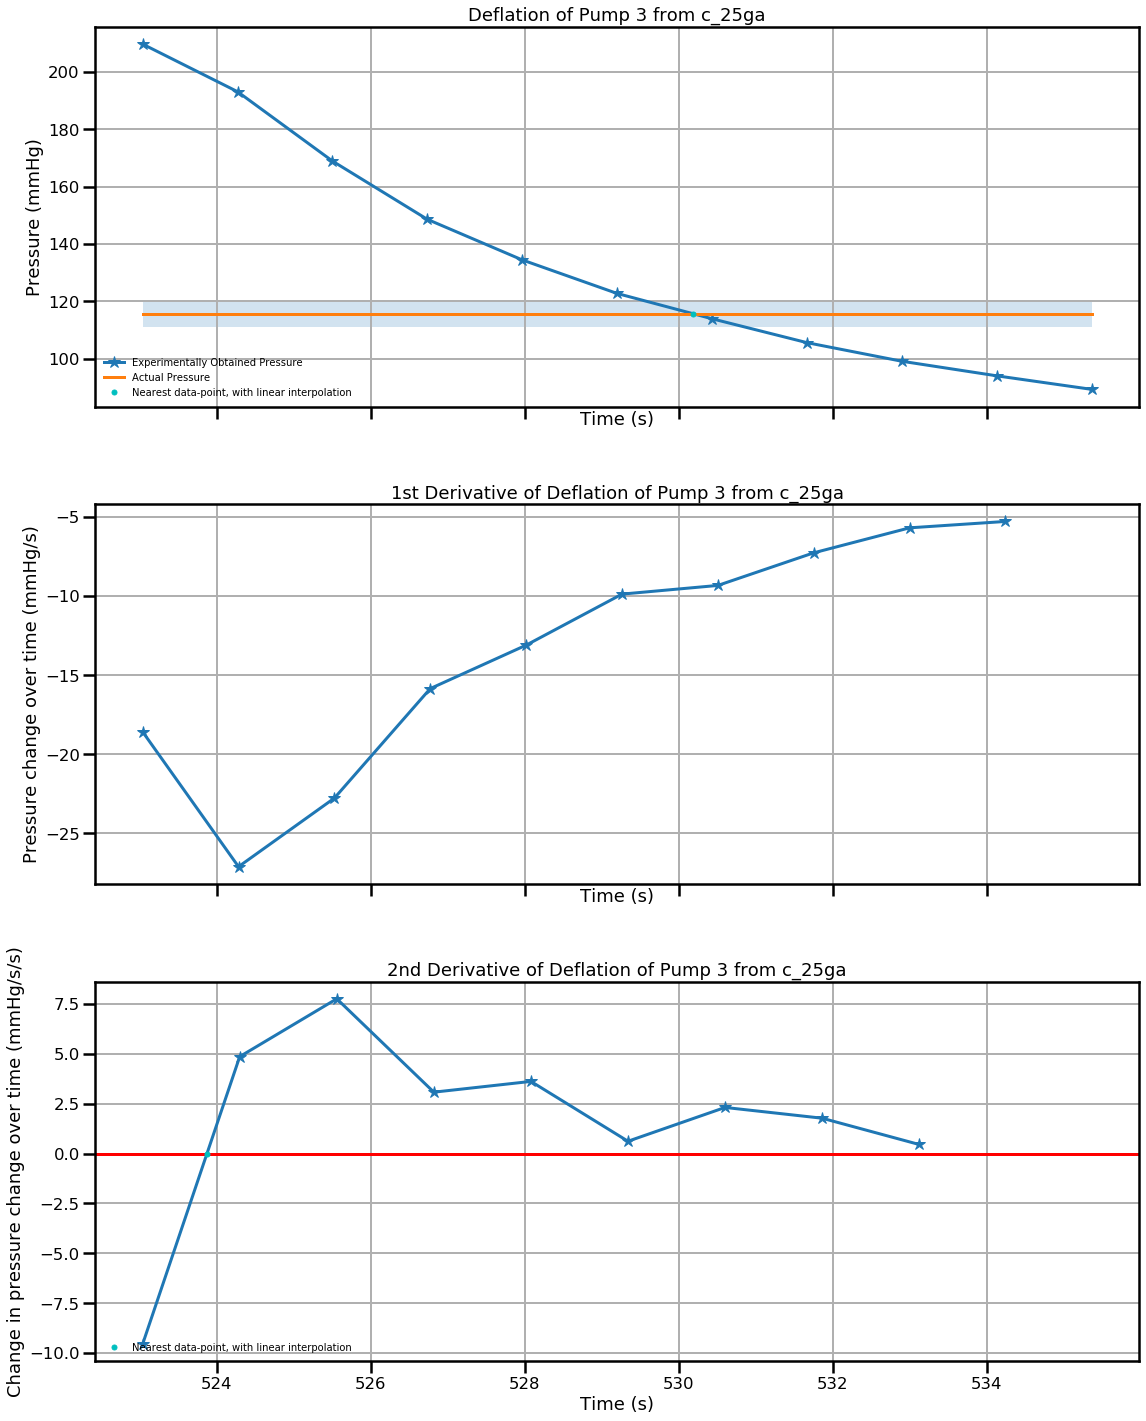

a_27ga
pump_1
[[497.69030664]
 [499.48770106]
 [501.41899915]
 [502.22744501]
 [503.65755832]
 [504.98744014]
 [506.42942918]
 [508.23889001]
 [510.02164313]
 [511.64085561]
 [513.17654417]
 [514.50313461]
 [515.2989899 ]
 [517.3980379 ]
 [519.00706114]
 [520.92279017]]


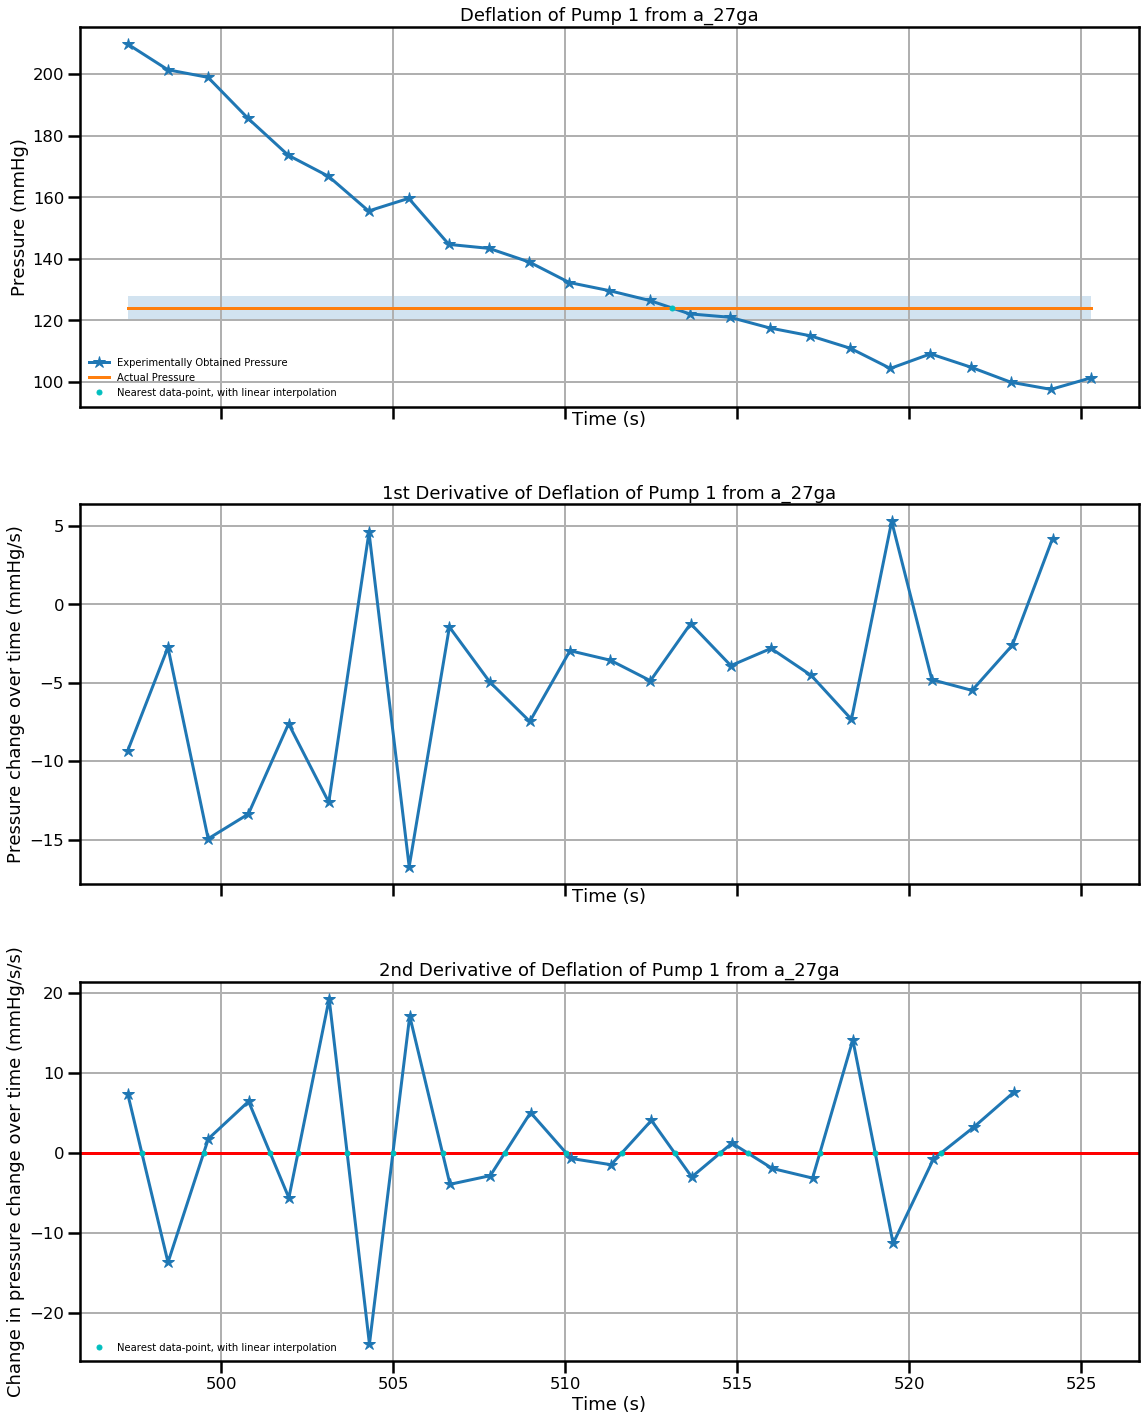

pump_2
[[831.14231486]
 [832.75167556]
 [833.86361549]
 [835.28267658]
 [836.24850149]
 [837.57511817]
 [838.64506179]
 [839.92311851]
 [841.22593359]
 [843.26683304]
 [845.68308748]
 [846.89818182]
 [847.73329404]
 [849.39934751]
 [851.43746688]
 [852.96428792]
 [854.04560606]]


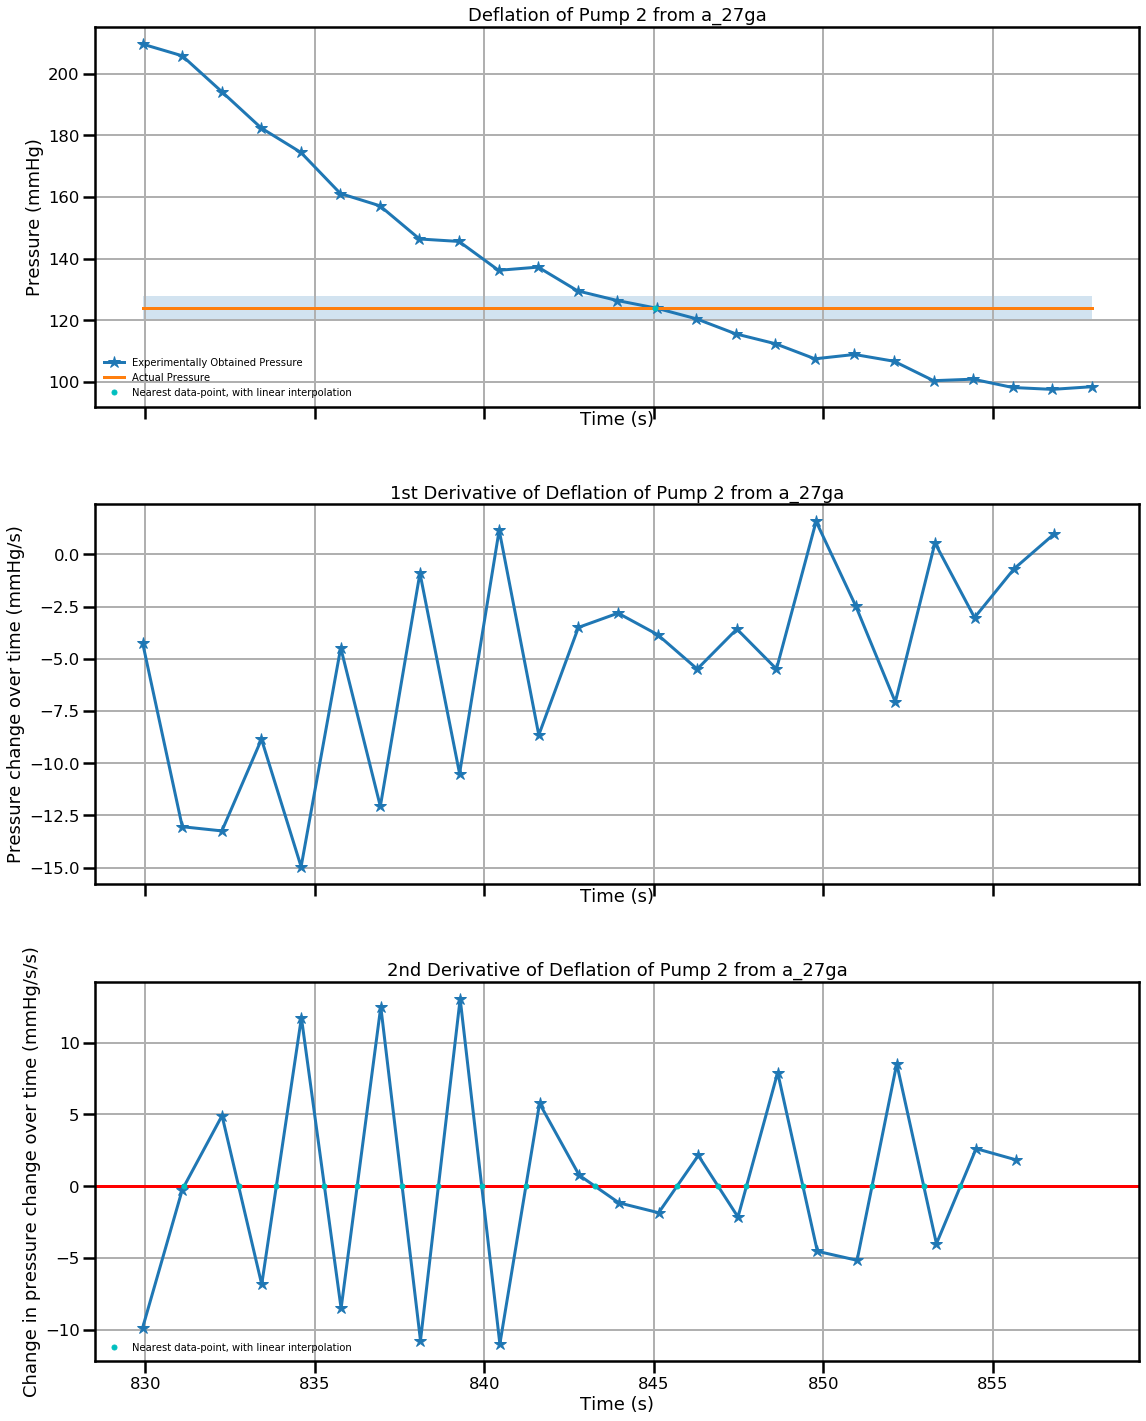

pump_3
[[1161.05107535]
 [1161.76886473]
 [1163.41770524]
 [1164.40111687]
 [1167.88224359]
 [1168.93663346]
 [1170.43409666]
 [1171.75133903]
 [1172.84695323]
 [1173.54821741]
 [1175.19905546]
 [1176.99340996]
 [1178.4036214 ]
 [1179.94032359]
 [1181.48326351]]


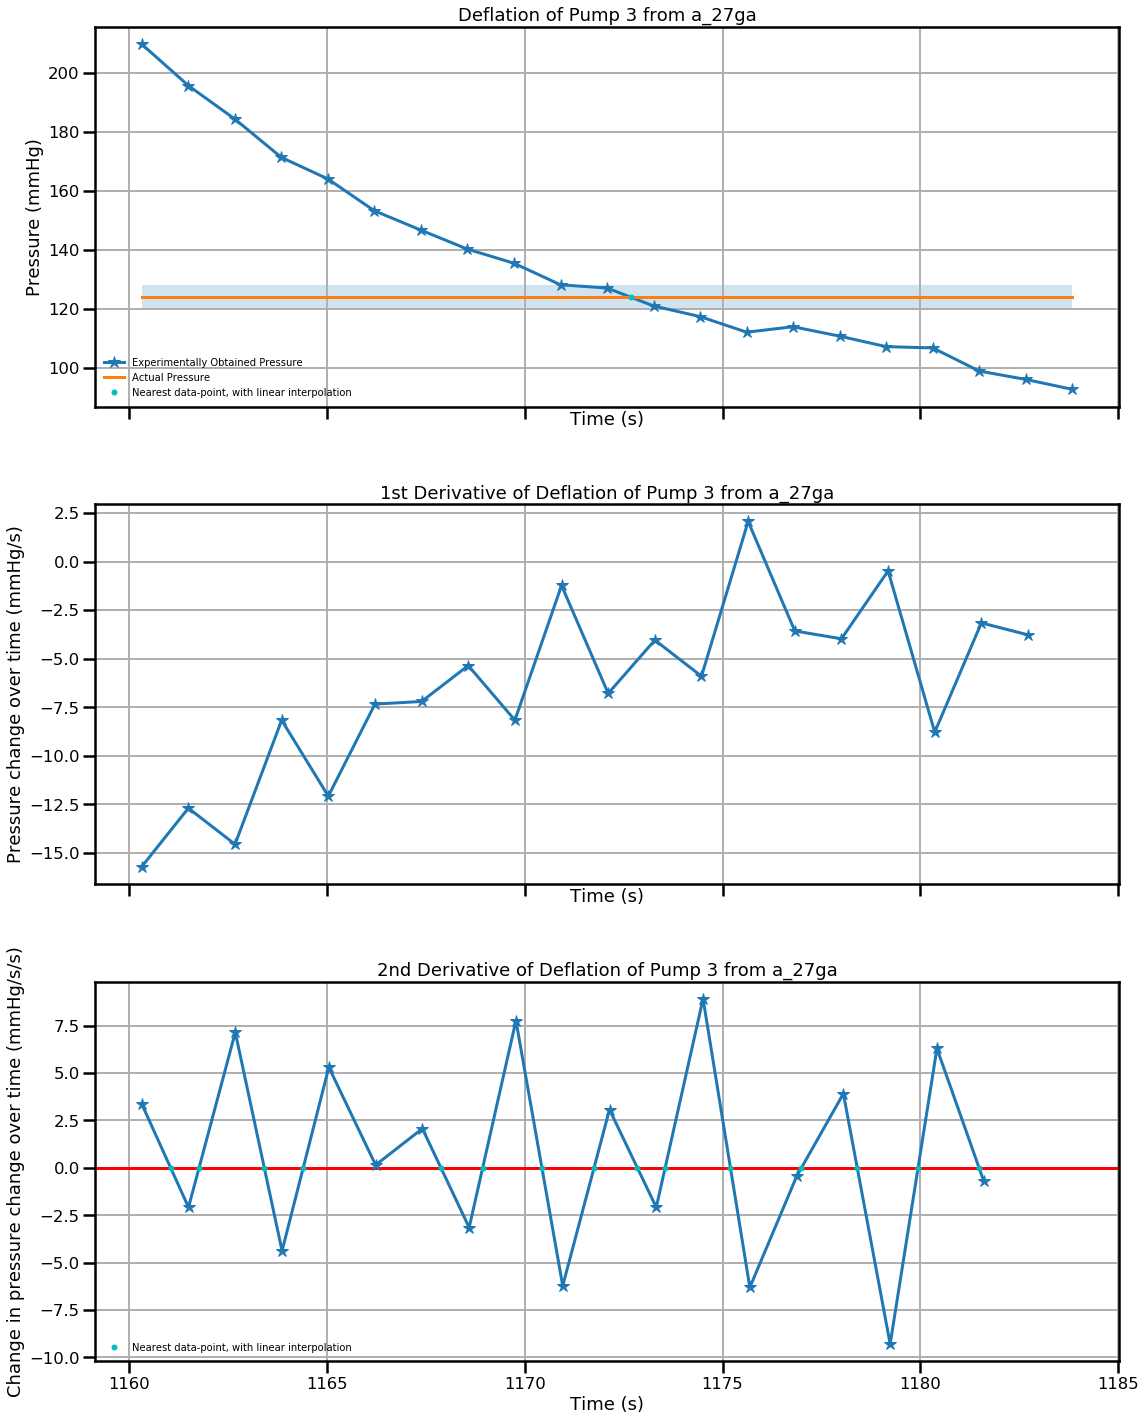

pump_4
[[1410.26758621]
 [1412.17385366]
 [1413.79763636]
 [1416.54214754]
 [1417.83569689]
 [1419.10465169]
 [1420.48811268]
 [1422.28294194]
 [1423.50621538]
 [1424.92054077]
 [1426.51268677]
 [1428.32536   ]
 [1429.9355157 ]
 [1431.94664684]]


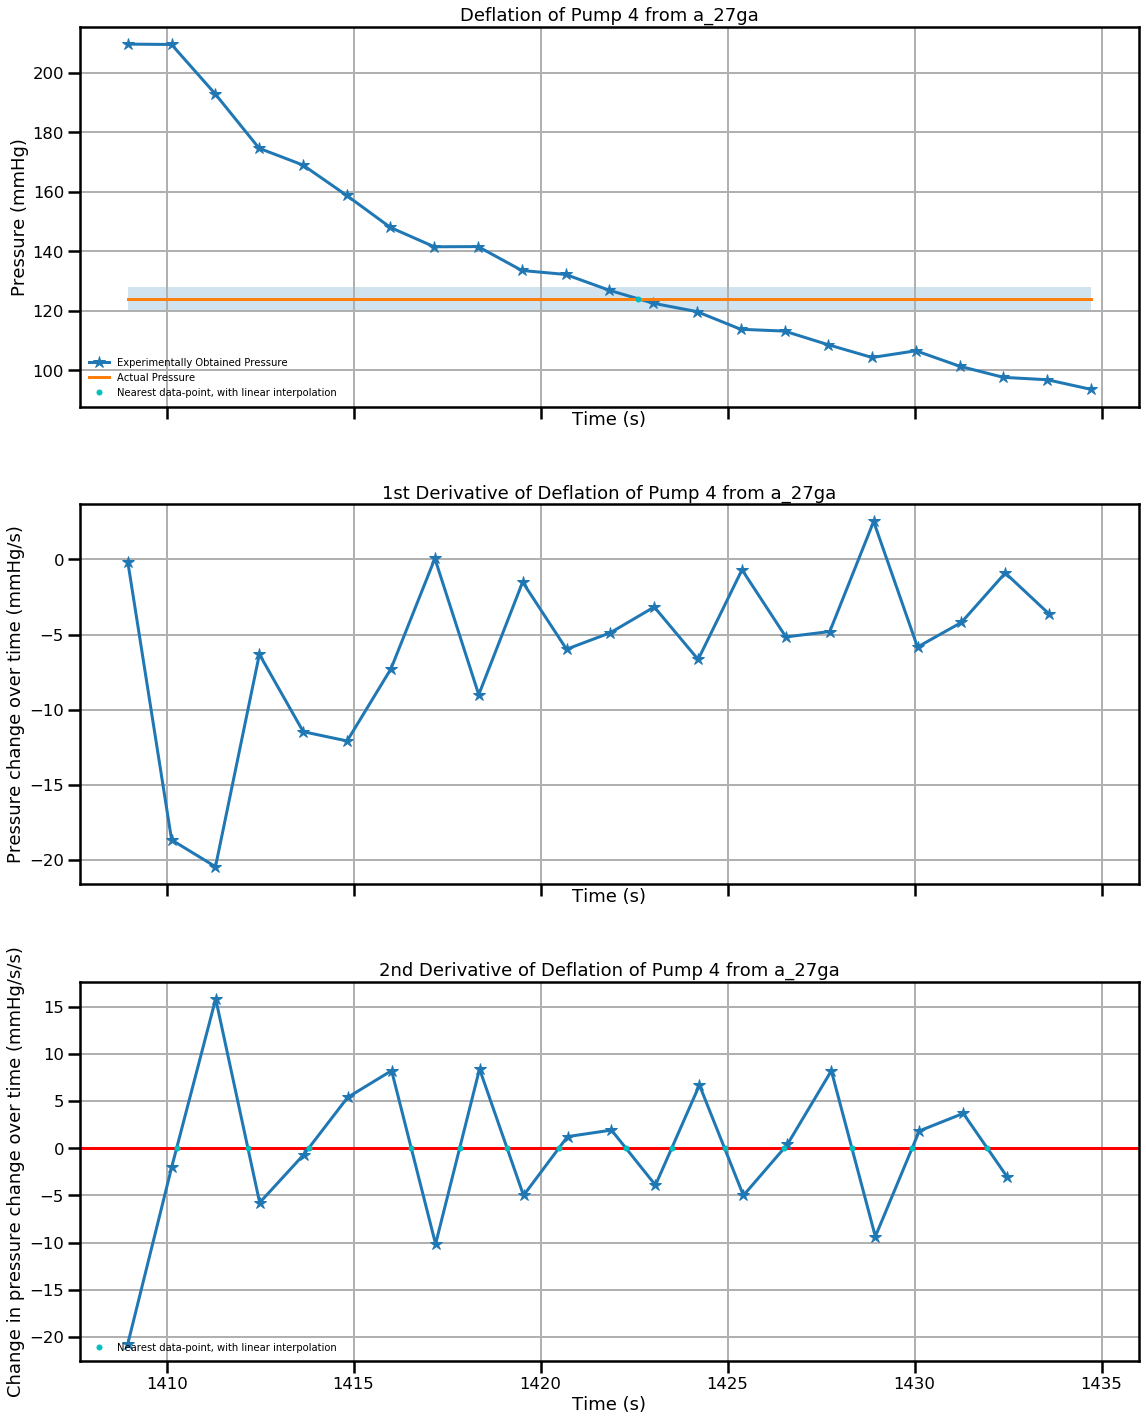

c_30ga
pump_1
[[183.5727246 ]
 [184.18588033]
 [185.14688874]
 [186.33717706]
 [188.05668009]
 [190.3171404 ]
 [193.22695652]
 [195.42491397]
 [196.92211246]
 [198.03009517]
 [199.0709476 ]
 [200.37984431]
 [201.99666157]
 [205.00859748]
 [206.1839941 ]
 [206.75433898]
 [208.27902394]
 [209.87489942]
 [210.20557938]
 [211.48733142]
 [212.91717891]
 [214.2142413 ]
 [215.59852632]
 [215.99041394]
 [217.27153217]
 [218.99237923]
 [221.03757521]
 [223.02398938]
 [224.60789332]
 [226.03958021]
 [226.04790997]
 [227.82134058]
 [229.92289137]
 [231.38809115]
 [232.45216326]
 [233.25952633]
 [234.65535851]]


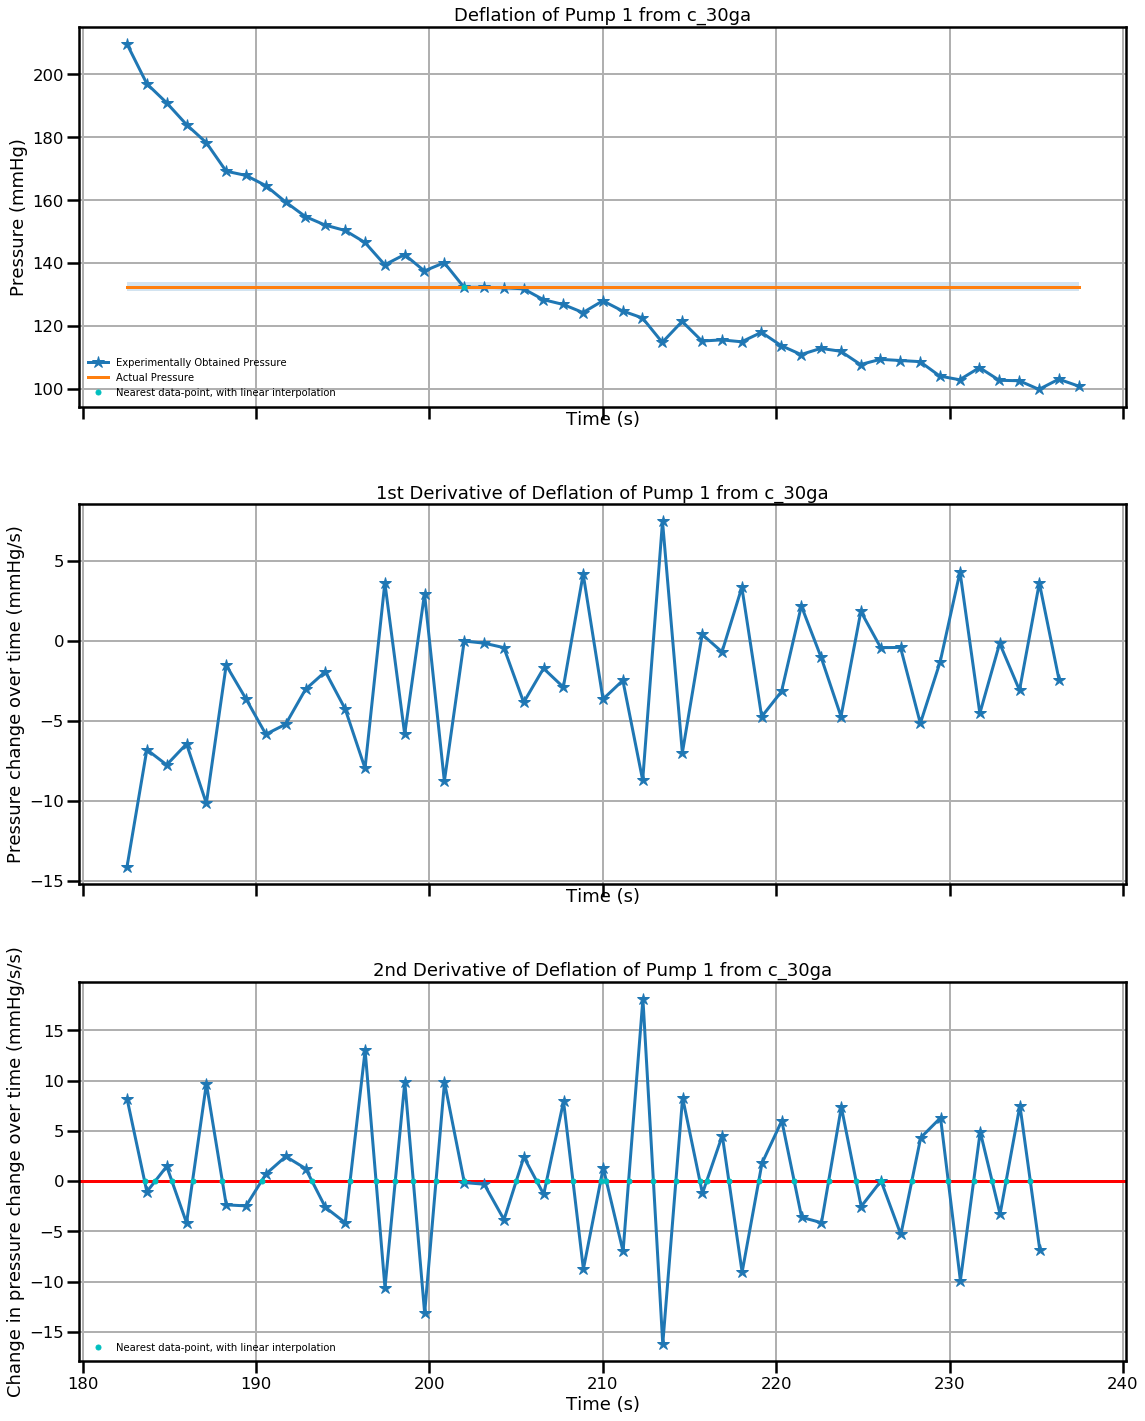

pump_2
[[407.14400776]
 [408.20352408]
 [409.54257426]
 [410.63132691]
 [412.43546446]
 [414.91287814]
 [416.43360872]
 [418.83268672]
 [422.04077403]
 [424.45418803]
 [426.5871847 ]
 [428.17945984]
 [429.04145455]
 [430.89662222]
 [432.37434871]
 [433.55119833]
 [434.48031621]
 [436.41388258]
 [437.94424641]
 [439.24609238]
 [440.21555859]
 [441.56492261]
 [443.52887525]
 [445.62997073]
 [447.87508497]
 [450.08783838]
 [452.28811826]
 [453.91134485]
 [455.21052996]
 [456.29409496]
 [457.5307989 ]
 [458.2294817 ]
 [459.39027768]
 [460.85021818]
 [462.80730663]
 [464.75120503]
 [466.95873847]
 [468.8969771 ]]


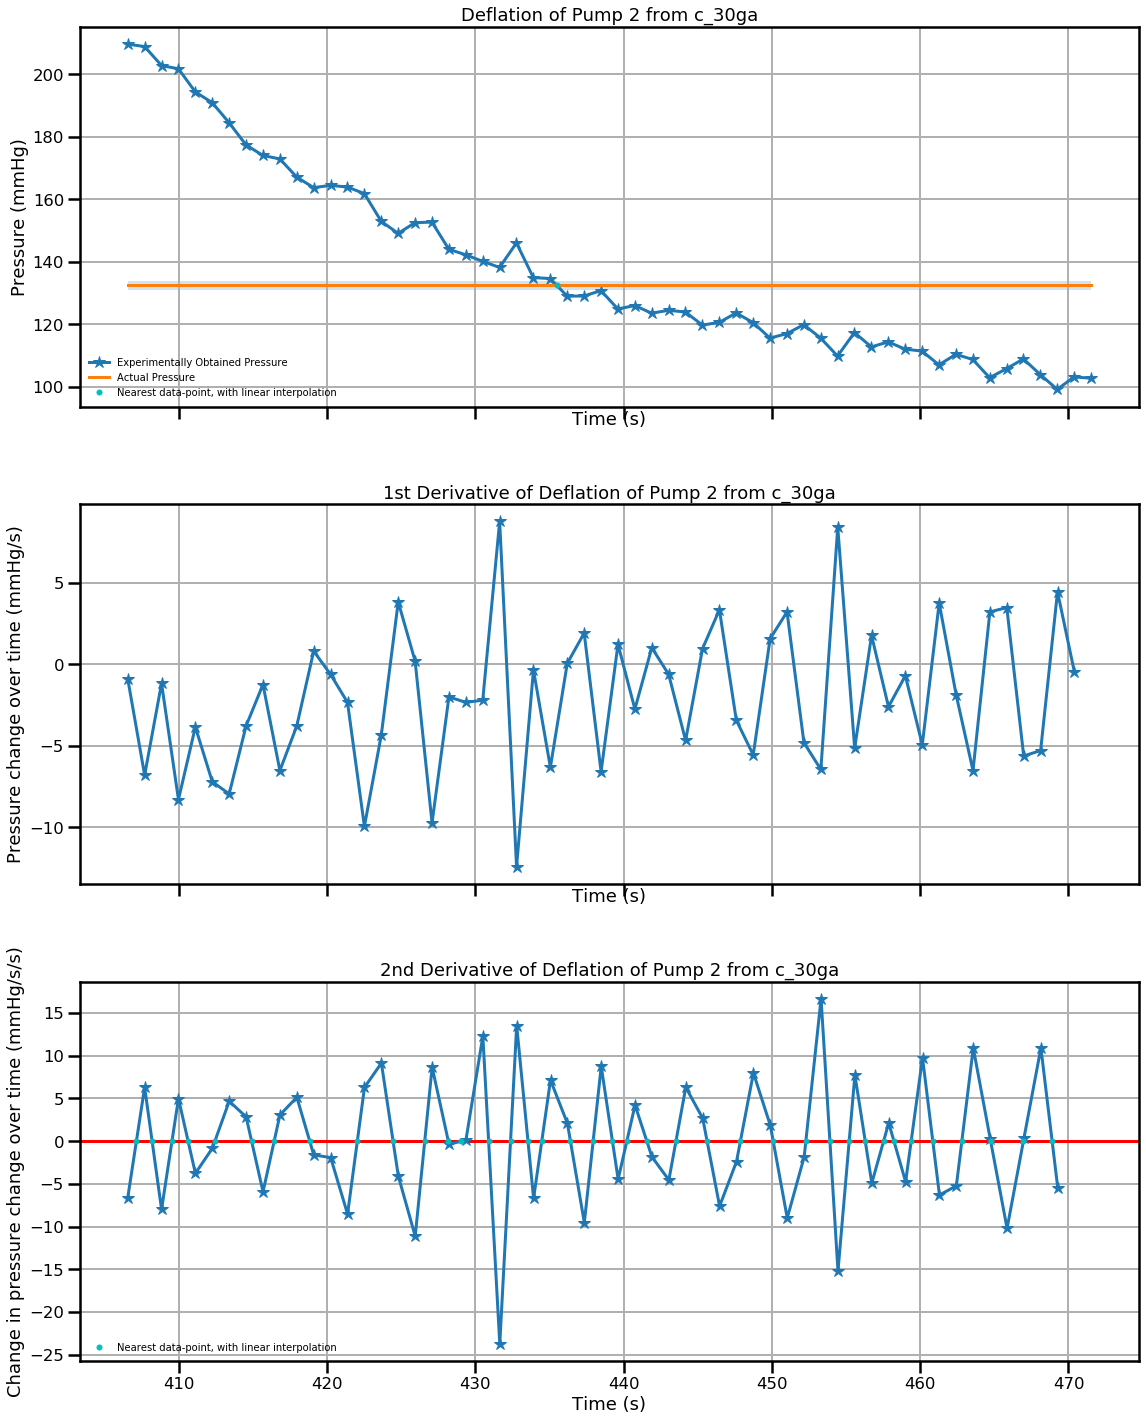

pump_3


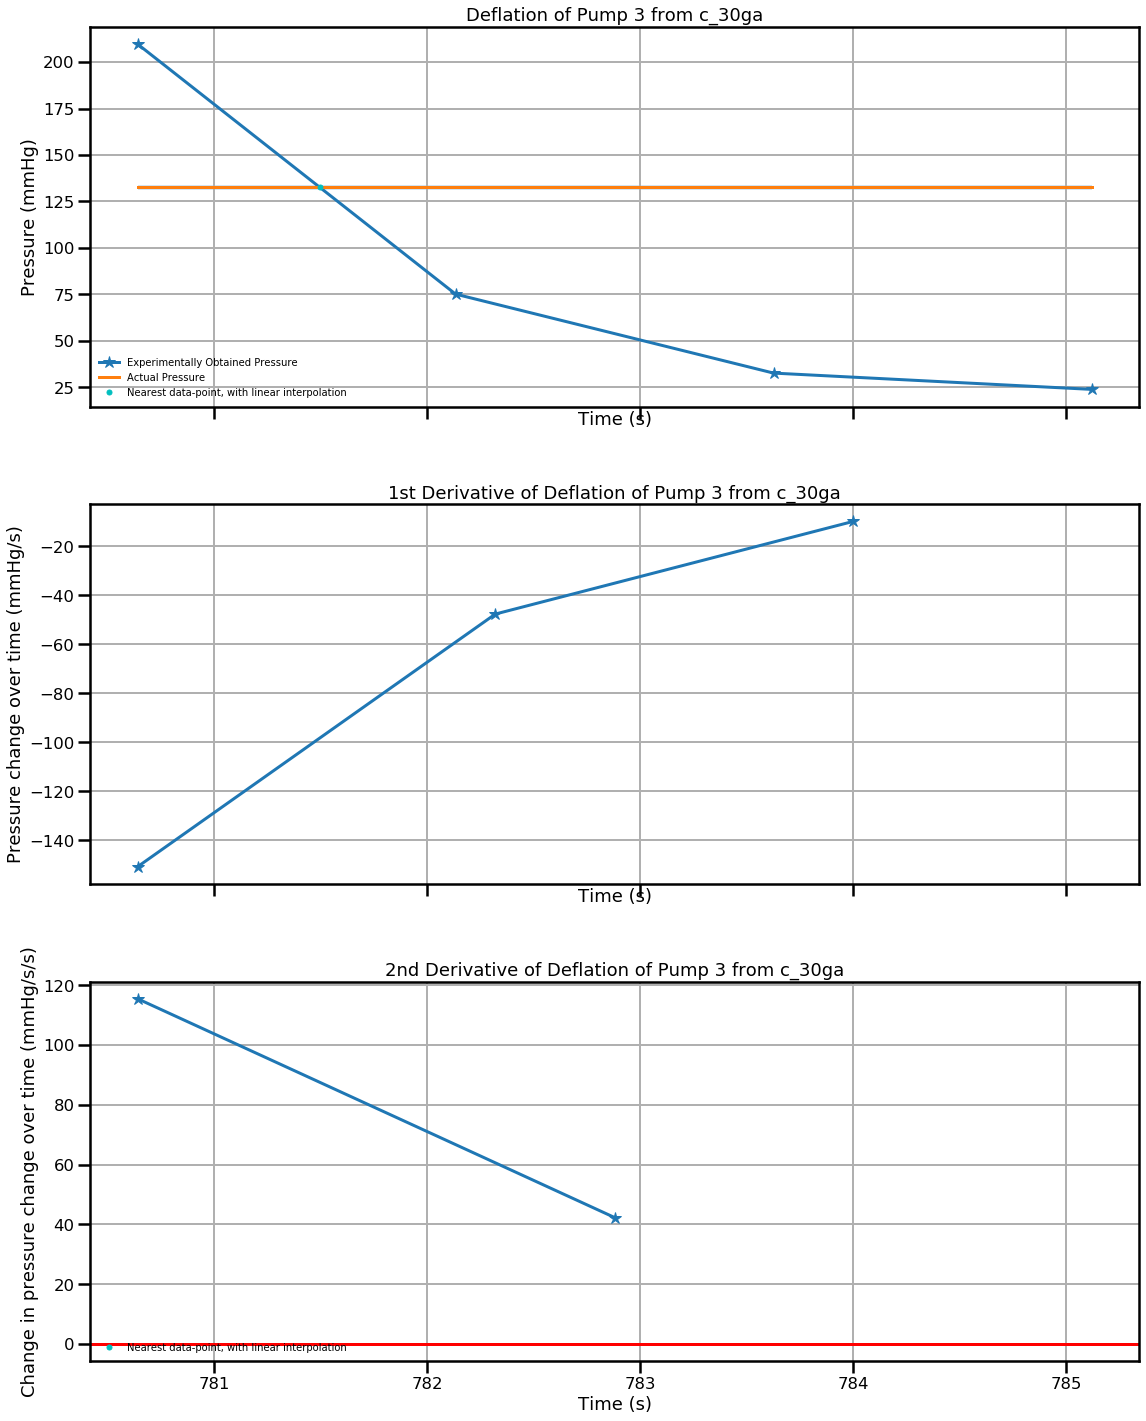

pump_4
[[823.81961982]
 [825.77213677]
 [827.25213366]
 [828.50047334]
 [829.7254103 ]
 [832.6548668 ]
 [834.07728146]
 [835.38777599]
 [836.09387774]
 [837.3581306 ]
 [840.02086767]
 [843.15656949]
 [844.03806486]
 [845.25681918]
 [846.72172946]
 [848.76348776]
 [851.04095769]
 [854.12783   ]
 [855.57329978]
 [857.01243408]
 [858.812574  ]
 [861.06928494]
 [863.3374177 ]
 [864.9722488 ]
 [865.59169413]
 [867.09681869]
 [869.29403894]
 [870.44410305]
 [871.62753653]
 [873.95299831]
 [876.01146116]
 [877.27666   ]
 [878.50533634]
 [879.78912591]
 [881.86500325]
 [885.04323808]
 [886.41789534]
 [887.68220344]]


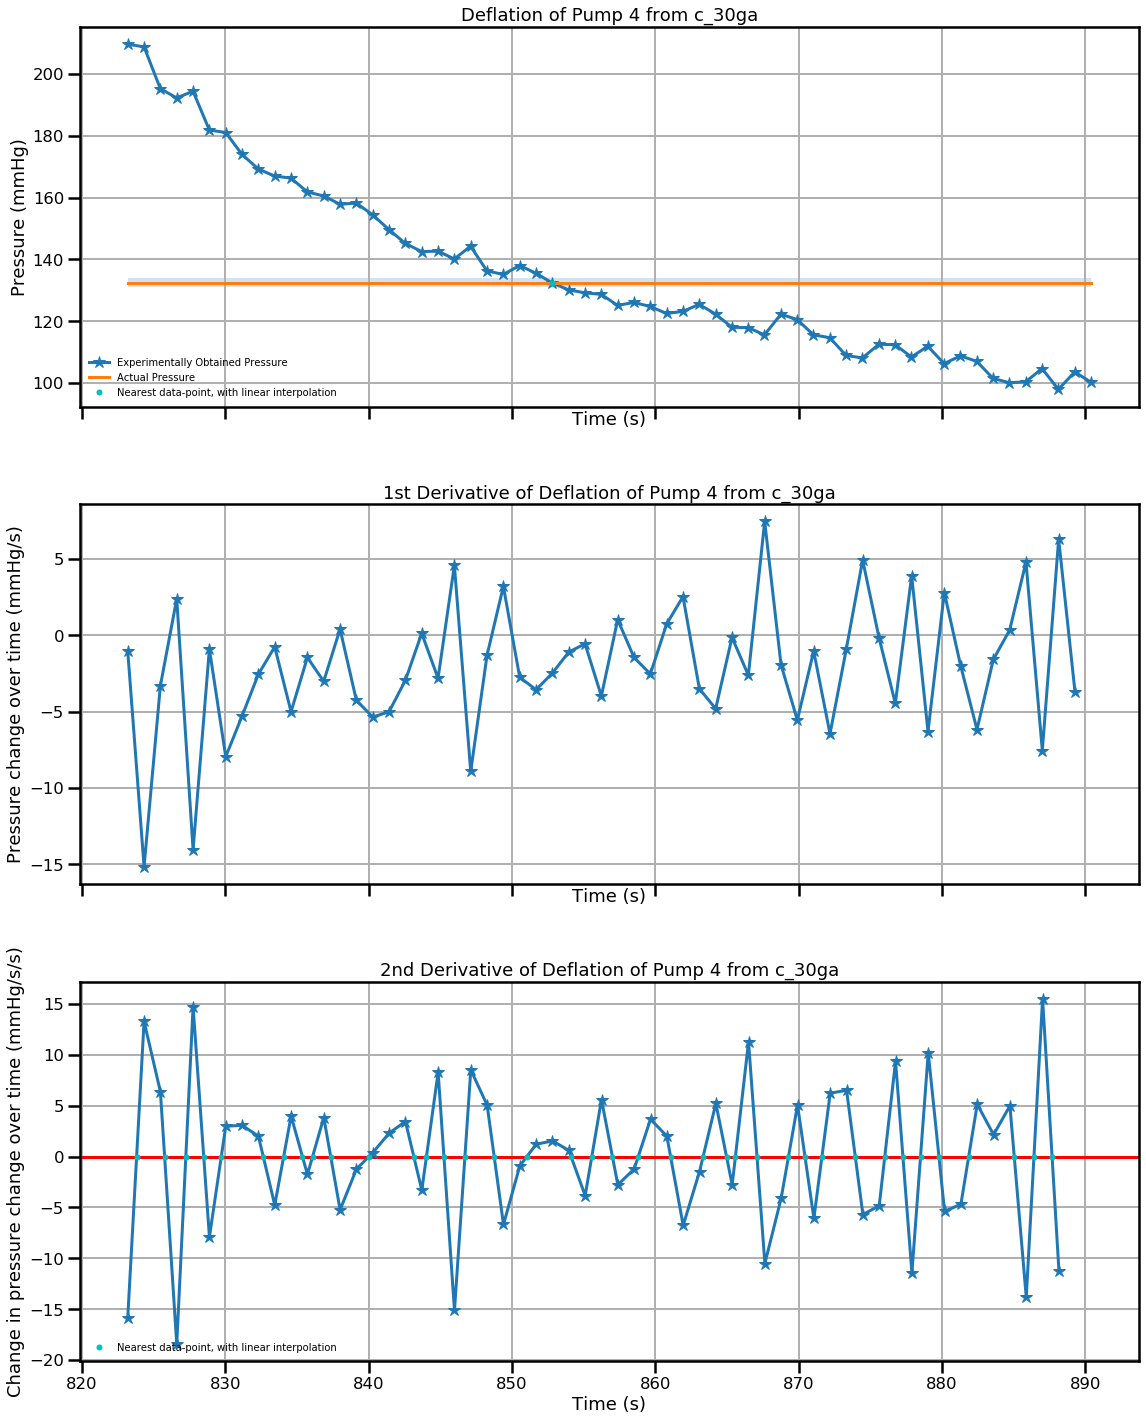

m_27ga
pump_1
[[31.83234581]
 [34.4971831 ]
 [35.47855228]
 [37.25148   ]
 [37.63101563]
 [40.20438061]
 [41.7659332 ]
 [46.21691843]
 [48.21981818]]


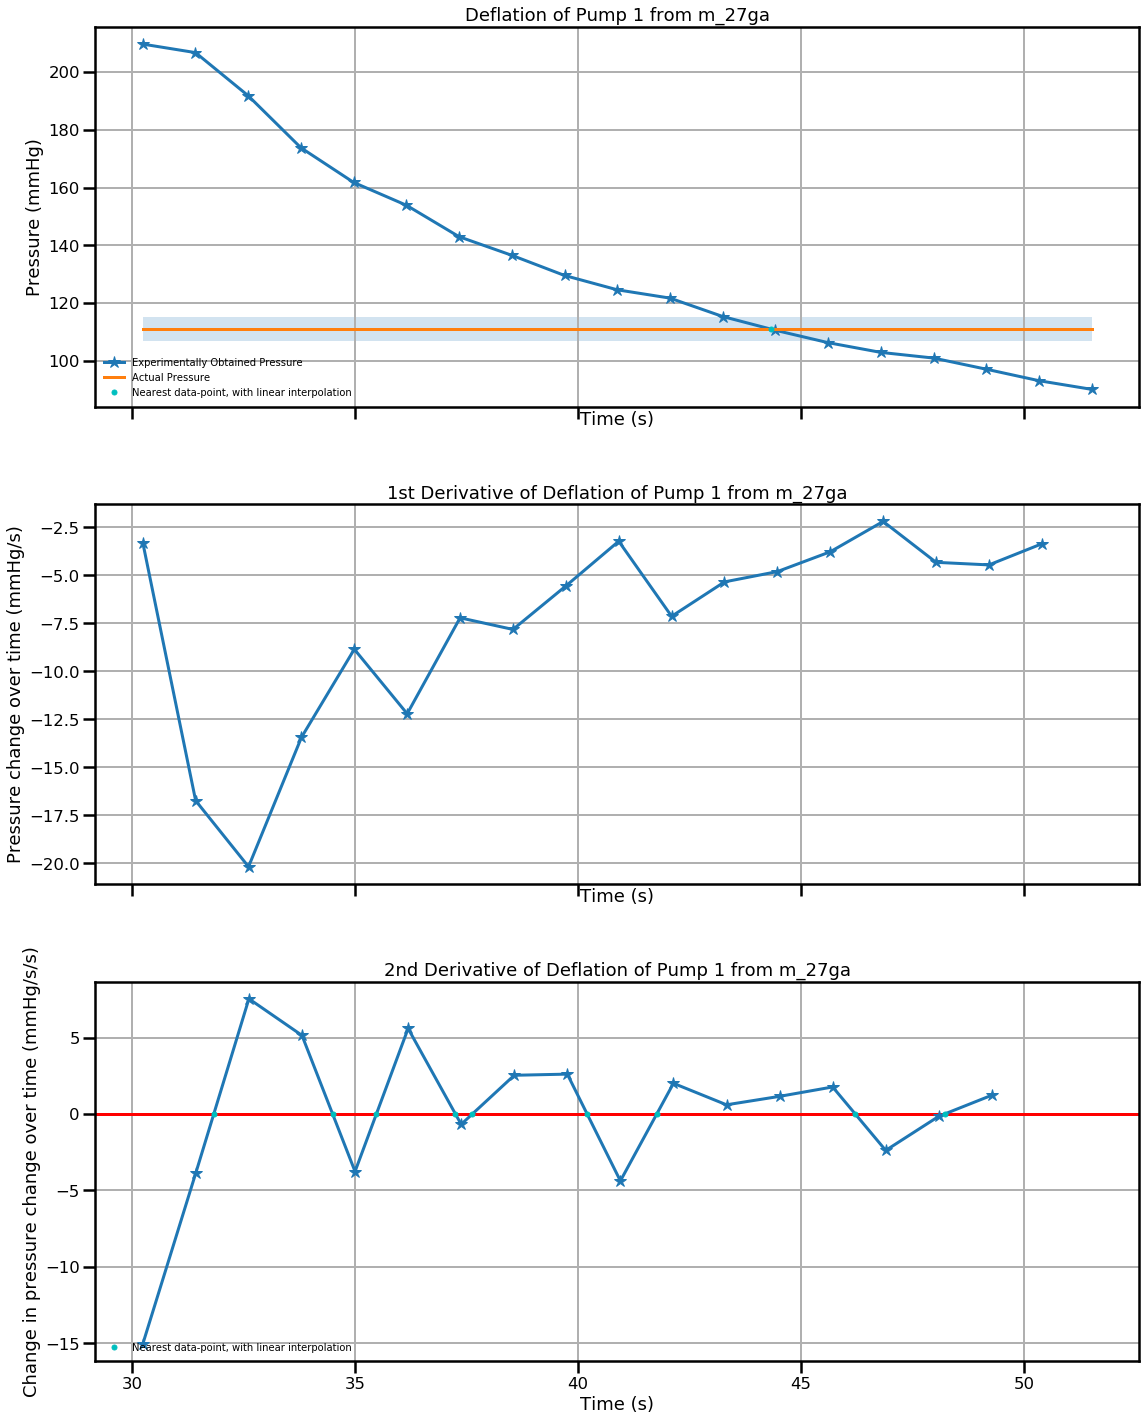

pump_2
[[448.38436073]
 [452.58409222]
 [453.41614458]
 [454.83252955]
 [455.43852596]
 [457.22217593]
 [458.5814838 ]
 [459.3607619 ]
 [460.71663071]
 [462.40323859]]


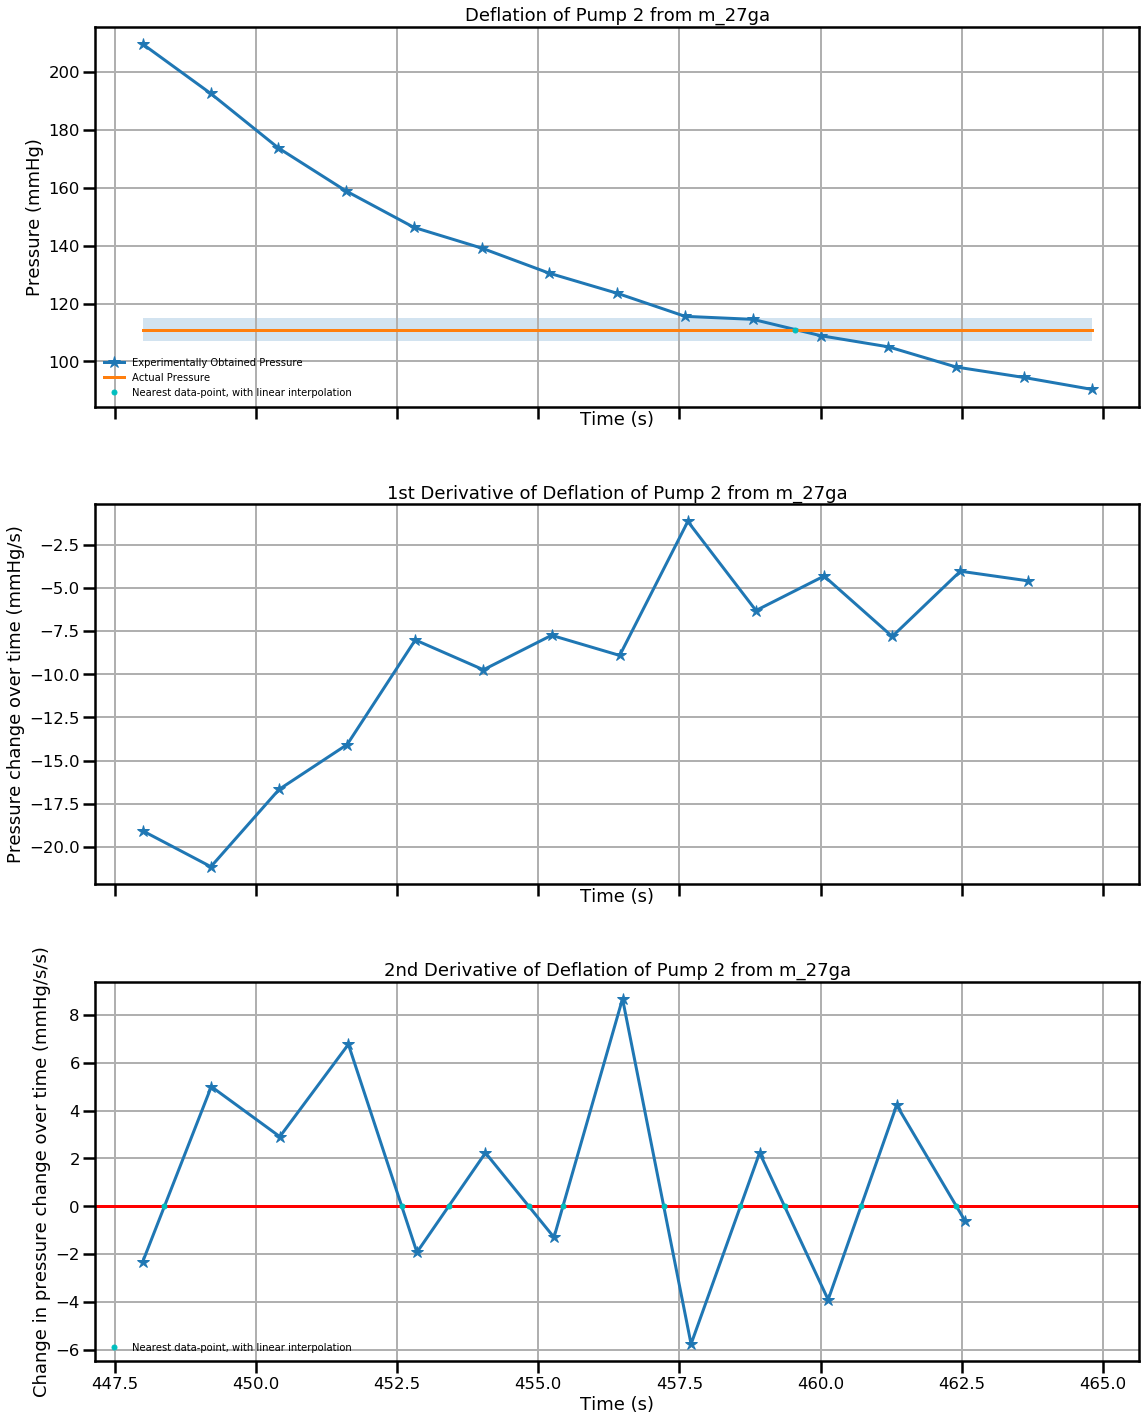

pump_3
[[586.21469502]
 [588.04285139]
 [588.46725187]
 [590.58461538]
 [590.58461538]
 [592.55857231]
 [593.66282051]
 [595.08965155]
 [595.6700966 ]
 [597.27204673]
 [599.23212516]]


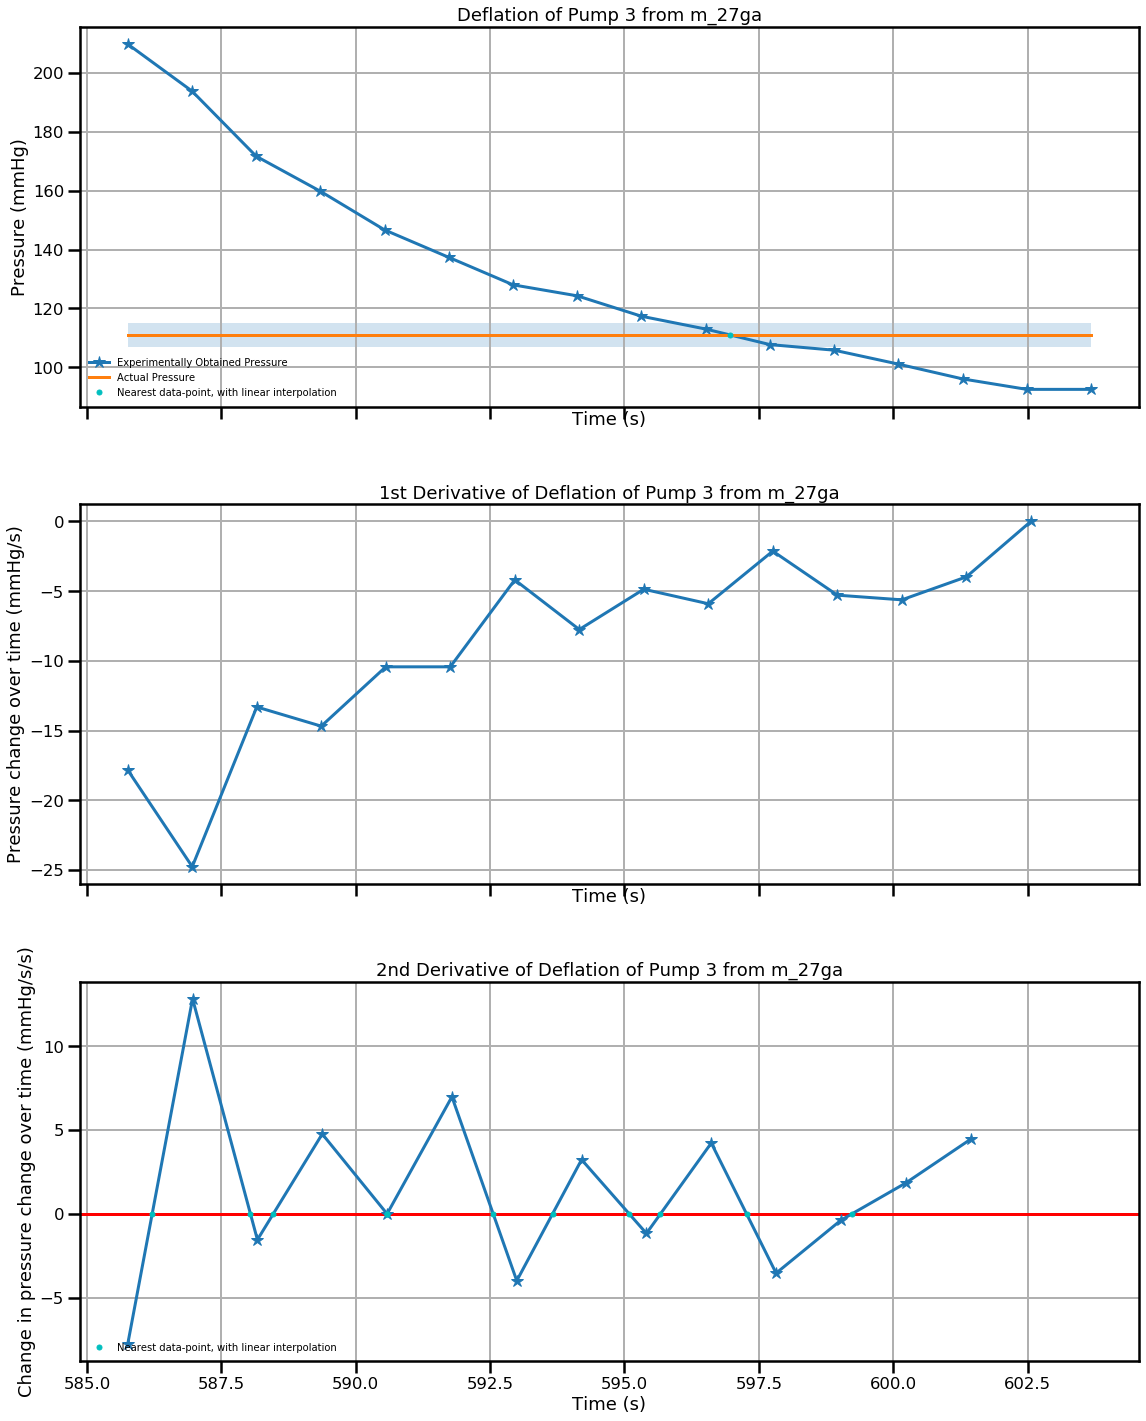

pump_4
[[637.06      ]
 [643.52901408]
 [645.09691932]
 [647.20516129]
 [648.33654076]
 [649.88854209]
 [651.21531062]
 [652.36      ]]


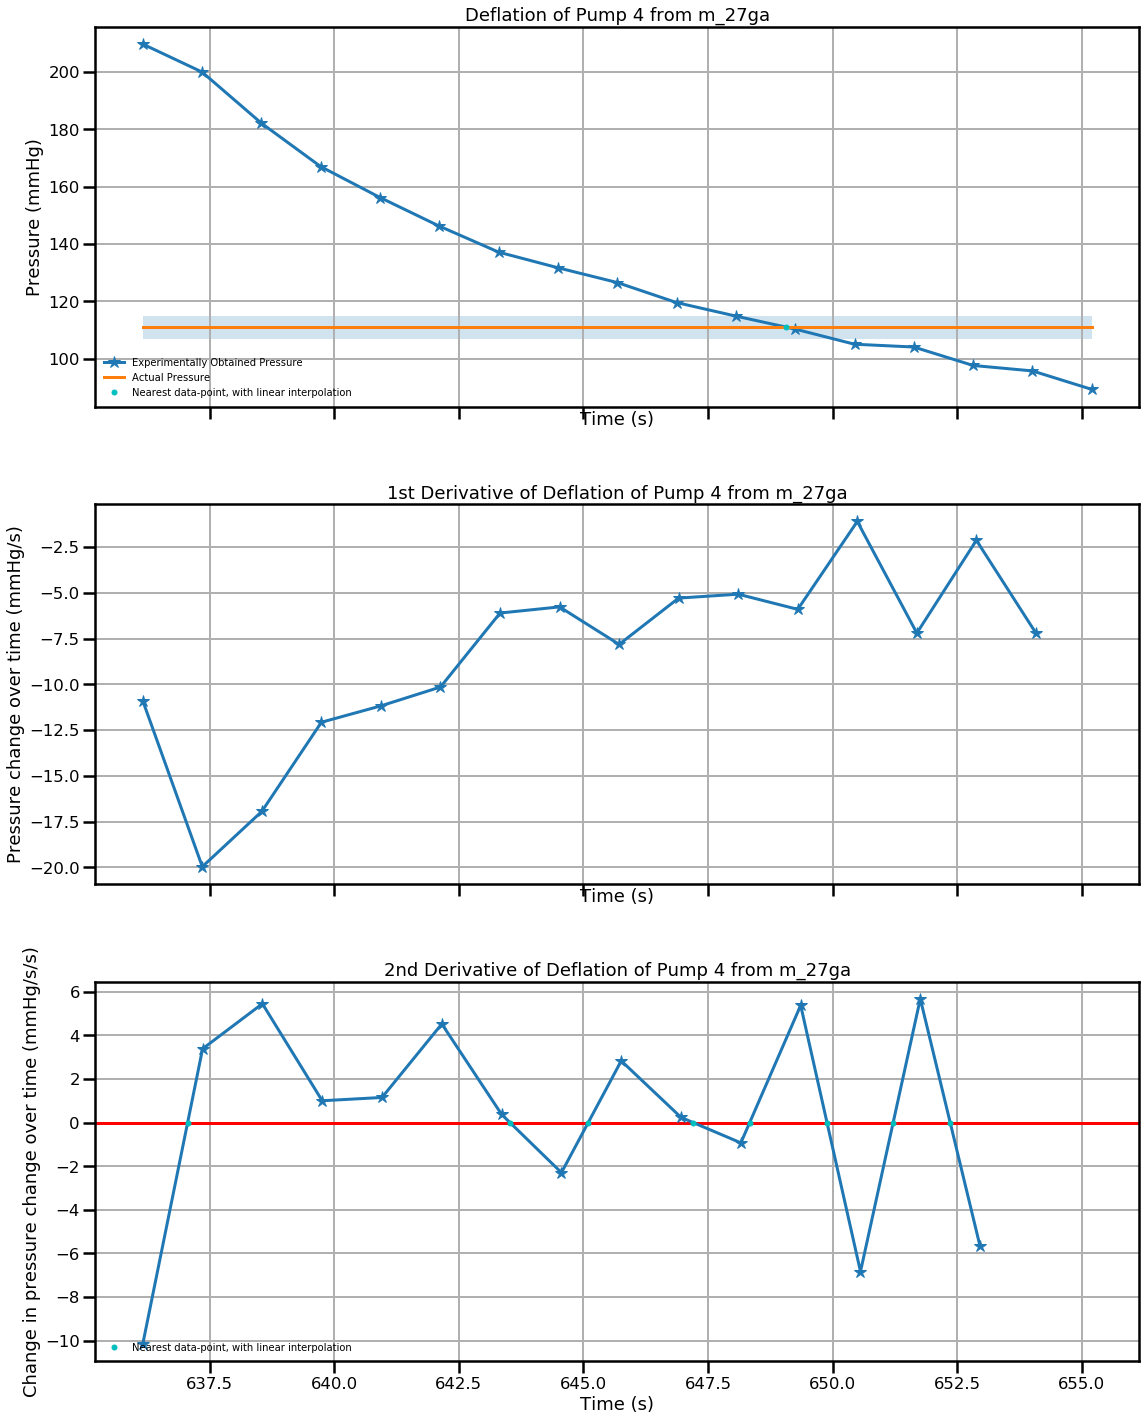

pump_5
[[770.34285383]
 [773.73677249]
 [775.0755    ]
 [777.41643016]
 [778.21171745]
 [779.68227273]
 [780.71067308]
 [782.93702916]
 [784.4945012 ]
 [785.97695988]
 [786.44366379]]


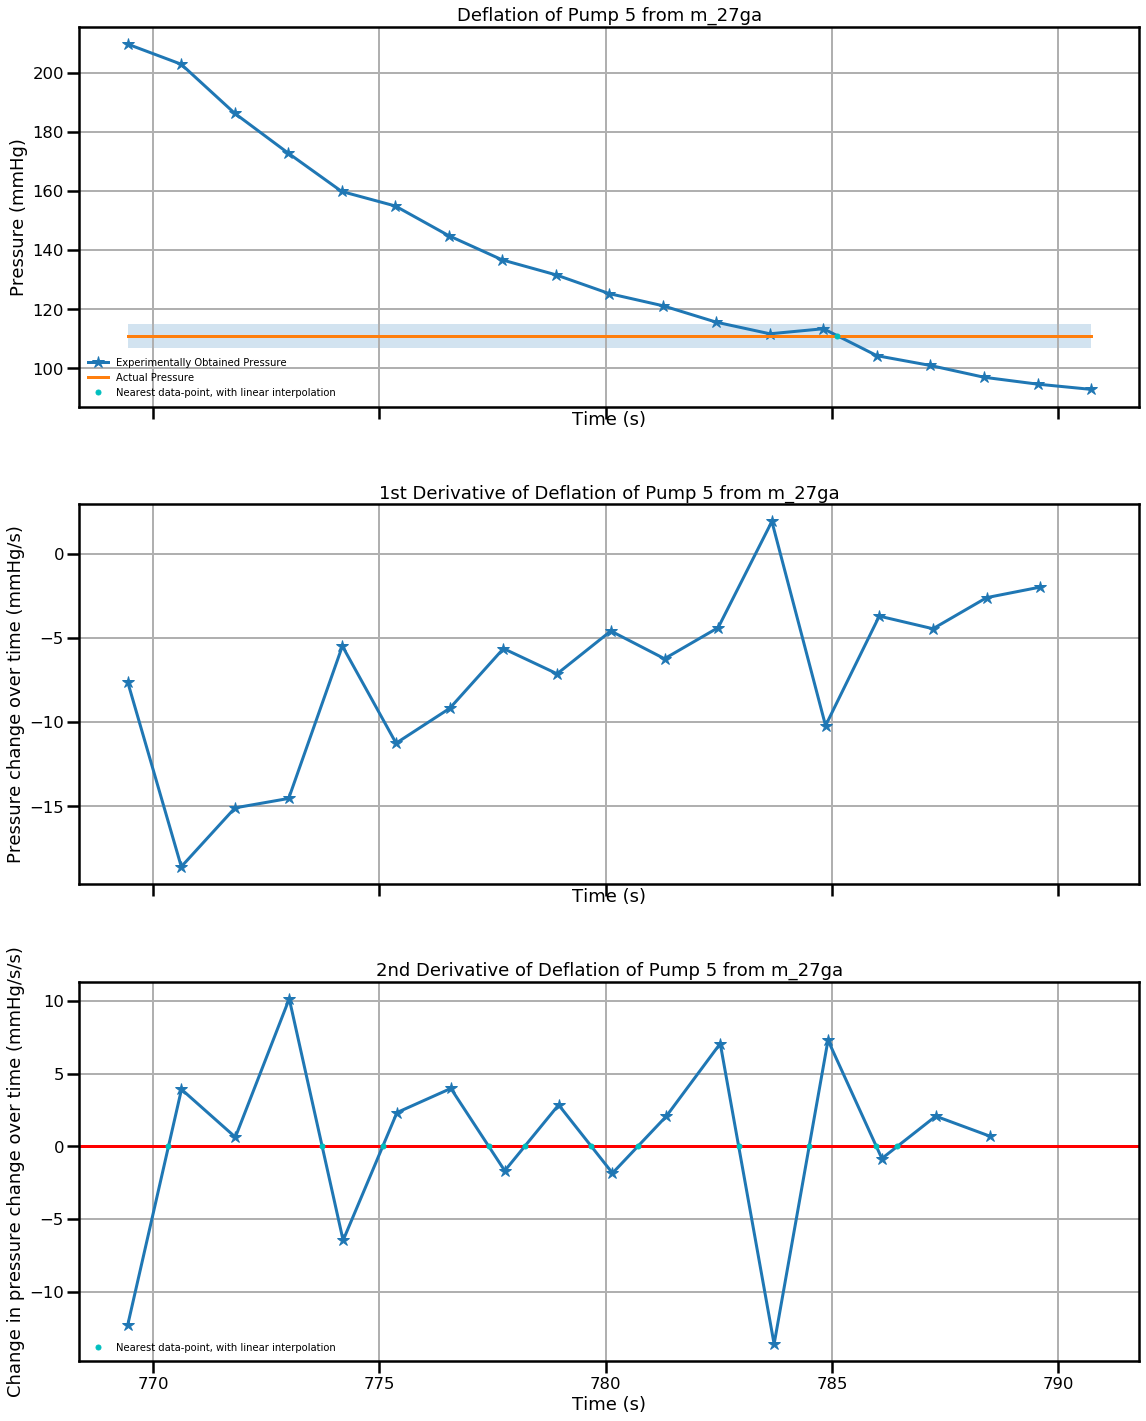

In [25]:
results = pd.DataFrame()
results['ID'] = all_gauges.keys()
results['Gauge'] = [each[2:4] for each in results['ID'].iloc[:]]
results['True_BP'] = [true_bp[each].mean() for each in true_bp]


results_intercepts = {}
for each_gauge in deflations:
    results_intercepts[each_gauge] = {}
    results_intercepts[each_gauge]['Idx_of_Exp_BP'] = {}
    results_intercepts[each_gauge]['Experimental_BP'] = {}
    results_intercepts[each_gauge]['2nd_deriv_at_approx_BP'] = {}
    results_intercepts[each_gauge]['POI_idx'] = {}
    results_intercepts[each_gauge]['BP_at_first_POI'] = {}
    results_intercepts[each_gauge]['BP_at_osc_POI'] = {}
    
    results_intercepts[each_gauge]['Error_BP_at_osc_POI'] = {}
    results_intercepts[each_gauge]['Error_BP_at_first_POI'] = {}
    results_intercepts[each_gauge]['Pump_No'] = {}
    results_intercepts[each_gauge]['Number_of_samples'] = {}

    print(each_gauge)
    
    # variable for iterating through the pairs an appropriate number of times
    len_pairs = int(len(deflations[each_gauge]['pairs'])/2)
        
    # looping through the indices, pairwise
    for counter, pair_start in enumerate(range(len_pairs)):
        print(str('pump_')+str(pair_start+1))
        

        results_intercepts[each_gauge]['ID'] = str(each_gauge)
        results_intercepts[each_gauge]['Gauge'] = str(each_gauge[2:4])
        results_intercepts[each_gauge]['Number_of_samples'] = len_pairs
        results_intercepts[each_gauge]['Pump_No'][str('pump_')+str(pair_start+1)] = pair_start+1
        results_intercepts[each_gauge]['True_BP'] = true_bp[each_gauge].mean()
        results_intercepts[each_gauge]['Experimental_BP'][str('pump_')+str(pair_start+1)] = []
        results_intercepts[each_gauge]['BP_at_osc_POI'][str('pump_')+str(pair_start+1)] = []
        results_intercepts[each_gauge]['BP_at_first_POI'][str('pump_')+str(pair_start+1)] = []

        
        results_intercepts[each_gauge]['Idx_of_Exp_BP'][str('pump_')+str(pair_start+1)] = []
        results_intercepts[each_gauge]['2nd_deriv_at_approx_BP'][str('pump_')+str(pair_start+1)] = []
        results_intercepts[each_gauge]['POI_idx'][str('pump_')+str(pair_start+1)] = []
        results_intercepts[each_gauge]['2nd_deriv_at_approx_BP'][str('pump_')+str(pair_start+1)] = []
        
        results_intercepts[each_gauge]['Error_BP_at_osc_POI'][str('pump_')+str(pair_start+1)] = []
        results_intercepts[each_gauge]['Error_BP_at_first_POI'][str('pump_')+str(pair_start+1)] = []
        

        
        # pick out pairs
        pairs = deflations[each_gauge]['pairs'][pair_start*2:(pair_start*2)+2]
        
        # raw dataset–be aware that indexing into this will require referring back to the pairwise indices
        df = np.array(all_gauges[each_gauge][pairs[0]:pairs[1]])
        
        # plot the first range of values–raw pressure data
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (16,20), sharex=True)
        ax1.set_title('Deflation of Pump {0} from {1}'.format(pair_start+1, each_gauge))
        # prepare time array, with the length of the indices, translate it into correct timing (with frequency)
        time = np.linspace(pairs[0], pairs[1], len(df))*1.12
        ax1.plot(time, df, '-*', label = 'Experimentally Obtained Pressure')
        # prepare error bars
        y_est = np.ones(len(time))*true_bp[each_gauge].mean()
        y_err = true_bp[each_gauge].std()
        ax1.plot(time, y_est, '-', label = 'Actual Pressure')
        ax1.fill_between(time, y_est - y_err, y_est + y_err, alpha=0.2)
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Pressure (mmHg)')
        ax1.grid(True)
        
        # calculate the intercepts using the raw data, and the mean value
        xc, yc = interpolated_intercept(time, df, y_est)
        results_intercepts[each_gauge]['Idx_of_Exp_BP'][str('pump_')+str(pair_start+1)] = xc[0][0]
        results_intercepts[each_gauge]['Experimental_BP'][str('pump_')+str(pair_start+1)] = yc[0][0]
        
        # finding the value of the second derivative at the approximate time at which the true blood pressure is measured
        approximate_sample_idx = (np.abs(time-xc)).argmin()
        results_intercepts[each_gauge]['2nd_deriv_at_approx_BP'][str('pump_')+str(pair_start+1)] = (df[approximate_sample_idx] - df[approximate_sample_idx - 1])*1.12
        
        # plot these values
        ax1.plot(xc, yc, 'co', ms=5, label='Nearest data-point, with linear interpolation')
        ax1.legend(frameon=False, fontsize=10, numpoints=1, loc='lower left')
        
        ax2.set_title('1st Derivative of Deflation of Pump {0} from {1}'.format(pair_start+1, each_gauge))
        first_deriv = derivs(df)
        time2 = np.linspace(pairs[0], pairs[1]-1, len(first_deriv))*1.12
        ax2.plot(time2, first_deriv, '-*')
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Pressure change over time (mmHg/s)')
        ax2.grid(True)
        
        second_deriv = derivs(derivs(df))
        ax3.set_title('2nd Derivative of Deflation of Pump {0} from {1}'.format(pair_start+1, each_gauge))
        time3 = np.linspace(pairs[0], pairs[1]-2, len(second_deriv))*1.12
        ax3.axhline(0, color='red', lw=3)
        ax3.plot(time3, derivs(derivs(df)), '-*')
        
        interpol = np.array(derivs(derivs(df))).reshape(-1)
        xc3, yc3 = interpolated_intercept(time3, interpol, time3*0)
        
        # if there is no intercept, xc3 returns 0
        if len(xc3) == 0:
            first_intercept_time = xc3
            # find index where bp’’ == 0 (the first time)
            # use the previous index and the next one over to find the derivative
            try:
                approximate_sample_idx2 = (np.abs(time3-first_intercept_time)).argmin() # this is the point for 
                approximate_hr_idx = (np.abs(time3-first_intercept_time)).argmax()
            except ValueError:
                approximate_sample_idx2 = -1000
            
            results_intercepts[each_gauge]['BP_at_first_POI'][str('pump_')+str(pair_start+1)] = np.nan
            results_intercepts[each_gauge]['BP_at_osc_POI'][str('pump_')+str(pair_start+1)] = np.nan
            results_intercepts[each_gauge]['POI_idx'][str('pump_')+str(pair_start+1)] = np.nan

        else:
            first_intercept_time = xc3[0]
            print(xc3)
            approximate_sample_idx2 = (np.abs(time3-first_intercept_time)).argmin() # need to add two because taking the derivative shortens the array by 2
            results_intercepts[each_gauge]['POI_idx'][str('pump_')+str(pair_start+1)] = approximate_sample_idx2 + pairs[0]

            
            # get the differences between each of their intervals
            try:
                smallest_diff_idx = np.diff(xc3.reshape(1,len(xc3))[0], n=1).argmin() # the index of the smallest value, when looking at the intercepts ONLY
#                 smallest_diff_idx = np.diff(xc3.reshape(1,len(xc3))[0], n=1).argmax() # the index of the largest value, when looking at the intercepts ONLY
                diff_idx = np.abs(time3 - xc3[smallest_diff_idx]).argmin()
                results_intercepts[each_gauge]['BP_at_osc_POI'][str('pump_')+str(pair_start+1)] = df[diff_idx]
            except ValueError:
                print('There is only one intercept')
                results_intercepts[each_gauge]['BP_at_osc_POI'][str('pump_')+str(pair_start+1)] = np.nan
            try:
                results_intercepts[each_gauge]['BP_at_first_POI'][str('pump_')+str(pair_start+1)] = df[approximate_sample_idx2]
            except:
                results_intercepts[each_gauge]['BP_at_first_POI'][str('pump_')+str(pair_start+1)] = df[approximate_sample_idx2 - 3]

        results_intercepts[each_gauge]['Error_BP_at_osc_POI'][str('pump_')+str(pair_start+1)] = np.abs((results_intercepts[each_gauge]['True_BP'] - results_intercepts[each_gauge]['BP_at_osc_POI'][str('pump_')+str(pair_start+1)])/results_intercepts[each_gauge]['True_BP'])
        results_intercepts[each_gauge]['Error_BP_at_first_POI'][str('pump_')+str(pair_start+1)] = np.abs((results_intercepts[each_gauge]['True_BP'] - results_intercepts[each_gauge]['BP_at_first_POI'][str('pump_')+str(pair_start+1)])/results_intercepts[each_gauge]['True_BP'])
        
        ax3.plot(xc3, yc3, 'co', ms=5, label='Nearest data-point, with linear interpolation')
        ax3.legend(frameon=False, fontsize=10, numpoints=1, loc='lower left')

        ax3.set_xlabel('Time (s)')
        ax3.set_ylabel('Change in pressure change over time (mmHg/s/s)')
        ax3.grid(True)
        
        plt.tight_layout(True)
        plt.show()
        
        if len_pairs - counter == 1:

            results_intercepts[each_gauge]['Pump_No']['Average'] = 'Average'
            results_intercepts[each_gauge]['Experimental_BP']['Average'] = np.nanmean(list(results_intercepts[each_gauge]['Experimental_BP'].values()))
            results_intercepts[each_gauge]['BP_at_osc_POI']['Average'] = np.nanmean(list(results_intercepts[each_gauge]['BP_at_osc_POI'].values()))
            results_intercepts[each_gauge]['BP_at_first_POI']['Average'] = np.nanmean(list(results_intercepts[each_gauge]['BP_at_first_POI'].values()))

            results_intercepts[each_gauge]['Idx_of_Exp_BP']['Average'] = np.nanmean(list(results_intercepts[each_gauge]['Idx_of_Exp_BP'].values()))
            results_intercepts[each_gauge]['2nd_deriv_at_approx_BP']['Average'] = np.nanmean(list(results_intercepts[each_gauge]['2nd_deriv_at_approx_BP'].values()))
            results_intercepts[each_gauge]['POI_idx']['Average'] = np.nanmean(list(results_intercepts[each_gauge]['POI_idx'].values()))

            results_intercepts[each_gauge]['Error_BP_at_osc_POI']['Average'] = np.nanmean(list(results_intercepts[each_gauge]['Error_BP_at_osc_POI'].values()))
            results_intercepts[each_gauge]['Error_BP_at_first_POI']['Average'] = np.nanmean(list(results_intercepts[each_gauge]['Error_BP_at_first_POI'].values()))
            
            
            
            results_intercepts[each_gauge]['Pump_No']['Standard_Dev'] = 'Standard_Dev'
            
#             print(np.array(list(results_intercepts[each_gauge]['BP_at_first_POI'].values())[:-1]))
            results_intercepts[each_gauge]['Experimental_BP']['Standard_Dev'] = np.nan
            results_intercepts[each_gauge]['BP_at_first_POI']['Standard_Dev'] = np.round(np.nanstd(np.asarray(list(results_intercepts[each_gauge]['BP_at_first_POI'].values()))[:-1]),decimals=3)
            results_intercepts[each_gauge]['BP_at_osc_POI']['Standard_Dev'] = np.round(np.nanstd(np.asarray(list(results_intercepts[each_gauge]['BP_at_osc_POI'].values()))[:-1], dtype=np.float64), decimals = 3 )

            results_intercepts[each_gauge]['Idx_of_Exp_BP']['Standard_Dev'] = np.round(np.nanstd(np.asarray(list(results_intercepts[each_gauge]['Idx_of_Exp_BP'].values()))[:-1], dtype=np.float64), decimals = 3)
            results_intercepts[each_gauge]['2nd_deriv_at_approx_BP']['Standard_Dev'] = np.round(np.nanstd(np.asarray(list(results_intercepts[each_gauge]['2nd_deriv_at_approx_BP'].values()))[:-1], dtype=np.float64), decimals = 3)
            results_intercepts[each_gauge]['POI_idx']['Standard_Dev'] = np.round(np.nanstd(np.asarray(list(results_intercepts[each_gauge]['POI_idx'].values()))[:-1], dtype=np.float64), decimals = 3)
            
#             print('this is the list from which stdev is calculated',list(results_intercepts[each_gauge]['BP_at_osc_POI'][:-1].values()))
#             print('this is the standard deviation',np.nanstd(np.asarray(list(results_intercepts[each_gauge]['BP_at_osc_POI'][:-1].values()), dtype= np.float64))
            results_intercepts[each_gauge]['Error_BP_at_osc_POI']['Standard_Dev'] = np.round(np.nanstd(np.asarray(list(results_intercepts[each_gauge]['BP_at_osc_POI'].values()))[:-1], dtype=np.float64), decimals = 3)
            results_intercepts[each_gauge]['Error_BP_at_first_POI']['Standard_Dev'] = np.round(np.nanstd(np.asarray(list(results_intercepts[each_gauge]['BP_at_first_POI'].values()))[:-1], dtype=np.float64), decimals = 3)
     
            
#             results_intercepts[each_gauge]['Standard_Dev_BP_at_osc_POI'] = np.std(results_intercepts[each_gauge]['Experimental_BP'], dtype=np.float64)
#             results_intercepts[each_gauge]['Standard_Dev_BP_at_first_POI'] = np.std(results_intercepts[each_gauge]['Experimental_BP'], dtype=np.float64)

            
        
    results_intercepts[each_gauge]['ID'] = str(each_gauge)
    results_intercepts[each_gauge]['Gauge'] = str(each_gauge[2:4])
    results_intercepts[each_gauge]['True_BP'] = true_bp[each_gauge].mean()
    


In [26]:
def set_pandas_display_options() -> None:
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 1000
    display.max_colwidth = 199
    display.width = None
    # display.precision = 2  # set as needed

set_pandas_display_options()

# pd.concat([[(pd.DataFrame(results_intercepts[each])) for each in results_intercepts]], keys=[[name for name in all_gauges]])

complete = pd.concat([pd.DataFrame(results_intercepts['a_15ga']),pd.DataFrame(results_intercepts['a_18ga']),pd.DataFrame(results_intercepts['a_20ga']),pd.DataFrame(results_intercepts['a_21ga']),pd.DataFrame(results_intercepts['a_22ga']),pd.DataFrame(results_intercepts['a_23ga']),pd.DataFrame(results_intercepts['a_25ga']),pd.DataFrame(results_intercepts['c_23ga']),pd.DataFrame(results_intercepts['c_25ga']),pd.DataFrame(results_intercepts['a_27ga']),pd.DataFrame(results_intercepts['c_30ga']),pd.DataFrame(results_intercepts['m_27ga'])], keys=['a_15ga', 'a_18ga', 'a_20ga', 'a_21ga', 'a_22ga', 'a_23ga', 'a_25ga', 'c_23ga', 'c_25ga', 'a_27ga', 'c_30ga', 'm_27ga'])

complete
complete.to_excel("bloodpressure_021220.xlsx") 

In [17]:
complete[complete['Pump_No'] == 'Average']

Idx_of_Exp_BP  Experimental_BP  2nd_deriv_at_approx_BP  \
a_15ga Average     264.423088       122.500000              153.162240   
a_18ga Average     173.232212       122.500000             -130.237333   
a_20ga Average     148.700038       106.000000              -99.467200   
a_21ga Average     238.525880       112.500000              -62.514667   
a_22ga Average     126.765591       112.500000              -31.774400   
a_23ga Average     443.929055       111.000000              -21.470400   
a_25ga Average     506.841899       118.500000              -13.630400   
c_23ga Average     145.744861       127.000000              -22.391040   
c_25ga Average     359.828718       115.666667              -10.632533   
a_27ga Average     988.363847       124.000000               -4.835600   
c_30ga Average     567.928979       132.500000              -40.846400   
m_27ga Average     507.006821       111.000000               -3.935680   

                   POI_idx  BP_at_first_POI  BP_at_osc_POI  \
a_15ga Average         NaN              NaN            NaN   
a_18ga Average         NaN              NaN            NaN   
a_20ga Average  233.000000       201.890000            NaN   
a_21ga Average  227.500000       198.330000            NaN   
a_22ga Average  119.000000       204.227500     105.730000   
a_23ga Average  392.666667       196.636667     140.186667   
a_25ga Average  449.000000       175.710000     159.543333   
c_23ga Average  128.800000       154.062000     128.388000   
c_25ga Average  315.666667       199.743333     126.490000   
a_27ga Average  870.500000       205.177500     122.357500   
c_30ga Average  421.333333       204.890000     113.933333   
m_27ga Average  441.600000       205.768000     128.782000   

                Error_BP_at_osc_POI  Error_BP_at_first_POI  Pump_No  \
a_15ga Average                  NaN                    NaN  Average   
a_18ga Average                  NaN                    NaN  Average   
a_20ga Average                  NaN               0.904623  Average   
a_21ga Average                  NaN               0.762933  Average   
a_22ga Average             0.060178               0.815356  Average   
a_23ga Average             0.262943               0.771502  Average   
a_25ga Average             0.346357               0.482785  Average   
c_23ga Average             0.062110               0.264268  Average   
c_25ga Average             0.093573               0.726888  Average   
a_27ga Average             0.024778               0.654657  Average   
c_30ga Average             0.140126               0.546340  Average   
m_27ga Average             0.184486               0.853766  Average   

                Number_of_samples      ID Gauge     True_BP  
a_15ga Average                  5  a_15ga    15  122.500000  
a_18ga Average                  3  a_18ga    18  122.500000  
a_20ga Average                  4  a_20ga    20  106.000000  
a_21ga Average                  3  a_21ga    21  112.500000  
a_22ga Average                  5  a_22ga    22  112.500000  
a_23ga Average                  3  a_23ga    23  111.000000  
a_25ga Average                  3  a_25ga    25  118.500000  
c_23ga Average                  5  c_23ga    23  127.000000  
c_25ga Average                  3  c_25ga    25  115.666667  
a_27ga Average                  4  a_27ga    27  124.000000  
c_30ga Average                  4  c_30ga    30  132.500000  
m_27ga Average                  5  m_27ga    27  111.000000

In [18]:
complete[complete['Pump_No'] == 'Standard_Dev']

Idx_of_Exp_BP  Experimental_BP  2nd_deriv_at_approx_BP  \
a_15ga Standard_Dev         41.233              NaN                 149.295   
a_18ga Standard_Dev         70.284              NaN                  21.976   
a_20ga Standard_Dev         69.882              NaN                  21.646   
a_21ga Standard_Dev         31.357              NaN                  17.132   
a_22ga Standard_Dev         61.861              NaN                   3.452   
a_23ga Standard_Dev         54.125              NaN                   1.967   
a_25ga Standard_Dev        171.286              NaN                   1.239   
c_23ga Standard_Dev         90.419              NaN                   7.140   
c_25ga Standard_Dev        125.972              NaN                   0.551   
a_27ga Standard_Dev        342.397              NaN                   1.406   
c_30ga Standard_Dev        263.729              NaN                  63.500   
m_27ga Standard_Dev        253.753              NaN                   2.968   

                     POI_idx  BP_at_first_POI  BP_at_osc_POI  \
a_15ga Standard_Dev      NaN              NaN            NaN   
a_18ga Standard_Dev      NaN              NaN            NaN   
a_20ga Standard_Dev    0.000            0.000            NaN   
a_21ga Standard_Dev   18.500           11.330            NaN   
a_22ga Standard_Dev   58.494            5.434          0.000   
a_23ga Standard_Dev   48.286            4.777         39.077   
a_25ga Standard_Dev  153.799           36.865         36.369   
c_23ga Standard_Dev   80.524           33.673          9.375   
c_25ga Standard_Dev  112.678            6.611          0.920   
a_27ga Standard_Dev  307.030            5.713          2.609   
c_30ga Standard_Dev  237.011            5.544          3.540   
m_27ga Standard_Dev  226.436            3.839         15.552   

                     Error_BP_at_osc_POI  Error_BP_at_first_POI       Pump_No  \
a_15ga Standard_Dev                  NaN                    NaN  Standard_Dev   
a_18ga Standard_Dev                  NaN                    NaN  Standard_Dev   
a_20ga Standard_Dev                  NaN                  0.000  Standard_Dev   
a_21ga Standard_Dev                  NaN                  9.251  Standard_Dev   
a_22ga Standard_Dev                0.000                  4.860  Standard_Dev   
a_23ga Standard_Dev               33.842                  4.137  Standard_Dev   
a_25ga Standard_Dev               31.497                 31.926  Standard_Dev   
c_23ga Standard_Dev                8.559                 30.739  Standard_Dev   
c_25ga Standard_Dev                0.751                  5.725  Standard_Dev   
a_27ga Standard_Dev                2.334                  5.110  Standard_Dev   
c_30ga Standard_Dev                3.066                  4.801  Standard_Dev   
m_27ga Standard_Dev               14.197                  3.504  Standard_Dev   

                     Number_of_samples      ID Gauge     True_BP  
a_15ga Standard_Dev                  5  a_15ga    15  122.500000  
a_18ga Standard_Dev                  3  a_18ga    18  122.500000  
a_20ga Standard_Dev                  4  a_20ga    20  106.000000  
a_21ga Standard_Dev                  3  a_21ga    21  112.500000  
a_22ga Standard_Dev                  5  a_22ga    22  112.500000  
a_23ga Standard_Dev                  3  a_23ga    23  111.000000  
a_25ga Standard_Dev                  3  a_25ga    25  118.500000  
c_23ga Standard_Dev                  5  c_23ga    23  127.000000  
c_25ga Standard_Dev                  3  c_25ga    25  115.666667  
a_27ga Standard_Dev                  4  a_27ga    27  124.000000  
c_30ga Standard_Dev                  4  c_30ga    30  132.500000  
m_27ga Standard_Dev                  5  m_27ga    27  111.000000

It seems that the data sets with the smallest standard error are those belonging to the smallest gauges. I am particularly interested in the error in my blood pressure estimations made with taking the oscillating nature of blood pressure into account. The 30ga syringe had a ±3 mmHg standard deviation in the error rates, and a ±3.5 mmHg standard deviation in the actual measurement of blood pressure itself.

In [19]:
complete[complete['Pump_No'] == 'Standard_Dev'].groupby('Gauge').mean()

Idx_of_Exp_BP  Experimental_BP  2nd_deriv_at_approx_BP   POI_idx  \
Gauge                                                                     
15            41.233              NaN                149.2950       NaN   
18            70.284              NaN                 21.9760       NaN   
20            69.882              NaN                 21.6460    0.0000   
21            31.357              NaN                 17.1320   18.5000   
22            61.861              NaN                  3.4520   58.4940   
23            72.272              NaN                  4.5535   64.4050   
25           148.629              NaN                  0.8950  133.2385   
27           298.075              NaN                  2.1870  266.7330   
30           263.729              NaN                 63.5000  237.0110   

       BP_at_first_POI  BP_at_osc_POI  Error_BP_at_osc_POI  \
Gauge                                                        
15                 NaN            NaN                  NaN   
18                 NaN            NaN                  NaN   
20               0.000            NaN                  NaN   
21              11.330            NaN                  NaN   
22               5.434         0.0000               0.0000   
23              19.225        24.2260              21.2005   
25              21.738        18.6445              16.1240   
27               4.776         9.0805               8.2655   
30               5.544         3.5400               3.0660   

       Error_BP_at_first_POI  Number_of_samples     True_BP  
Gauge                                                        
15                       NaN                5.0  122.500000  
18                       NaN                3.0  122.500000  
20                    0.0000                4.0  106.000000  
21                    9.2510                3.0  112.500000  
22                    4.8600                5.0  112.500000  
23                   17.4380                4.0  119.000000  
25                   18.8255                3.0  117.083333  
27                    4.3070                4.5  117.500000  
30                    4.8010                4.0  132.500000

In [20]:
complete[complete['Pump_No'] == 'Average']

Idx_of_Exp_BP  Experimental_BP  2nd_deriv_at_approx_BP  \
a_15ga Average     264.423088       122.500000              153.162240   
a_18ga Average     173.232212       122.500000             -130.237333   
a_20ga Average     148.700038       106.000000              -99.467200   
a_21ga Average     238.525880       112.500000              -62.514667   
a_22ga Average     126.765591       112.500000              -31.774400   
a_23ga Average     443.929055       111.000000              -21.470400   
a_25ga Average     506.841899       118.500000              -13.630400   
c_23ga Average     145.744861       127.000000              -22.391040   
c_25ga Average     359.828718       115.666667              -10.632533   
a_27ga Average     988.363847       124.000000               -4.835600   
c_30ga Average     567.928979       132.500000              -40.846400   
m_27ga Average     507.006821       111.000000               -3.935680   

                   POI_idx  BP_at_first_POI  BP_at_osc_POI  \
a_15ga Average         NaN              NaN            NaN   
a_18ga Average         NaN              NaN            NaN   
a_20ga Average  233.000000       201.890000            NaN   
a_21ga Average  227.500000       198.330000            NaN   
a_22ga Average  119.000000       204.227500     105.730000   
a_23ga Average  392.666667       196.636667     140.186667   
a_25ga Average  449.000000       175.710000     159.543333   
c_23ga Average  128.800000       154.062000     128.388000   
c_25ga Average  315.666667       199.743333     126.490000   
a_27ga Average  870.500000       205.177500     122.357500   
c_30ga Average  421.333333       204.890000     113.933333   
m_27ga Average  441.600000       205.768000     128.782000   

                Error_BP_at_osc_POI  Error_BP_at_first_POI  Pump_No  \
a_15ga Average                  NaN                    NaN  Average   
a_18ga Average                  NaN                    NaN  Average   
a_20ga Average                  NaN               0.904623  Average   
a_21ga Average                  NaN               0.762933  Average   
a_22ga Average             0.060178               0.815356  Average   
a_23ga Average             0.262943               0.771502  Average   
a_25ga Average             0.346357               0.482785  Average   
c_23ga Average             0.062110               0.264268  Average   
c_25ga Average             0.093573               0.726888  Average   
a_27ga Average             0.024778               0.654657  Average   
c_30ga Average             0.140126               0.546340  Average   
m_27ga Average             0.184486               0.853766  Average   

                Number_of_samples      ID Gauge     True_BP  
a_15ga Average                  5  a_15ga    15  122.500000  
a_18ga Average                  3  a_18ga    18  122.500000  
a_20ga Average                  4  a_20ga    20  106.000000  
a_21ga Average                  3  a_21ga    21  112.500000  
a_22ga Average                  5  a_22ga    22  112.500000  
a_23ga Average                  3  a_23ga    23  111.000000  
a_25ga Average                  3  a_25ga    25  118.500000  
c_23ga Average                  5  c_23ga    23  127.000000  
c_25ga Average                  3  c_25ga    25  115.666667  
a_27ga Average                  4  a_27ga    27  124.000000  
c_30ga Average                  4  c_30ga    30  132.500000  
m_27ga Average                  5  m_27ga    27  111.000000

In [21]:
[display(pd.DataFrame(results_intercepts[each])) for each in results_intercepts]

all_results = pd.DataFrame()
# for each in results_intercepts:
#     all_results.append(results_intercepts[each], ignore_index=True)


Idx_of_Exp_BP  Experimental_BP  2nd_deriv_at_approx_BP  POI_idx  \
pump_1           195.598198            122.5               228.28960      NaN   
pump_2           247.109816            122.5               226.09440      NaN   
pump_3           270.922456            122.5              -145.42080      NaN   
pump_4           293.041622            122.5               227.87520      NaN   
pump_5           315.443346            122.5               228.97280      NaN   
Average          264.423088            122.5               153.16224      NaN   
Standard_Dev      41.233000              NaN               149.29500      NaN   

              BP_at_first_POI  BP_at_osc_POI  Error_BP_at_osc_POI  \
pump_1                    NaN            NaN                  NaN   
pump_2                    NaN            NaN                  NaN   
pump_3                    NaN            NaN                  NaN   
pump_4                    NaN            NaN                  NaN   
pump_5                    NaN            NaN                  NaN   
Average                   NaN            NaN                  NaN   
Standard_Dev              NaN            NaN                  NaN   

              Error_BP_at_first_POI       Pump_No  Number_of_samples      ID  \
pump_1                          NaN             1                  5  a_15ga   
pump_2                          NaN             2                  5  a_15ga   
pump_3                          NaN             3                  5  a_15ga   
pump_4                          NaN             4                  5  a_15ga   
pump_5                          NaN             5                  5  a_15ga   
Average                         NaN       Average                  5  a_15ga   
Standard_Dev                    NaN  Standard_Dev                  5  a_15ga   

             Gauge  True_BP  
pump_1          15    122.5  
pump_2          15    122.5  
pump_3          15    122.5  
pump_4          15    122.5  
pump_5          15    122.5  
Average         15    122.5  
Standard_Dev    15    122.5

Idx_of_Exp_BP  Experimental_BP  2nd_deriv_at_approx_BP  POI_idx  \
pump_1            87.609364            122.5              -99.803200      NaN   
pump_2           172.326001            122.5             -150.908800      NaN   
pump_3           259.761271            122.5             -140.000000      NaN   
Average          173.232212            122.5             -130.237333      NaN   
Standard_Dev      70.284000              NaN               21.976000      NaN   

              BP_at_first_POI  BP_at_osc_POI  Error_BP_at_osc_POI  \
pump_1                    NaN            NaN                  NaN   
pump_2                    NaN            NaN                  NaN   
pump_3                    NaN            NaN                  NaN   
Average                   NaN            NaN                  NaN   
Standard_Dev              NaN            NaN                  NaN   

              Error_BP_at_first_POI       Pump_No  Number_of_samples      ID  \
pump_1                          NaN             1                  3  a_18ga   
pump_2                          NaN             2                  3  a_18ga   
pump_3                          NaN             3                  3  a_18ga   
Average                         NaN       Average                  3  a_18ga   
Standard_Dev                    NaN  Standard_Dev                  3  a_18ga   

             Gauge  True_BP  
pump_1          18    122.5  
pump_2          18    122.5  
pump_3          18    122.5  
Average         18    122.5  
Standard_Dev    18    122.5

Idx_of_Exp_BP  Experimental_BP  2nd_deriv_at_approx_BP  POI_idx  \
pump_1            77.212268            106.0                -63.2464      NaN   
pump_2           110.397427            106.0               -102.8944      NaN   
pump_3           144.732850            106.0               -118.3952      NaN   
pump_4           262.457606            106.0               -113.3328    233.0   
Average          148.700038            106.0                -99.4672    233.0   
Standard_Dev      69.882000              NaN                 21.6460      0.0   

              BP_at_first_POI  BP_at_osc_POI  Error_BP_at_osc_POI  \
pump_1                    NaN            NaN                  NaN   
pump_2                    NaN            NaN                  NaN   
pump_3                    NaN            NaN                  NaN   
pump_4                 201.89            NaN                  NaN   
Average                201.89            NaN                  NaN   
Standard_Dev             0.00            NaN                  NaN   

              Error_BP_at_first_POI       Pump_No  Number_of_samples      ID  \
pump_1                          NaN             1                  4  a_20ga   
pump_2                          NaN             2                  4  a_20ga   
pump_3                          NaN             3                  4  a_20ga   
pump_4                     0.904623             4                  4  a_20ga   
Average                    0.904623       Average                  4  a_20ga   
Standard_Dev               0.000000  Standard_Dev                  4  a_20ga   

             Gauge  True_BP  
pump_1          20    106.0  
pump_2          20    106.0  
pump_3          20    106.0  
pump_4          20    106.0  
Average         20    106.0  
Standard_Dev    20    106.0

Idx_of_Exp_BP  Experimental_BP  2nd_deriv_at_approx_BP  POI_idx  \
pump_1           201.525892            112.5              -38.550400      NaN   
pump_2           235.857449            112.5              -77.582400    209.0   
pump_3           278.194299            112.5              -71.411200    246.0   
Average          238.525880            112.5              -62.514667    227.5   
Standard_Dev      31.357000              NaN               17.132000     18.5   

              BP_at_first_POI  BP_at_osc_POI  Error_BP_at_osc_POI  \
pump_1                    NaN            NaN                  NaN   
pump_2                 187.00            NaN                  NaN   
pump_3                 209.66            NaN                  NaN   
Average                198.33            NaN                  NaN   
Standard_Dev            11.33            NaN                  NaN   

              Error_BP_at_first_POI       Pump_No  Number_of_samples      ID  \
pump_1                          NaN             1                  3  a_21ga   
pump_2                     0.662222             2                  3  a_21ga   
pump_3                     0.863644             3                  3  a_21ga   
Average                    0.762933       Average                  3  a_21ga   
Standard_Dev               9.251000  Standard_Dev                  3  a_21ga   

             Gauge  True_BP  
pump_1          21    112.5  
pump_2          21    112.5  
pump_3          21    112.5  
Average         21    112.5  
Standard_Dev    21    112.5

Idx_of_Exp_BP  Experimental_BP  2nd_deriv_at_approx_BP  POI_idx  \
pump_1            36.234140            112.5                -35.4704   30.000   
pump_2            88.001701            112.5                -36.3552      NaN   
pump_3           126.769217            112.5                -30.0384  110.000   
pump_4           168.206013            112.5                -27.9888  147.000   
pump_5           214.616883            112.5                -29.0192  189.000   
Average          126.765591            112.5                -31.7744  119.000   
Standard_Dev      61.861000              NaN                  3.4520   58.494   

              BP_at_first_POI  BP_at_osc_POI  Error_BP_at_osc_POI  \
pump_1               198.9500            NaN                  NaN   
pump_2                    NaN            NaN                  NaN   
pump_3               209.6600            NaN                  NaN   
pump_4               209.6600         105.73             0.060178   
pump_5               198.6400            NaN                  NaN   
Average              204.2275         105.73             0.060178   
Standard_Dev           5.4340           0.00             0.000000   

              Error_BP_at_first_POI       Pump_No  Number_of_samples      ID  \
pump_1                     0.768444             1                  5  a_22ga   
pump_2                          NaN             2                  5  a_22ga   
pump_3                     0.863644             3                  5  a_22ga   
pump_4                     0.863644             4                  5  a_22ga   
pump_5                     0.765689             5                  5  a_22ga   
Average                    0.815356       Average                  5  a_22ga   
Standard_Dev               4.860000  Standard_Dev                  5  a_22ga   

             Gauge  True_BP  
pump_1          22    112.5  
pump_2          22    112.5  
pump_3          22    112.5  
pump_4          22    112.5  
pump_5          22    112.5  
Average         22    112.5  
Standard_Dev    22    112.5

Idx_of_Exp_BP  Experimental_BP  2nd_deriv_at_approx_BP  \
pump_1           380.398348            111.0                -20.7872   
pump_2           438.719534            111.0                -24.1472   
pump_3           512.669283            111.0                -19.4768   
Average          443.929055            111.0                -21.4704   
Standard_Dev      54.125000              NaN                  1.9670   

                 POI_idx  BP_at_first_POI  BP_at_osc_POI  Error_BP_at_osc_POI  \
pump_1        336.000000       191.470000     112.400000             0.012613   
pump_2        388.000000       202.990000     112.710000             0.015405   
pump_3        454.000000       195.450000     195.450000             0.760811   
Average       392.666667       196.636667     140.186667             0.262943   
Standard_Dev   48.286000         4.777000      39.077000            33.842000   

              Error_BP_at_first_POI       Pump_No  Number_of_samples      ID  \
pump_1                     0.724955             1                  3  a_23ga   
pump_2                     0.828739             2                  3  a_23ga   
pump_3                     0.760811             3                  3  a_23ga   
Average                    0.771502       Average                  3  a_23ga   
Standard_Dev               4.137000  Standard_Dev                  3  a_23ga   

             Gauge  True_BP  
pump_1          23    111.0  
pump_2          23    111.0  
pump_3          23    111.0  
Average         23    111.0  
Standard_Dev    23    111.0

Idx_of_Exp_BP  Experimental_BP  2nd_deriv_at_approx_BP  POI_idx  \
pump_1           267.029306            118.5                -15.3664  234.000   
pump_2           597.157046            118.5                -12.5552  528.000   
pump_3           656.339344            118.5                -12.9696  585.000   
Average          506.841899            118.5                -13.6304  449.000   
Standard_Dev     171.286000              NaN                  1.2390  153.799   

              BP_at_first_POI  BP_at_osc_POI  Error_BP_at_osc_POI  \
pump_1                193.000     144.500000             0.219409   
pump_2                209.660     209.660000             0.769283   
pump_3                124.470     124.470000             0.050380   
Average               175.710     159.543333             0.346357   
Standard_Dev           36.865      36.369000            31.497000   

              Error_BP_at_first_POI       Pump_No  Number_of_samples      ID  \
pump_1                     0.628692             1                  3  a_25ga   
pump_2                     0.769283             2                  3  a_25ga   
pump_3                     0.050380             3                  3  a_25ga   
Average                    0.482785       Average                  3  a_25ga   
Standard_Dev              31.926000  Standard_Dev                  3  a_25ga   

             Gauge  True_BP  
pump_1          25    118.5  
pump_2          25    118.5  
pump_3          25    118.5  
Average         25    118.5  
Standard_Dev    25    118.5

Idx_of_Exp_BP  Experimental_BP  2nd_deriv_at_approx_BP  POI_idx  \
pump_1            26.029134            127.0               -23.66560   24.000   
pump_2            79.179744            127.0               -27.85440   68.000   
pump_3           130.500123            127.0               -31.89760  114.000   
pump_4           218.429296            127.0               -13.51840  194.000   
pump_5           274.586010            127.0               -15.01920  244.000   
Average          145.744861            127.0               -22.39104  128.800   
Standard_Dev      90.419000              NaN                 7.14000   80.524   

              BP_at_first_POI  BP_at_osc_POI  Error_BP_at_osc_POI  \
pump_1                110.750        110.750             0.127953   
pump_2                193.430        131.020             0.031654   
pump_3                193.980        128.020             0.008031   
pump_4                134.820        134.820             0.061575   
pump_5                137.330        137.330             0.081339   
Average               154.062        128.388             0.062110   
Standard_Dev           33.673          9.375             8.559000   

              Error_BP_at_first_POI       Pump_No  Number_of_samples      ID  \
pump_1                     0.127953             1                  5  c_23ga   
pump_2                     0.523071             2                  5  c_23ga   
pump_3                     0.527402             3                  5  c_23ga   
pump_4                     0.061575             4                  5  c_23ga   
pump_5                     0.081339             5                  5  c_23ga   
Average                    0.264268       Average                  5  c_23ga   
Standard_Dev              30.739000  Standard_Dev                  5  c_23ga   

             Gauge  True_BP  
pump_1          23    127.0  
pump_2          23    127.0  
pump_3          23    127.0  
pump_4          23    127.0  
pump_5          23    127.0  
Average         23    127.0  
Standard_Dev    23    127.0

Idx_of_Exp_BP  Experimental_BP  2nd_deriv_at_approx_BP  \
pump_1           229.503594       115.666667              -10.841600   
pump_2           319.801523       115.666667              -11.177600   
pump_3           530.181037       115.666667               -9.878400   
Average          359.828718       115.666667              -10.632533   
Standard_Dev     125.972000              NaN                0.551000   

                 POI_idx  BP_at_first_POI  BP_at_osc_POI  Error_BP_at_osc_POI  \
pump_1        199.000000       208.750000         127.41             0.101527   
pump_2        280.000000       197.410000         125.57             0.085620   
pump_3        468.000000       193.070000            NaN                  NaN   
Average       315.666667       199.743333         126.49             0.093573   
Standard_Dev  112.678000         6.611000           0.92             0.751000   

              Error_BP_at_first_POI       Pump_No  Number_of_samples      ID  \
pump_1                     0.804755             1                  3  c_25ga   
pump_2                     0.706715             2                  3  c_25ga   
pump_3                     0.669193             3                  3  c_25ga   
Average                    0.726888       Average                  3  c_25ga   
Standard_Dev               5.725000  Standard_Dev                  3  c_25ga   

             Gauge     True_BP  
pump_1          25  115.666667  
pump_2          25  115.666667  
pump_3          25  115.666667  
Average         25  115.666667  
Standard_Dev    25  115.666667

Idx_of_Exp_BP  Experimental_BP  2nd_deriv_at_approx_BP  POI_idx  \
pump_1           513.114483            124.0                 -4.8720   444.00   
pump_2           845.049482            124.0                 -2.8112   742.00   
pump_3          1172.681584            124.0                 -6.7872  1037.00   
pump_4          1422.609839            124.0                 -4.8720  1259.00   
Average          988.363847            124.0                 -4.8356   870.50   
Standard_Dev     342.397000              NaN                  1.4060   307.03   

              BP_at_first_POI  BP_at_osc_POI  Error_BP_at_osc_POI  \
pump_1               209.6600       121.0400             0.023871   
pump_2               205.8700       120.4900             0.028306   
pump_3               195.6400       121.0400             0.023871   
pump_4               209.5400       126.8600             0.023065   
Average              205.1775       122.3575             0.024778   
Standard_Dev           5.7130         2.6090             2.334000   

              Error_BP_at_first_POI       Pump_No  Number_of_samples      ID  \
pump_1                     0.690806             1                  4  a_27ga   
pump_2                     0.660242             2                  4  a_27ga   
pump_3                     0.577742             3                  4  a_27ga   
pump_4                     0.689839             4                  4  a_27ga   
Average                    0.654657       Average                  4  a_27ga   
Standard_Dev               5.110000  Standard_Dev                  4  a_27ga   

             Gauge  True_BP  
pump_1          27    124.0  
pump_2          27    124.0  
pump_3          27    124.0  
pump_4          27    124.0  
Average         27    124.0  
Standard_Dev    27    124.0

Idx_of_Exp_BP  Experimental_BP  2nd_deriv_at_approx_BP  \
pump_1           201.968958            132.5                 -8.7808   
pump_2           435.483648            132.5                 -0.3360   
pump_3           781.496314            132.5               -150.7072   
pump_4           852.766997            132.5                 -3.5616   
Average          567.928979            132.5                -40.8464   
Standard_Dev     263.729000              NaN                 63.5000   

                 POI_idx  BP_at_first_POI  BP_at_osc_POI  Error_BP_at_osc_POI  \
pump_1        164.000000          197.050     109.400000             0.174340   
pump_2        364.000000          208.870     114.360000             0.136906   
pump_3               NaN              NaN            NaN                  NaN   
pump_4        736.000000          208.750     118.040000             0.109132   
Average       421.333333          204.890     113.933333             0.140126   
Standard_Dev  237.011000            5.544       3.540000             3.066000   

              Error_BP_at_first_POI       Pump_No  Number_of_samples      ID  \
pump_1                     0.487170             1                  4  c_30ga   
pump_2                     0.576377             2                  4  c_30ga   
pump_3                          NaN             3                  4  c_30ga   
pump_4                     0.575472             4                  4  c_30ga   
Average                    0.546340       Average                  4  c_30ga   
Standard_Dev               4.801000  Standard_Dev                  4  c_30ga   

             Gauge  True_BP  
pump_1          30    132.5  
pump_2          30    132.5  
pump_3          30    132.5  
pump_4          30    132.5  
Average         30    132.5  
Standard_Dev    30    132.5

Idx_of_Exp_BP  Experimental_BP  2nd_deriv_at_approx_BP  POI_idx  \
pump_1            44.320093            111.0                -5.34240   28.000   
pump_2           459.555319            111.0                -6.31680  400.000   
pump_3           596.969918            111.0                -4.86080  523.000   
pump_4           649.071369            111.0                -5.07360  569.000   
pump_5           785.117407            111.0                 1.91520  688.000   
Average          507.006821            111.0                -3.93568  441.600   
Standard_Dev     253.753000              NaN                 2.96800  226.436   

              BP_at_first_POI  BP_at_osc_POI  Error_BP_at_osc_POI  \
pump_1                206.720        142.970             0.288018   
pump_2                209.660        130.470             0.175405   
pump_3                209.660        146.640             0.321081   
pump_4                199.930        119.570             0.077207   
pump_5                202.870        104.260             0.060721   
Average               205.768        128.782             0.184486   
Standard_Dev            3.839         15.552            14.197000   

              Error_BP_at_first_POI       Pump_No  Number_of_samples      ID  \
pump_1                     0.862342             1                  5  m_27ga   
pump_2                     0.888829             2                  5  m_27ga   
pump_3                     0.888829             3                  5  m_27ga   
pump_4                     0.801171             4                  5  m_27ga   
pump_5                     0.827658             5                  5  m_27ga   
Average                    0.853766       Average                  5  m_27ga   
Standard_Dev               3.504000  Standard_Dev                  5  m_27ga   

             Gauge  True_BP  
pump_1          27    111.0  
pump_2          27    111.0  
pump_3          27    111.0  
pump_4          27    111.0  
pump_5          27    111.0  
Average         27    111.0  
Standard_Dev    27    111.0

In [22]:
results = pd.DataFrame()
results['ID'] = all_gauges.keys()
results['Gauge'] = [each[2:4] for each in results['ID'].iloc[:]]
results['True_BP'] = [true_bp[each].mean() for each in true_bp]
results['Approx_BP_idx'] = [results_intercepts[each]['Approx_BP_idx'] for each in results_intercepts]
results['Approx_BP_raw'] = [results_intercepts[each]['Approx_BP_raw'] for each in results_intercepts]
# # point of inflection
results['POI_idx'] = [results_intercepts[each]['POI_idx'] for each in results_intercepts]
results['BP_at_POI'] = [results_intercepts[each]['BP_at_POI'] for each in results_intercepts]
results['Error'] = (results.True_BP - results.BP_at_POI)/results.True_BP
results['2nd_deriv_at_approx_BP'] = [results_intercepts[each]['2nd_deriv_at_approx_BP'] for each in results_intercepts]

# find the place at which the cuff's pressure approximately crosses the expected blood pressure value
# shortened_chart = results[['ID', 'Gauge', 'True_BP', 'BP_at_POI', 'Error', '2nd_deriv_at_approx_BP']]


KeyError: 'Approx_BP_idx'

In [ ]:
shortened_chart

In the following section I will see if there is any strong correlation between the changes in derivatives and the applied or assumed systolic pressure. I use derivs.

In [ ]:
for each in all_gauges:
    plot_me(all_gauges[each], title='{}'.format(each))
    for x in range(int(len(deflations[each]['pairs'])/2) - 1):
        plt.scatter(deflations[each]['pairs'][x*2]/1.12, 206.99)
        plt.scatter(deflations[each]['pairs'][(x*2)+1]/1.12, all_gauges[each][deflations[each]['pairs'][(x*2)+1]])
    plt.show()
    print(deflations[each]['pairs'])

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (16,5))
ax.plot(all_gauges['c_25ga'][467:])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pressure (mmHg)')
ax.set_title('All 5 Pumps')
ax.grid(True);

# true values
true_bp['a_15ga'] = np.mean([122,124])
